In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
import sys
import os
import warnings

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf

import sklearn
import skforecast
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import  HistGradientBoostingRegressor, RandomForestRegressor
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries
from skforecast.model_selection_multiseries import select_features_multiseries
from skforecast.plot import set_dark_theme
from skforecast.preprocessing import series_long_to_dict
from skforecast.preprocessing import exog_long_to_dict
from datetime import timedelta
from lightgbm import LGBMRegressor
import utils as u
from sklearn.metrics import classification_report
import joblib

warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

Version skforecast: 0.13.0
Version scikit-learn: 1.5.2
Version pandas: 2.2.3
Version numpy: 1.26.4


c:\Users\andre\miniconda3\envs\crypto-model\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading meme data

In [2]:
gaming = pd.read_csv('../data/processed/gaming.csv')
ai = pd.read_csv('../data/processed/ai.csv')
meme = pd.read_csv('../data/processed/meme.csv')
rwa = pd.read_csv('../data/processed/rwa.csv')

gaming.shape, ai.shape, meme.shape, rwa.shape

((128218, 12), (115321, 12), (33840, 12), (53289, 12))

In [34]:
rwa['name'].unique().tolist()

['Ribbon Finance',
 'Credefi',
 'Carnomaly',
 'Ekta',
 'TokenFi',
 'Chromia',
 'ELYSIA',
 'Avalanche',
 'Swarm Markets',
 'UBXS Token',
 'XDC Network',
 'Parcl',
 'Boson Protocol',
 'Centrifuge',
 'Maker',
 'Uno Re',
 'Synthetix',
 'StrikeX',
 'Stobox Token',
 'Opulous',
 'Polymesh',
 'Lisk',
 'Chainlink',
 'Realio Network',
 'Propy',
 'Goldfinch',
 'Chia',
 'Polytrade',
 'Landshare',
 'Everest',
 'Lumerin',
 'LTO Network',
 'VeChain',
 'Alkimi',
 'TrueFi',
 'Oraichain',
 'Quant',
 'Electra Protocol']

In [28]:
# in meme get the rows with null values
meme[meme.isnull().any(axis=1)]

timestamp      open      high       low     close         volume  \
29922  1720656000  0.001013  0.001124  0.000781  0.000942  200458.726422   
29923  1720742400  0.000943  0.001356  0.000941  0.001350  311291.603337   
29924  1720828800  0.001352  0.001352  0.001216  0.001331  276499.485567   
29925  1720915200  0.001332  0.002744  0.001332  0.002744  371789.814080   
29926  1721001600  0.002737  0.003377  0.002236  0.003197  513060.658560   
...           ...       ...       ...       ...       ...            ...   
30039  1730764800  0.006785  0.007973  0.006499  0.007564   61285.894559   
30040  1730851200  0.007584  0.008667  0.007305  0.008245   36396.148198   
30041  1730937600  0.008245  0.008399  0.007527  0.008063   54167.652591   
30042  1731024000  0.008056  0.008433  0.007011  0.007977   41221.472140   
30043  1731110400  0.007755  0.008351  0.007451  0.007893   28065.150795   

        name symbol                                    id category  marketcap  \
29922  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
29923  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
29924  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
29925  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
29926  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
...      ...    ...                                   ...      ...        ...   
30039  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
30040  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
30041  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
30042  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   
30043  TORSY  torsy  dce01826-60a0-4bf0-b917-0a54840327a8     meme    5521552   

      image  
29922   NaN  
29923   NaN  
29924   NaN  
29925   NaN  
29926   NaN  
...     ...  
30039   NaN  
30040   NaN  
30041   NaN  
30042   NaN  
30043   NaN  

[122 rows x 12 columns]

## Preprocessing data

In [3]:
days_to_predict = 7

In [4]:
class category_data:
    def __init__(self, train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler):
        self.train_data = train_data
        self.series_dict = series_dict
        self.exog_dict = exog_dict
        self.future_exog_dict = future_exog_dict
        self.series_scaler = series_scaler
        self.exog_scaler = exog_scaler
        self.forecaster = None
        self.predictions = None
        self.og_train = None
        self.og_pred = None
        self.error_df = None
        self.close_df = None

In [5]:
def generate_data_object(data: pd.DataFrame, days: int):
    train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler = u.preprocess_future(data, days_to_predict=days)
    data_obj = category_data(train_data, series_dict, exog_dict, future_exog_dict, series_scaler, exog_scaler)
    return data_obj

In [6]:
gaming_obj = generate_data_object(gaming, days_to_predict)
ai_obj = generate_data_object(ai, days_to_predict)
meme_obj = generate_data_object(meme, days_to_predict)
rwa_obj = generate_data_object(rwa, days_to_predict)

In [7]:
print(gaming_obj.train_data['id'].nunique())
print(ai_obj.train_data['id'].nunique())
print(meme_obj.train_data['id'].nunique())
print(rwa_obj.train_data['id'].nunique())

92
73
32
38


In [8]:
# gaming_obj.forecaster = u.train_best_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict, gaming_obj.future_exog_dict, gaming_obj.test_data, future_days=days_to_predict)
# ai_obj.forecaster = u.train_best_forecaster(ai_obj.series_dict, ai_obj.exog_dict, ai_obj.future_exog_dict, ai_obj.test_data, future_days=days_to_predict)
# meme_obj.forecaster = u.train_best_forecaster(meme_obj.series_dict, meme_obj.exog_dict, meme_obj.future_exog_dict, meme_obj.test_data, future_days=days_to_predict)
# rwa_obj.forecaster = u.train_best_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict, rwa_obj.future_exog_dict, rwa_obj.test_data, future_days=days_to_predict)

In [9]:
gaming_obj.forecaster = u.train_forecaster(gaming_obj.series_dict, gaming_obj.exog_dict)
ai_obj.forecaster = u.train_forecaster(ai_obj.series_dict, ai_obj.exog_dict)
meme_obj.forecaster = u.train_forecaster(meme_obj.series_dict, meme_obj.exog_dict)
rwa_obj.forecaster = u.train_forecaster(rwa_obj.series_dict, rwa_obj.exog_dict)

{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}
{'loss_function': 'RMSE', 'silent': True, 'max_depth': 5, 'random_state': 123}


In [10]:
gaming_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=gaming_obj.forecaster, future_exog_dict=gaming_obj.future_exog_dict)
ai_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=ai_obj.forecaster, future_exog_dict=ai_obj.future_exog_dict)
meme_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=meme_obj.forecaster, future_exog_dict=meme_obj.future_exog_dict)
rwa_obj.predictions = u.predict_X_days(days_to_predict=days_to_predict, forecaster=rwa_obj.forecaster, future_exog_dict=rwa_obj.future_exog_dict)

In [11]:
gaming_obj.og_train, gaming_obj.og_pred = u.inverse_scaling_future(train_df=gaming_obj.train_data, pred_df=gaming_obj.predictions, scalers=gaming_obj.series_scaler)
ai_obj.og_train, ai_obj.og_pred = u.inverse_scaling_future(train_df=ai_obj.train_data, pred_df=ai_obj.predictions, scalers=ai_obj.series_scaler)
meme_obj.og_train, meme_obj.og_pred = u.inverse_scaling_future(train_df=meme_obj.train_data, pred_df=meme_obj.predictions, scalers=meme_obj.series_scaler)
rwa_obj.og_train, rwa_obj.og_pred = u.inverse_scaling_future(train_df=rwa_obj.train_data, pred_df=rwa_obj.predictions, scalers=rwa_obj.series_scaler)

In [12]:
gaming_obj.og_train

timestamp      open      high       low     close        volume  \
0      2022-06-18  0.063849  0.064373  0.063849  0.064100  3.097913e+03   
1      2022-06-19  0.062489  0.062665  0.062130  0.062665  2.388143e+03   
2      2022-06-20  0.062719  0.062724  0.062719  0.062724  8.063360e+02   
3      2022-06-21  0.067348  0.067348  0.065770  0.065770  9.486514e+03   
4      2022-06-22  0.068548  0.068548  0.068520  0.068520  6.993662e+01   
...           ...       ...       ...       ...       ...           ...   
102362 2024-11-05  0.024158  0.024934  0.021531  0.022208  6.348249e+05   
102363 2024-11-06  0.022070  0.029916  0.021657  0.026510  8.072269e+05   
102364 2024-11-07  0.026471  0.027021  0.024245  0.025317  3.541630e+05   
102365 2024-11-08  0.025396  0.041610  0.025351  0.032240  2.070515e+06   
102366 2024-11-09  0.032343  0.037427  0.030562  0.032151  9.567661e+05   

                      name symbol                                    id  \
0           Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   
1           Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   
2           Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   
3           Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   
4           Dark Frontiers   DARK  049abaff-71e0-4b1a-bcee-942cb1630222   
...                    ...    ...                                   ...   
102362  Guild of Guardians    GOG  fc58d32a-af0e-43db-be43-2ad2f257151c   
102363  Guild of Guardians    GOG  fc58d32a-af0e-43db-be43-2ad2f257151c   
102364  Guild of Guardians    GOG  fc58d32a-af0e-43db-be43-2ad2f257151c   
102365  Guild of Guardians    GOG  fc58d32a-af0e-43db-be43-2ad2f257151c   
102366  Guild of Guardians    GOG  fc58d32a-af0e-43db-be43-2ad2f257151c   

       category  marketcap                                              image  \
0        gaming    5597833  https://s2.coinmarketcap.com/static/img/coins/...   
1        gaming    5597833  https://s2.coinmarketcap.com/static/img/coins/...   
2        gaming    5597833  https://s2.coinmarketcap.com/static/img/coins/...   
3        gaming    5597833  https://s2.coinmarketcap.com/static/img/coins/...   
4        gaming    5597833  https://s2.coinmarketcap.com/static/img/coins/...   
...         ...        ...                                                ...   
102362   gaming   22926184  https://s2.coinmarketcap.com/static/img/coins/...   
102363   gaming   22926184  https://s2.coinmarketcap.com/static/img/coins/...   
102364   gaming   22926184  https://s2.coinmarketcap.com/static/img/coins/...   
102365   gaming   22926184  https://s2.coinmarketcap.com/static/img/coins/...   
102366   gaming   22926184  https://s2.coinmarketcap.com/static/img/coins/...   

        days_until_halving  
0                 0.002365  
1                 0.000064  
2                -0.002236  
3                -0.004537  
4                -0.006837  
...                    ...  
102362            1.306732  
102363            1.304432  
102364            1.302132  
102365            1.299831  
102366            1.297531  

[102367 rows x 13 columns]

In [13]:
gaming_obj.og_pred

049abaff-71e0-4b1a-bcee-942cb1630222  \
2024-11-10                              0.019536   
2024-11-11                              0.019494   
2024-11-12                              0.019243   
2024-11-13                              0.019593   
2024-11-14                              0.019557   
2024-11-15                              0.019585   
2024-11-16                              0.019587   

            06963e10-2042-41d3-9583-acb4135460dc  \
2024-11-10                              0.003126   
2024-11-11                              0.003235   
2024-11-12                              0.003255   
2024-11-13                              0.003613   
2024-11-14                              0.003605   
2024-11-15                              0.003910   
2024-11-16                              0.003982   

            0844705f-10ed-42ca-b483-914b7d59e351  \
2024-11-10                              0.325285   
2024-11-11                              0.330370   
2024-11-12                              0.331134   
2024-11-13                              0.337966   
2024-11-14                              0.343906   
2024-11-15                              0.350022   
2024-11-16                              0.354270   

            0889f611-0e32-4e5e-be44-d87dcf8bf9cf  \
2024-11-10                              0.030082   
2024-11-11                              0.029570   
2024-11-12                              0.030252   
2024-11-13                              0.030213   
2024-11-14                              0.030472   
2024-11-15                              0.030645   
2024-11-16                              0.030774   

            10e910bd-6f50-4085-bd78-fbbcde408d28  \
2024-11-10                              0.059813   
2024-11-11                              0.058628   
2024-11-12                              0.058221   
2024-11-13                              0.060909   
2024-11-14                              0.061168   
2024-11-15                              0.061356   
2024-11-16                              0.061435   

            126938ad-16e3-423a-8803-69d011694a48  \
2024-11-10                              0.159630   
2024-11-11                              0.157108   
2024-11-12                              0.158084   
2024-11-13                              0.166164   
2024-11-14                              0.166059   
2024-11-15                              0.167510   
2024-11-16                              0.172248   

            199c287f-3646-49cf-afd3-e17758f66cf0  \
2024-11-10                              0.014330   
2024-11-11                              0.014081   
2024-11-12                              0.014128   
2024-11-13                              0.014833   
2024-11-14                              0.014639   
2024-11-15                              0.015909   
2024-11-16                              0.015242   

            1ae14641-7365-4be1-9bb9-c86ab07715b3  \
2024-11-10                              1.348986   
2024-11-11                              1.339547   
2024-11-12                              1.341768   
2024-11-13                              1.360284   
2024-11-14                              1.366871   
2024-11-15                              1.358733   
2024-11-16                              1.364739   

            1d3bfcac-acb6-46ed-99b2-94122b8de833  \
2024-11-10                              0.271747   
2024-11-11                              0.265922   
2024-11-12                              0.274153   
2024-11-13                              0.271291   
2024-11-14                              0.273171   
2024-11-15                              0.271074   
2024-11-16                              0.273760   

            2150225f-b2f2-4b59-bc68-001aa8ae4666  ...  \
2024-11-10                              0.045559  ...   
2024-11-11                              0.044961  ...   
2024-11-12                              0.046166  ...   
2024-11-13                     

In [14]:
def media_movil_simple(valores):
    n = len(valores)
    if n == 0:
        return 0
    return sum(valores) / n

def media_movil_ponderada(valores):
    n = len(valores)
    pesos = range(1, n + 1)
    return sum(v * p for v, p in zip(valores, pesos)) / sum(pesos)

def obtener_valores_anteriores(df, columna, indice_negativo, cantidad=14):
    inicio = max(indice_negativo - cantidad, 0)
    return df[columna].iloc[inicio:indice_negativo + 1].tolist()

def completar_valores_con_train(df_pred, df_train, id_moneda, fecha_negativa, cantidad_total=15):
    # Filtrar los datos de entrenamiento por el ID de la moneda
    datos_moneda = df_train[df_train['id'] == id_moneda]
    valores_close = []

    # Obtener el valor de close en la fecha negativa
    valor_fecha_negativa = datos_moneda[datos_moneda['timestamp'] == fecha_negativa]['close']

    if not valor_fecha_negativa.empty:
        valores_close.append(valor_fecha_negativa.values[0])

    # Obtener valores de close hasta completar 15 valores
    for i in range(1, cantidad_total):
        fecha_anterior = pd.to_datetime(fecha_negativa) - pd.Timedelta(days=i)
        valor_anterior = datos_moneda[datos_moneda['timestamp'] == fecha_anterior.strftime('%Y-%m-%d')]
        
        if not valor_anterior.empty:
            valores_close.append(valor_anterior['close'].values[0])
        else:
            break

    return valores_close

def reemplazar_valores_negativos_ponderada(df_pred, df_train):
    for columna in df_pred.columns:
        for i in range(len(df_pred)):
            valor_actual = df_pred[columna].iloc[i]

            if valor_actual < 0:
                # Obtener 14 valores anteriores
                valores_anteriores = obtener_valores_anteriores(df_pred, columna, i)

                # Si hay suficientes valores, calcular la media
                if len(valores_anteriores) == 15:
                    media_ponderada = media_movil_ponderada(valores_anteriores)
                else:
                    # Completar con datos de gaming_obj.og_train
                    fecha_negativa = df_pred.index[i]
                    id_moneda = columna
                    valores_necesarios = completar_valores_con_train(df_pred, df_train, id_moneda, fecha_negativa)
                    # Concatenar valores anteriores con los obtenidos de og_train
                    valores_totales = valores_anteriores + valores_necesarios
                    media_ponderada = media_movil_ponderada(valores_totales)

                # Reemplazar el valor negativo con la media móvil ponderada
                df_pred[columna].iloc[i] = max(media_ponderada, 0)

    return df_pred

In [15]:
gaming_obj.og_pred = reemplazar_valores_negativos_ponderada(gaming_obj.og_pred, gaming_obj.og_train)
ai_obj.og_pred = reemplazar_valores_negativos_ponderada(ai_obj.og_pred, ai_obj.og_train)
meme_obj.og_pred = reemplazar_valores_negativos_ponderada(meme_obj.og_pred, meme_obj.og_train)
rwa_obj.og_pred = reemplazar_valores_negativos_ponderada(rwa_obj.og_pred, rwa_obj.og_train)

C:\Users\andre\AppData\Local\Temp\ipykernel_3156\3999421364.py:61: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_pred[columna].iloc[i] = max(media_ponderada, 0)
C:\Users\andre\AppData\Local\Temp\ipykernel_3156\3999421364.py:61: FutureWarn

In [ ]:
gaming_test = pd.read_csv("../data/processed/test/gaming.csv")
ai_test = pd.read_csv("../data/processed/test/ai.csv")
meme_test = pd.read_csv("../data/processed/test/meme.csv")
rwa_test = pd.read_csv("../data/processed/test/rwa.csv")

gaming_test.shape, ai_test.shape, meme_test.shape, rwa_test.shape

In [ ]:
gaming_test['timestamp'] = pd.to_datetime(gaming_test['timestamp'], unit='s')
ai_test['timestamp'] = pd.to_datetime(ai_test['timestamp'], unit='s')
meme_test['timestamp'] = pd.to_datetime(meme_test['timestamp'], unit='s')
rwa_test['timestamp'] = pd.to_datetime(rwa_test['timestamp'], unit='s')

In [ ]:
gaming_obj.close_df = u.get_last_close_info(gaming_obj.og_train, gaming_test, gaming_obj.og_pred)
ai_obj.close_df = u.get_last_close_info(ai_obj.og_train, ai_test, ai_obj.og_pred)
meme_obj.close_df = u.get_last_close_info(meme_obj.og_train, meme_test, meme_obj.og_pred)
rwa_obj.close_df = u.get_last_close_info(rwa_obj.og_train, rwa_test, rwa_obj.og_pred)

In [ ]:
gaming_obj.error_df = u.compute_errors(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, test_data=gaming_test)
ai_obj.error_df = u.compute_errors(train_data=ai_obj.og_train, predictions_x_days=ai_obj.og_pred, test_data=ai_test)
meme_obj.error_df = u.compute_errors(train_data=meme_obj.og_train, predictions_x_days=meme_obj.og_pred, test_data=meme_test)
rwa_obj.error_df = u.compute_errors(train_data=rwa_obj.og_train, predictions_x_days=rwa_obj.og_pred, test_data=rwa_test)

In [22]:
meme_obj.og_pred

02e9c2cc-2e3b-45fe-b7bb-508cb23a3a39  \
2024-11-10                              0.000011   
2024-11-11                              0.000011   
2024-11-12                              0.000011   
2024-11-13                              0.000011   
2024-11-14                              0.000011   
2024-11-15                              0.000011   
2024-11-16                              0.000011   

            05bf91a3-52e5-40ef-b09d-0c471617116e  \
2024-11-10                          5.998053e-12   
2024-11-11                          5.500766e-12   
2024-11-12                          4.791904e-12   
2024-11-13                          0.000000e+00   
2024-11-14                          0.000000e+00   
2024-11-15                          0.000000e+00   
2024-11-16                          0.000000e+00   

            0d8b00d2-9e0a-4489-891b-6e663a6fcd10  \
2024-11-10                              0.008973   
2024-11-11                              0.008917   
2024-11-12                              0.008544   
2024-11-13                              0.008468   
2024-11-14                              0.008175   
2024-11-15                              0.008285   
2024-11-16                              0.008340   

            1a5aa1bf-0512-4a7d-ac19-ddaccfbee99f  \
2024-11-10                              0.000580   
2024-11-11                              0.000617   
2024-11-12                              0.000639   
2024-11-13                              0.000660   
2024-11-14                              0.000654   
2024-11-15                              0.000672   
2024-11-16                              0.000677   

            21bca36c-d10c-4df1-87aa-25888c272328  \
2024-11-10                              0.002878   
2024-11-11                              0.002831   
2024-11-12                              0.002752   
2024-11-13                              0.002810   
2024-11-14                              0.002820   
2024-11-15                              0.002863   
2024-11-16                              0.002840   

            24f283e8-459a-451a-aa23-e7d87058bc8e  \
2024-11-10                              0.000006   
2024-11-11                              0.000006   
2024-11-12                              0.000006   
2024-11-13                              0.000006   
2024-11-14                              0.000006   
2024-11-15                              0.000006   
2024-11-16                              0.000006   

            30321bcc-7749-4c54-824d-a308a68ae4f9  \
2024-11-10                              0.002603   
2024-11-11                              0.002960   
2024-11-12                              0.003017   
2024-11-13                              0.002907   
2024-11-14                              0.002968   
2024-11-15                              0.003253   
2024-11-16                              0.003520   

            474ab169-7082-4128-90ef-6004690230c4  \
2024-11-10                              0.009778   
2024-11-11                              0.010772   
2024-11-12                              0.010726   
2024-11-13                              0.011052   
2024-11-14                              0.010910   
2024-11-15                              0.011096   
2024-11-16                              0.011175   

            4b58504f-c66e-41ab-88f4-fc923ca41910  \
2024-11-10                          3.351506e-10   
2024-11-11                          3.384610e-10   
2024-11-12                          3.287548e-10   
2024-11-13                          3.119440e-10   
2024-11-14                          2.964772e-10   
2024-11-15                          3.145202e-10   
2024-11-16                          3.168511e-10   

            4f17ed41-ad49-4693-9e09-066fc70ac686  ...  \
2024-11-10                          1.598129e-07  ...   
2024-11-11                          1.626332e-07  ...   
2024-11-12                          1.612509e-07  ...   
2024-11-13                     

In [ ]:
meme_obj.error_df

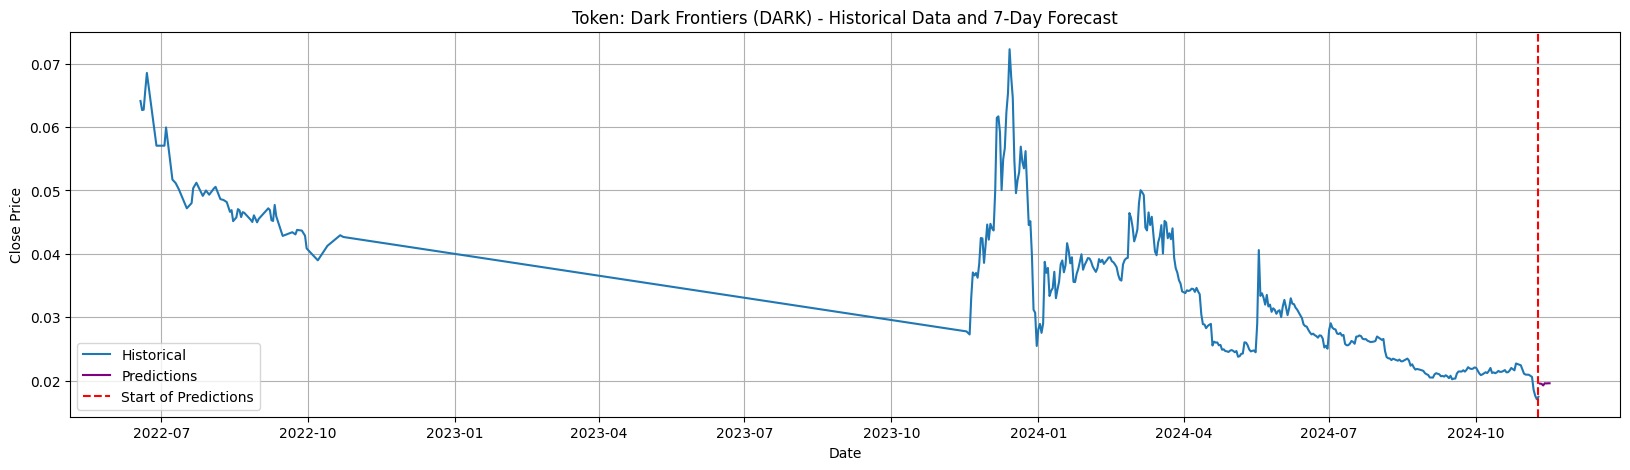

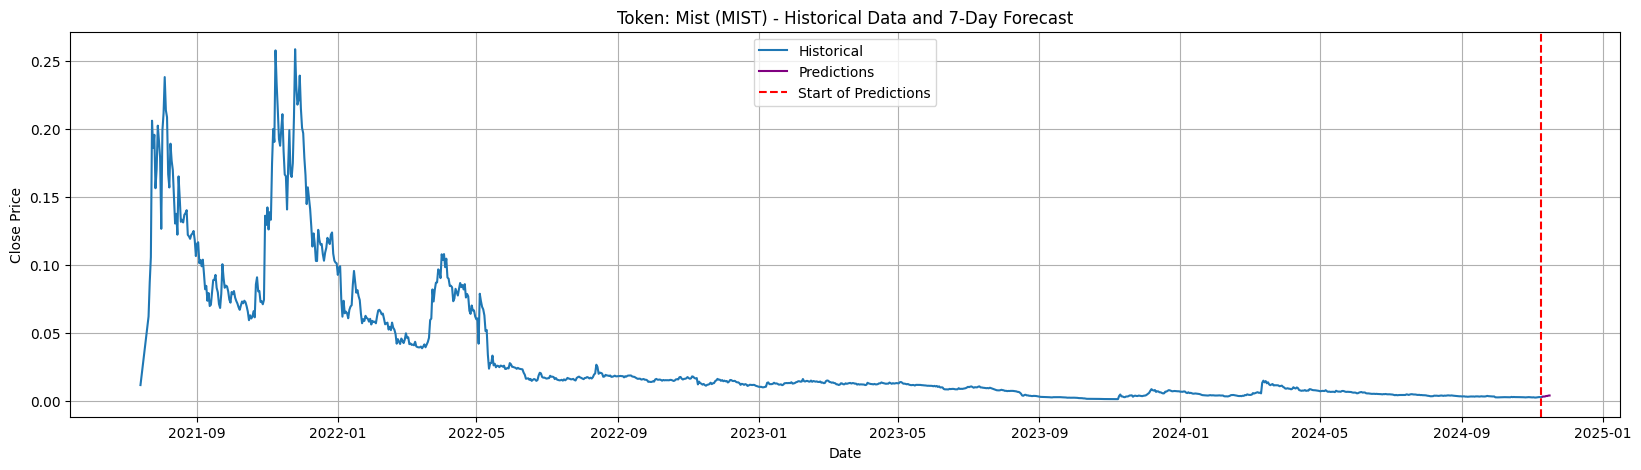

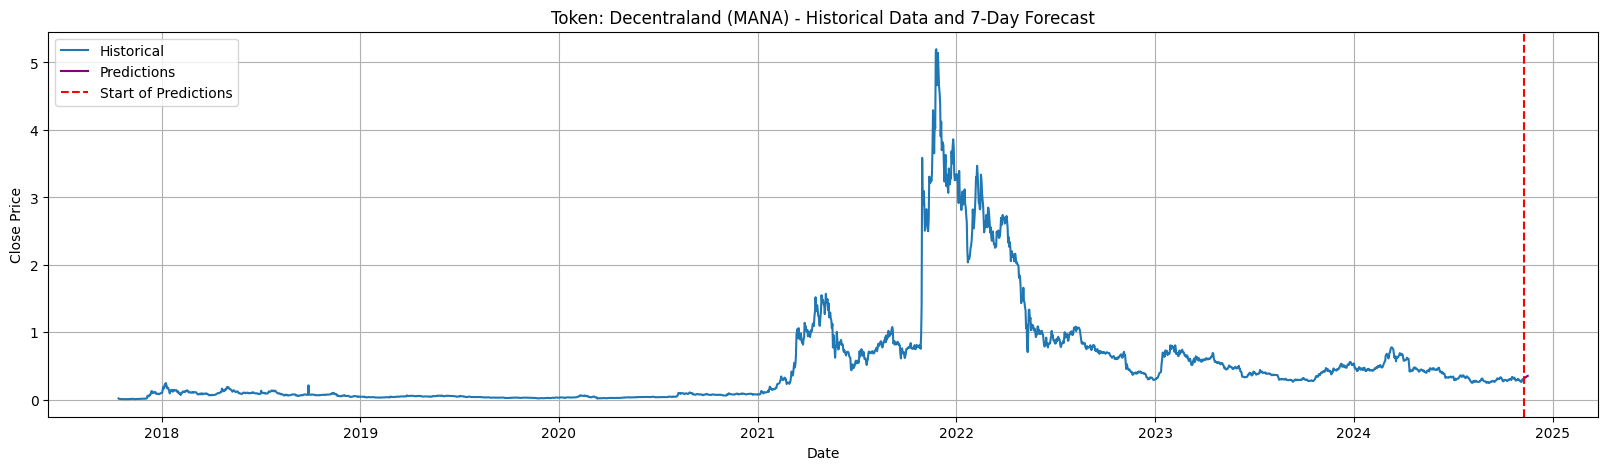

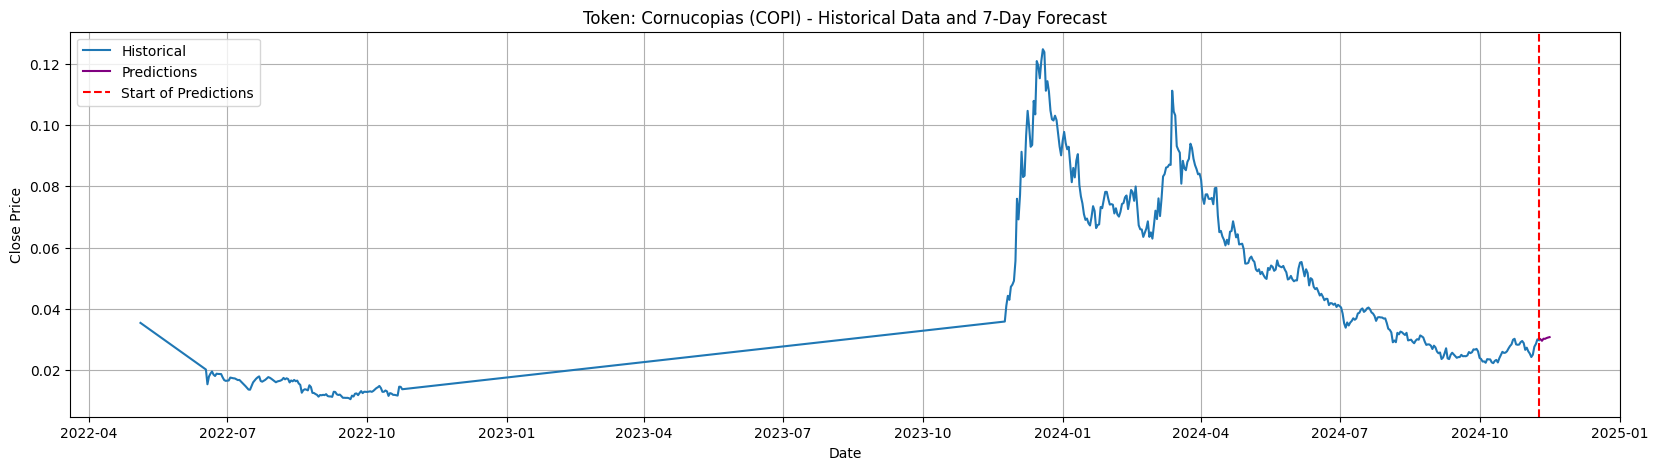

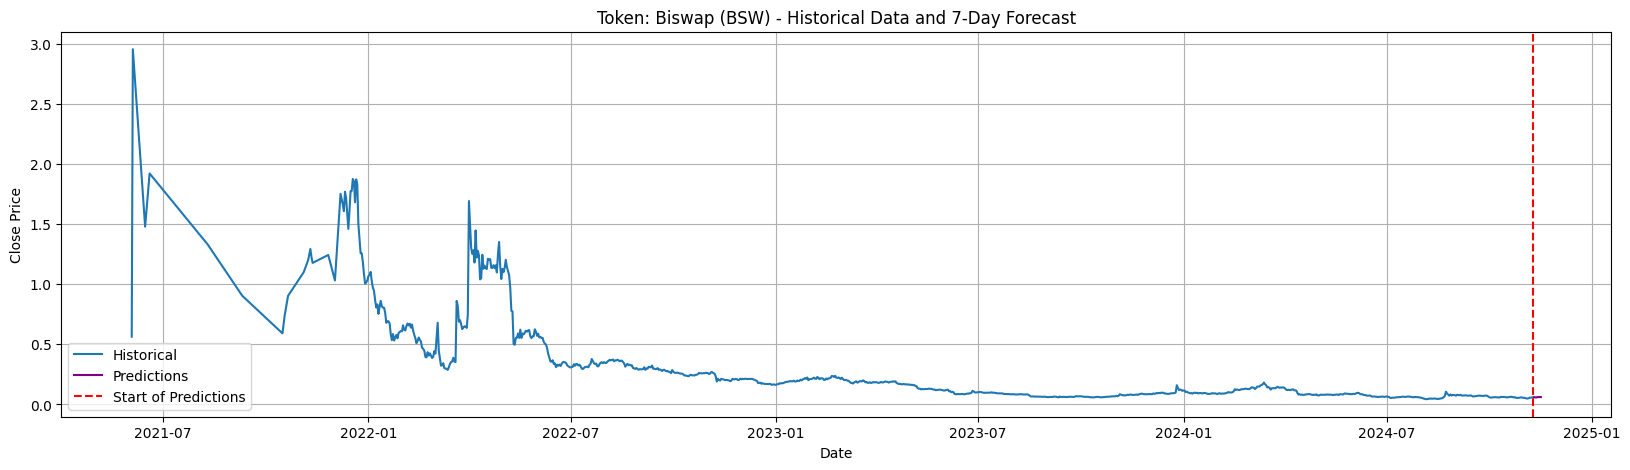

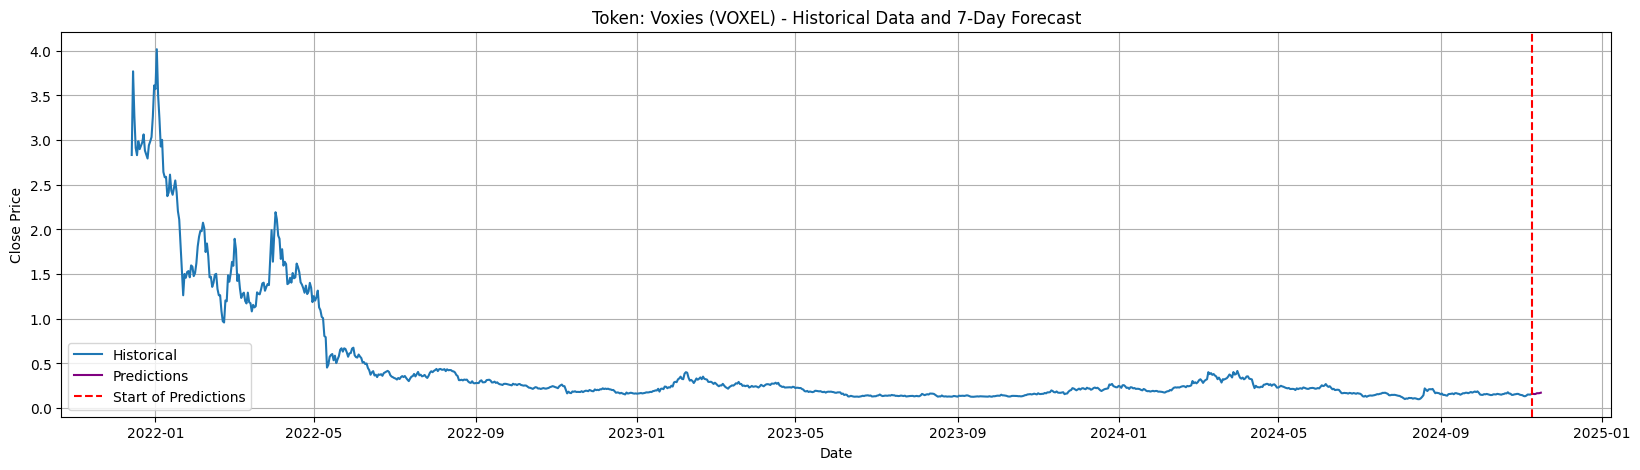

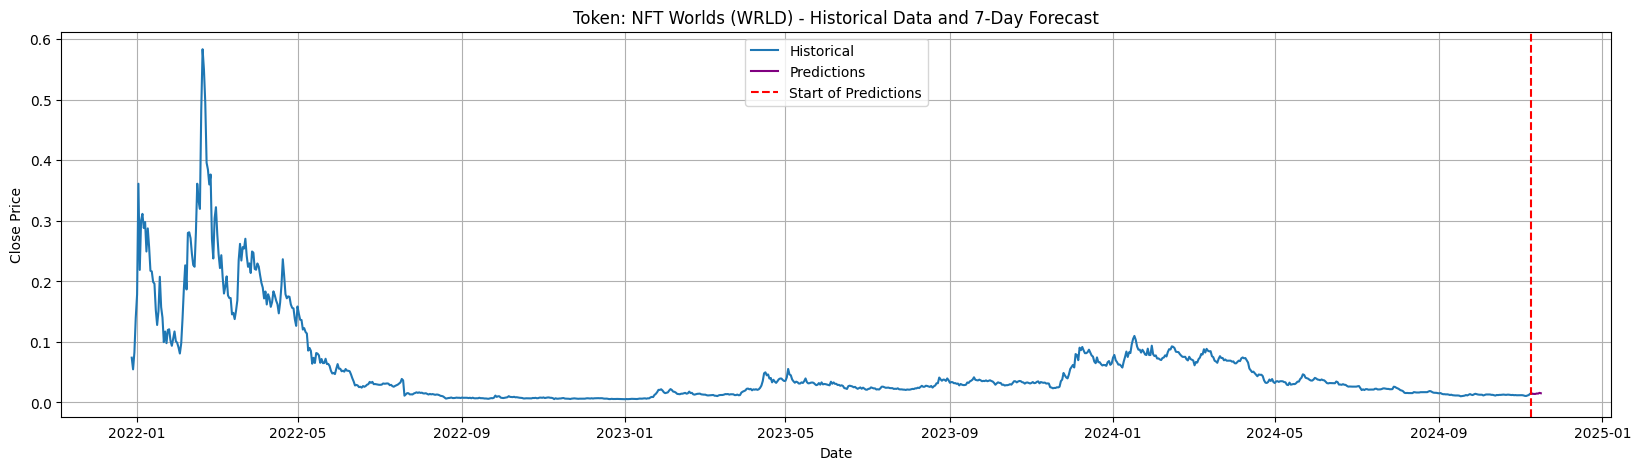

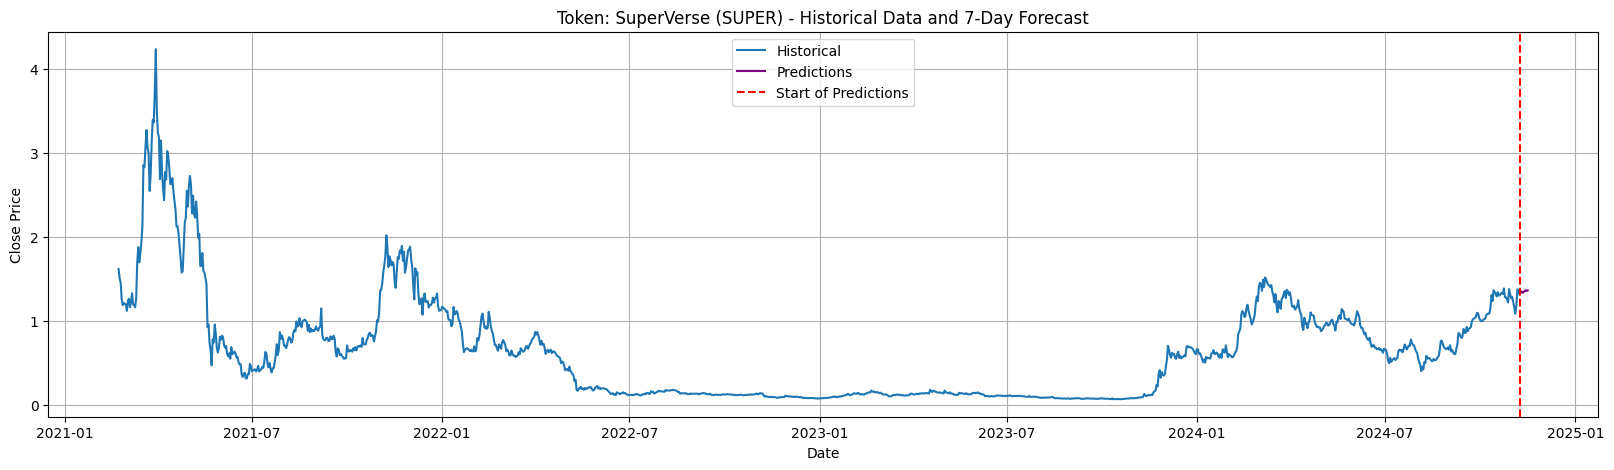

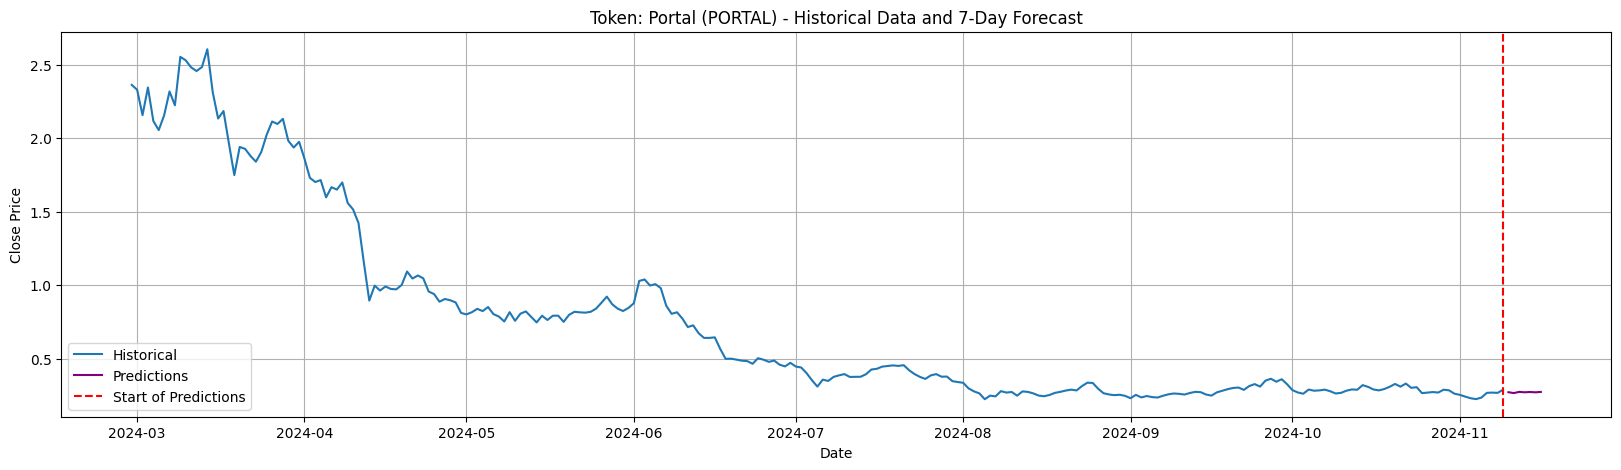

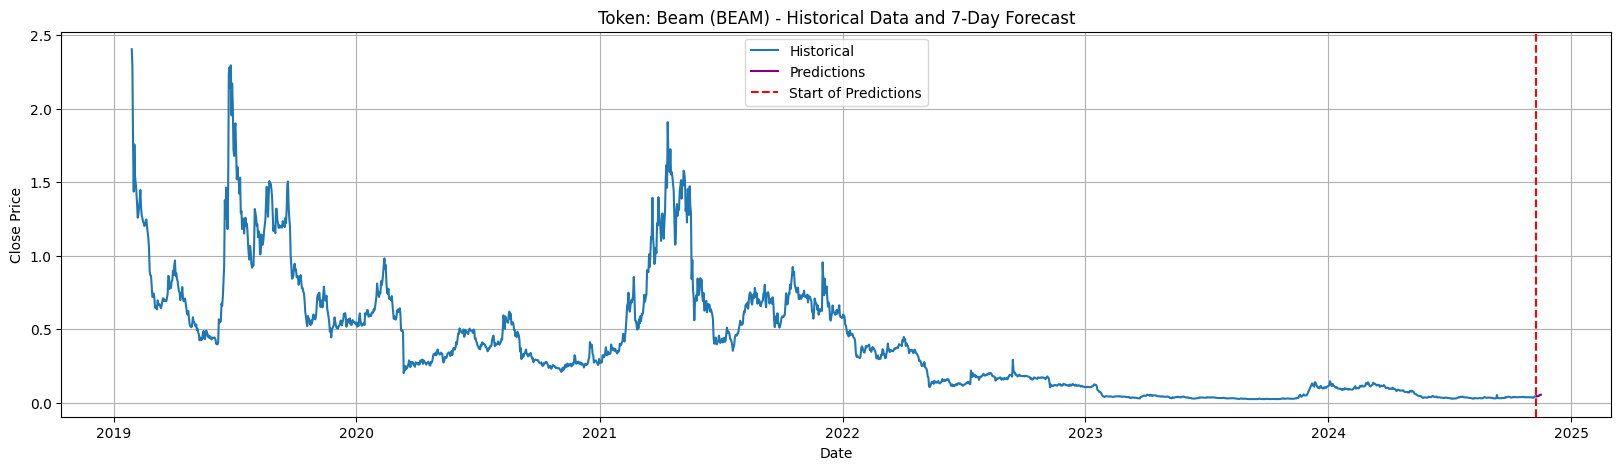

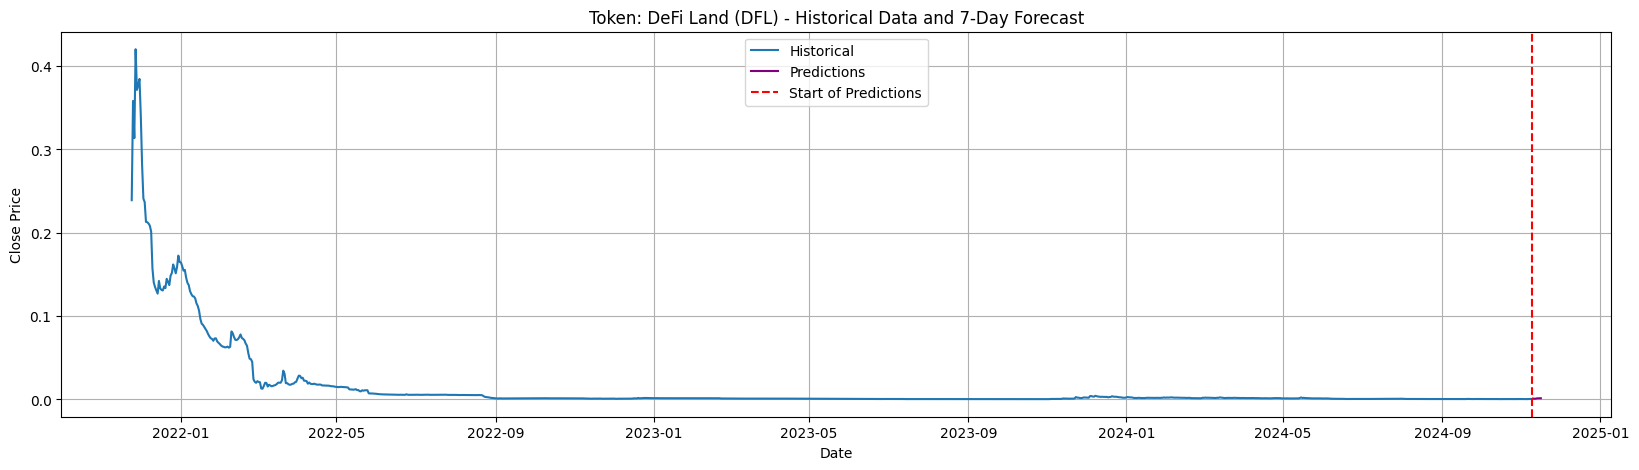

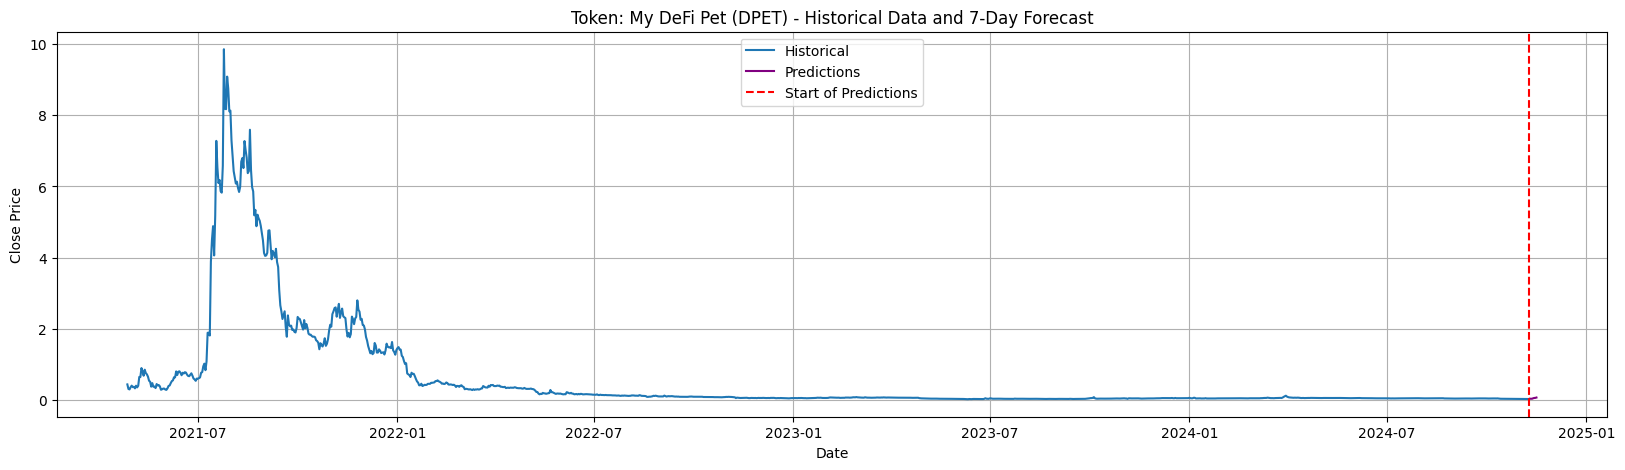

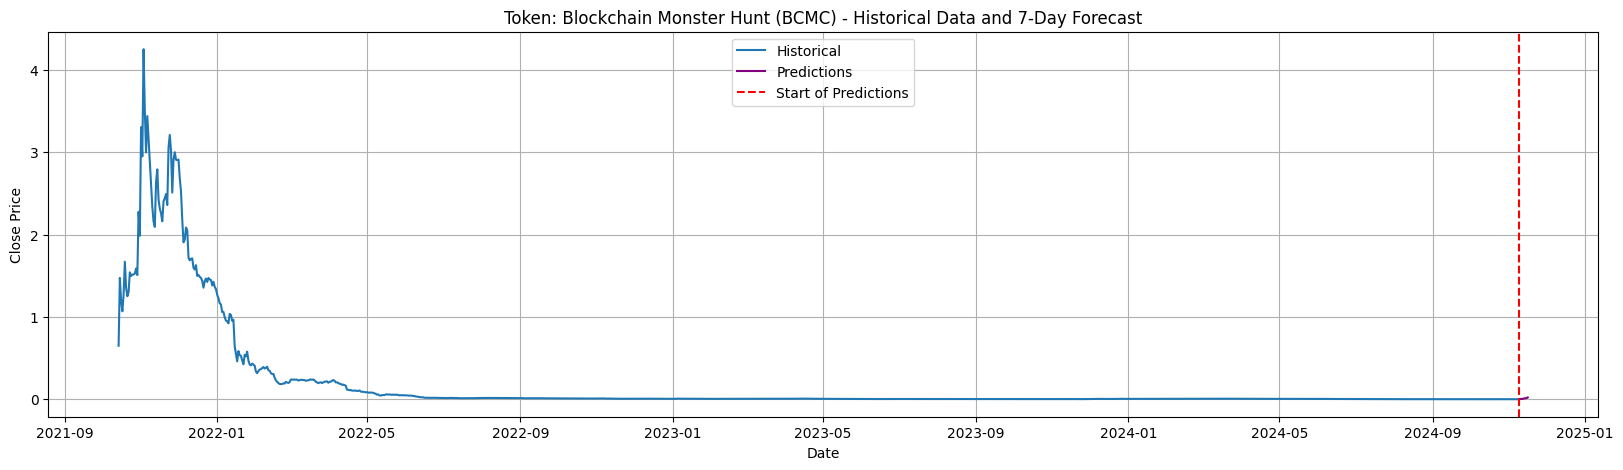

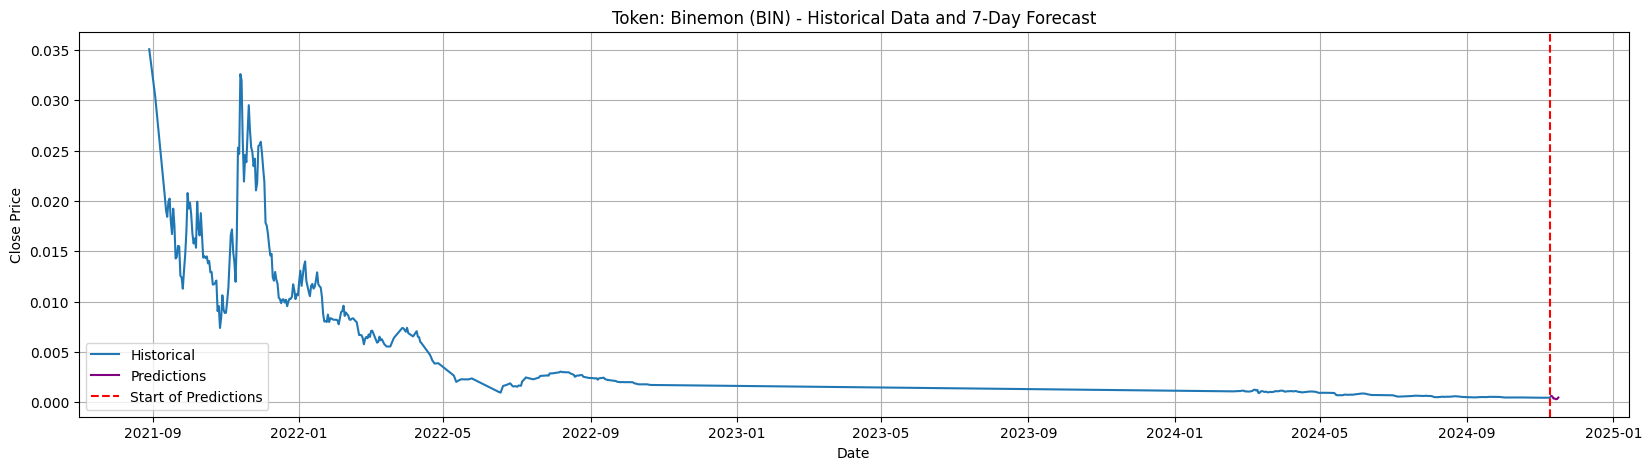

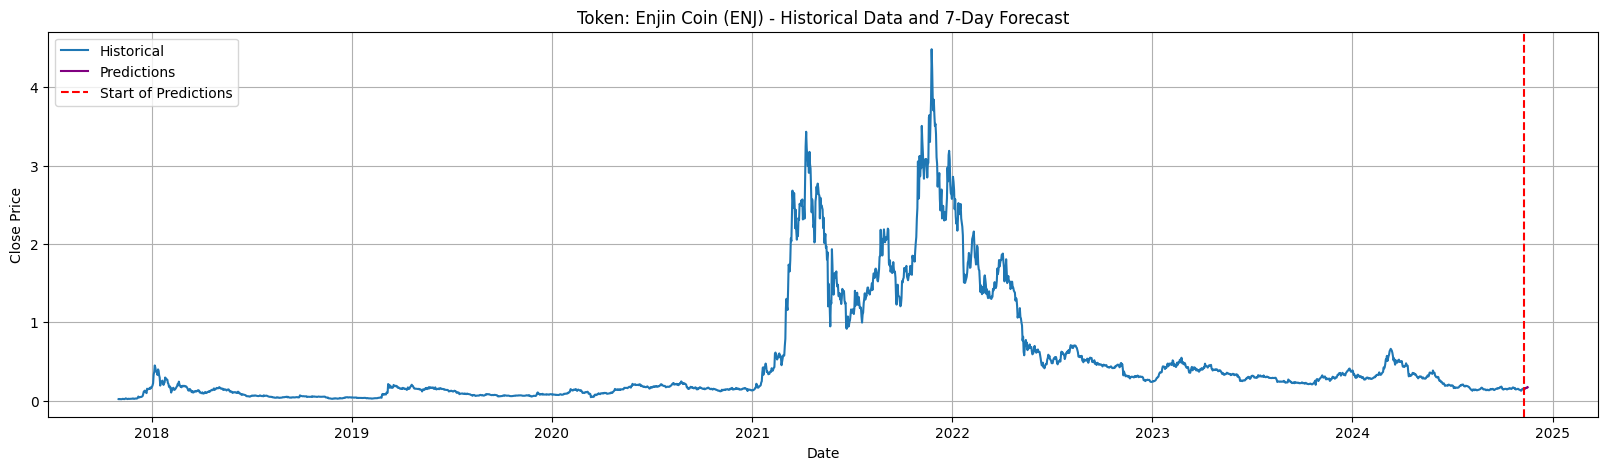

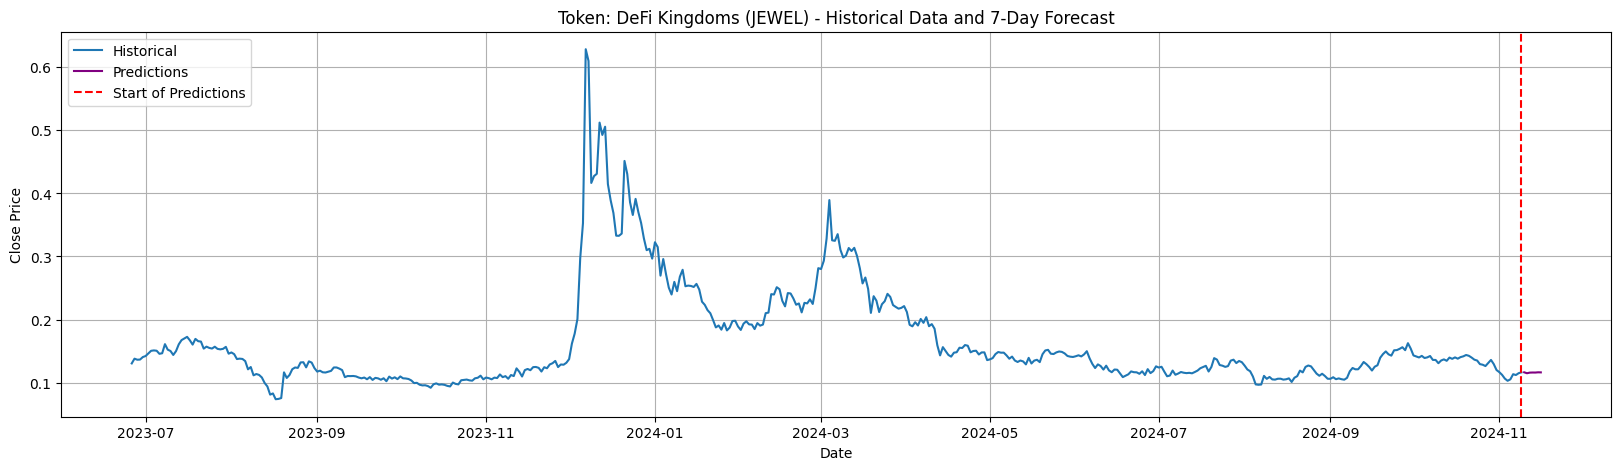

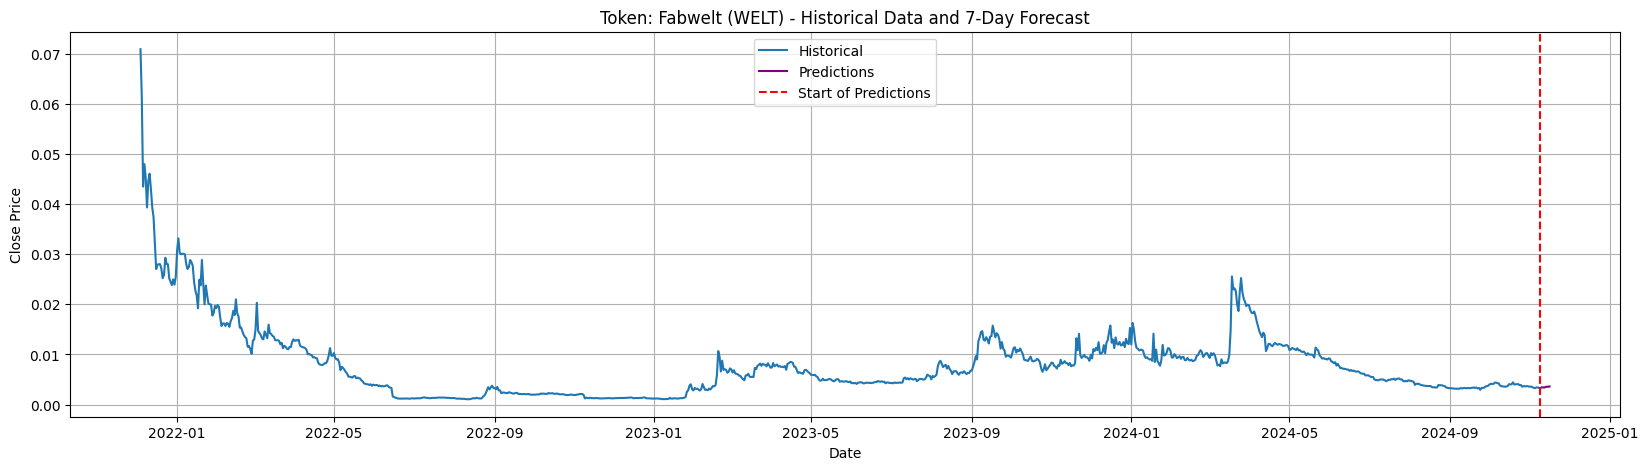

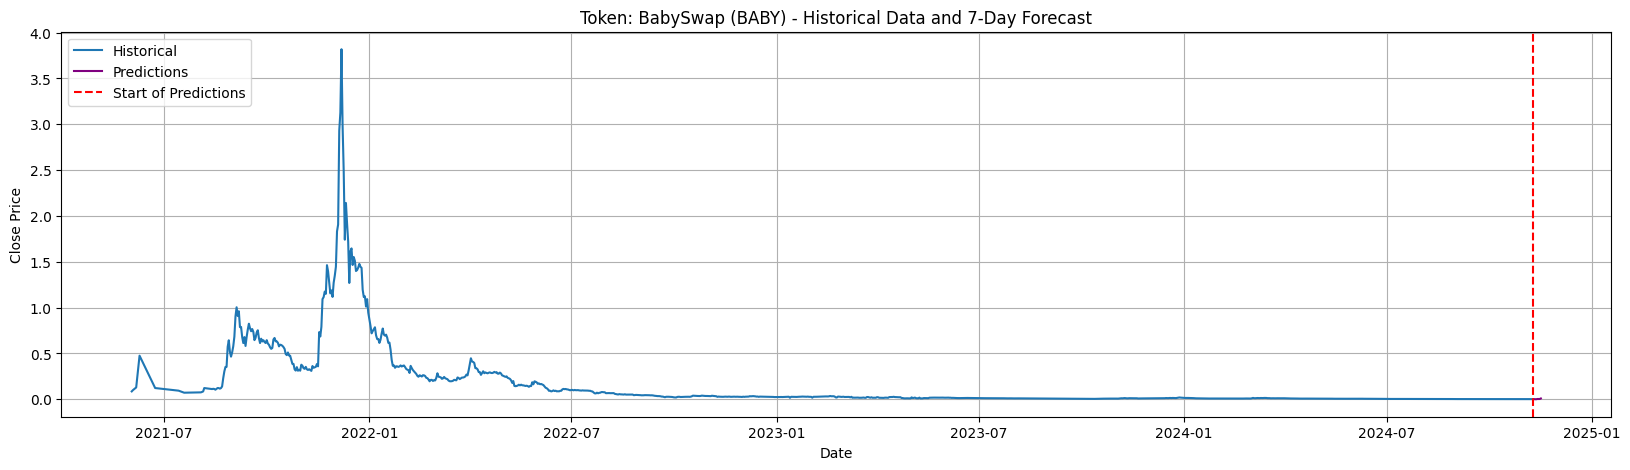

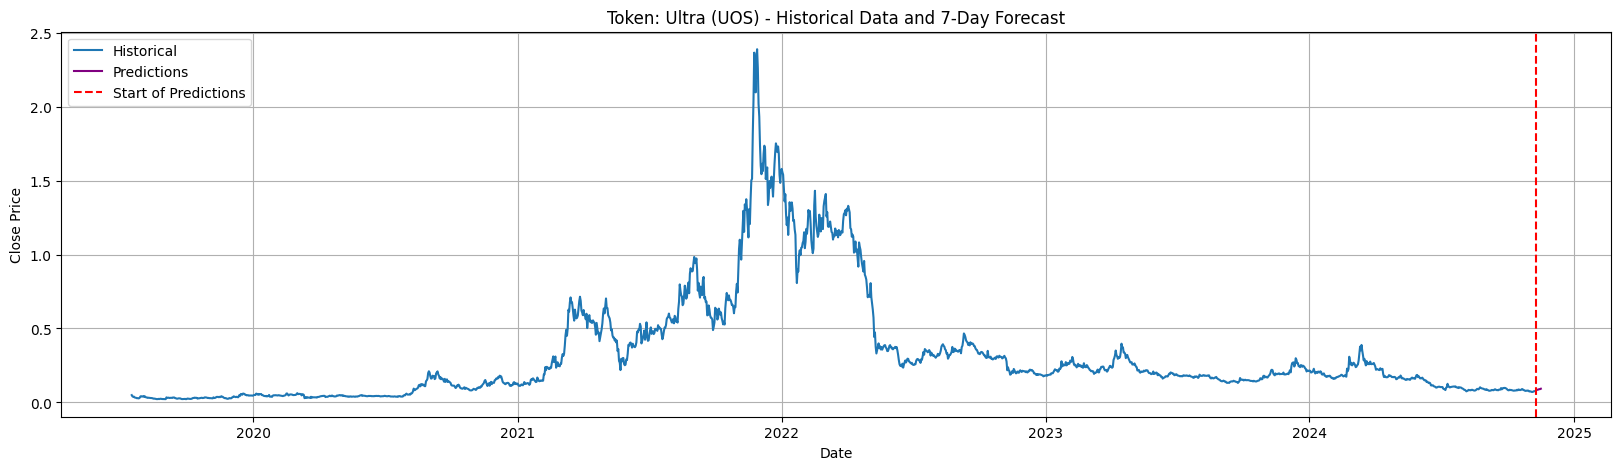

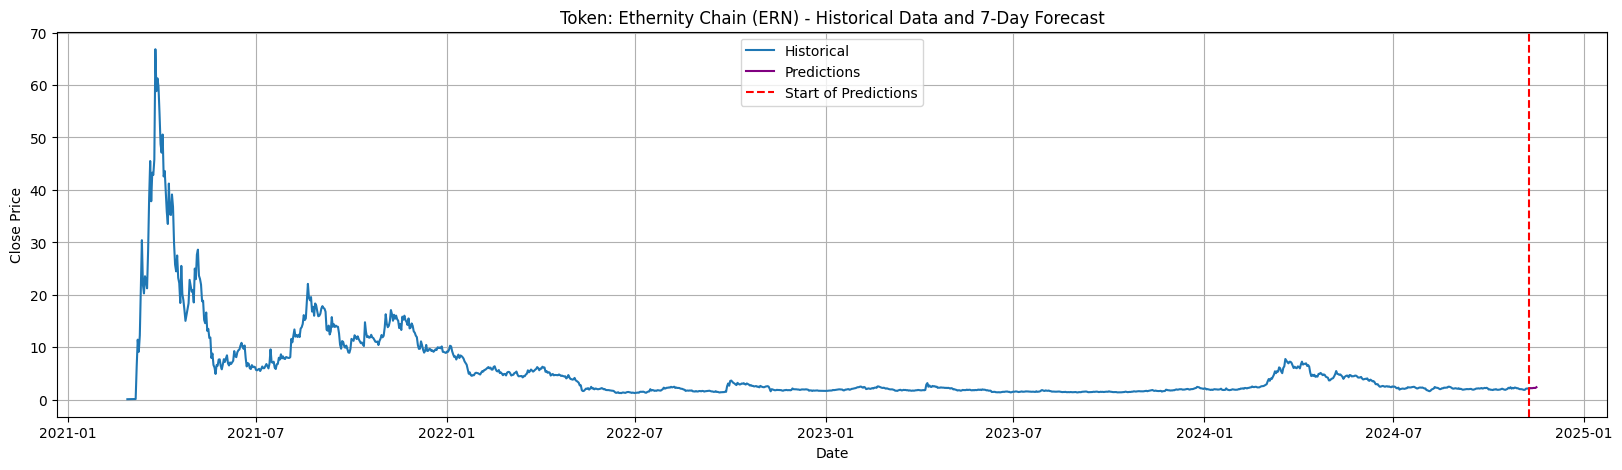

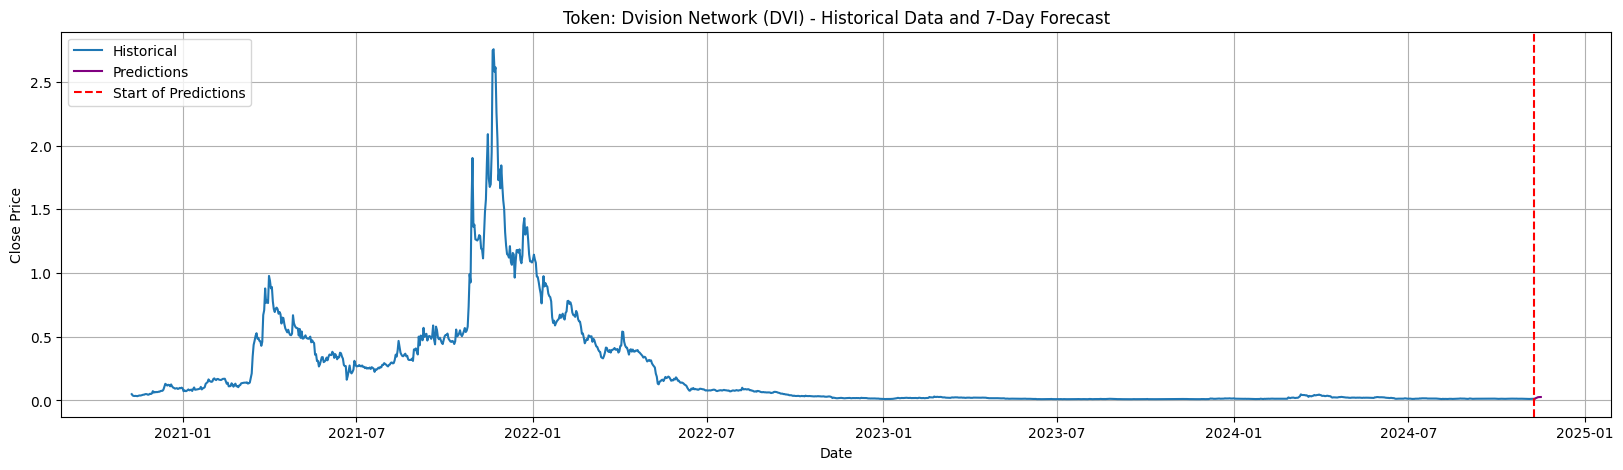

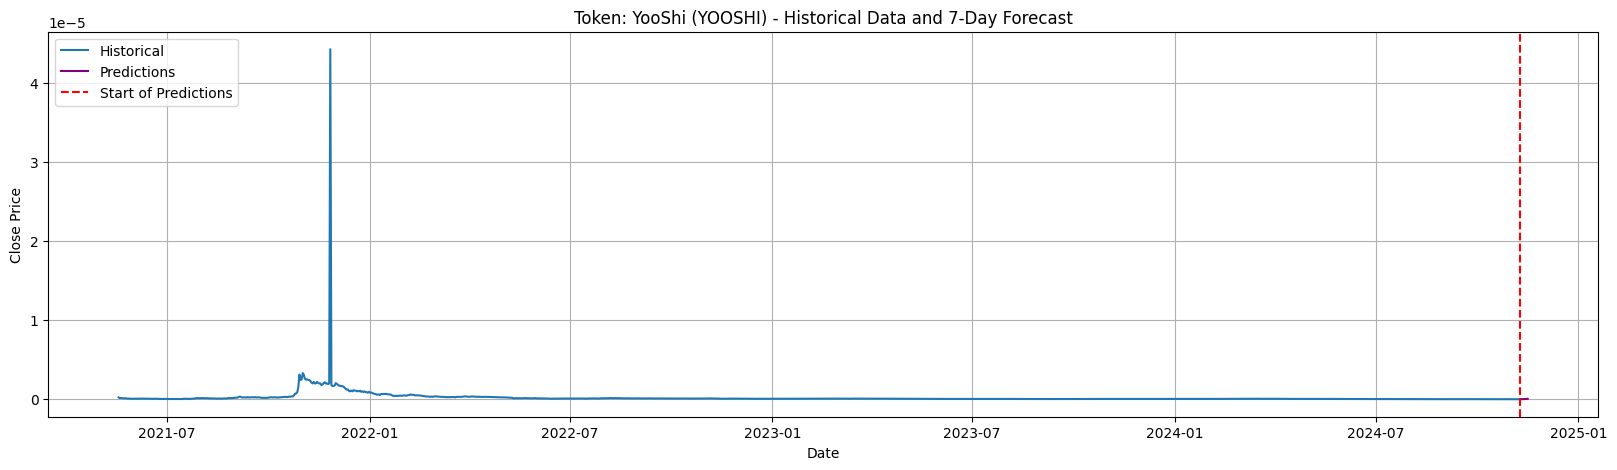

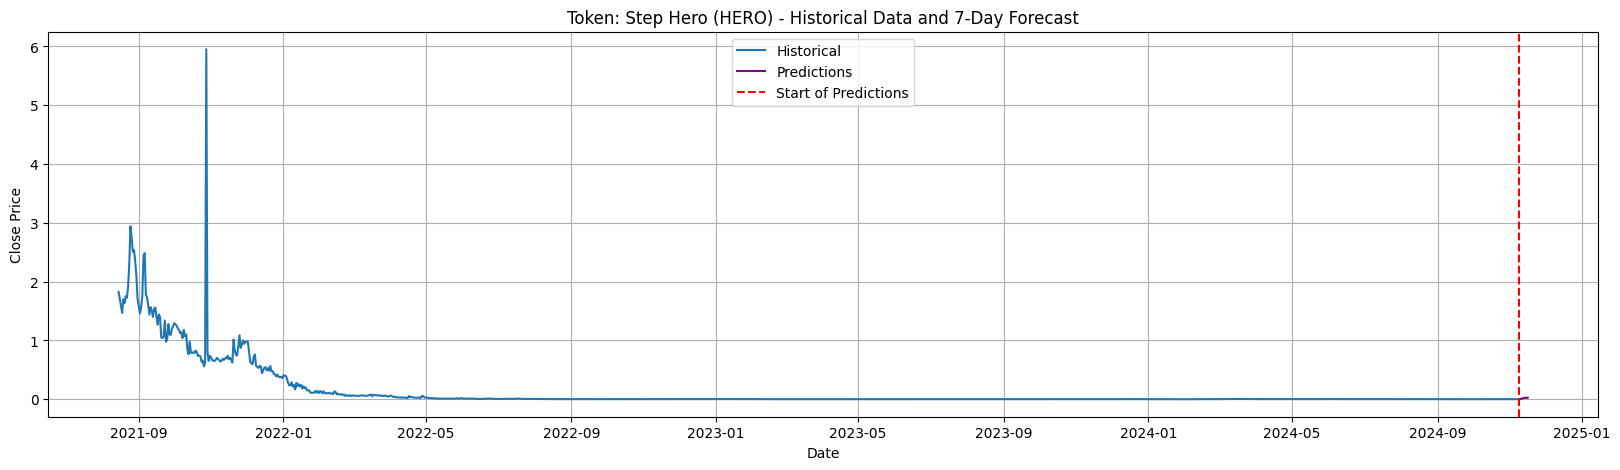

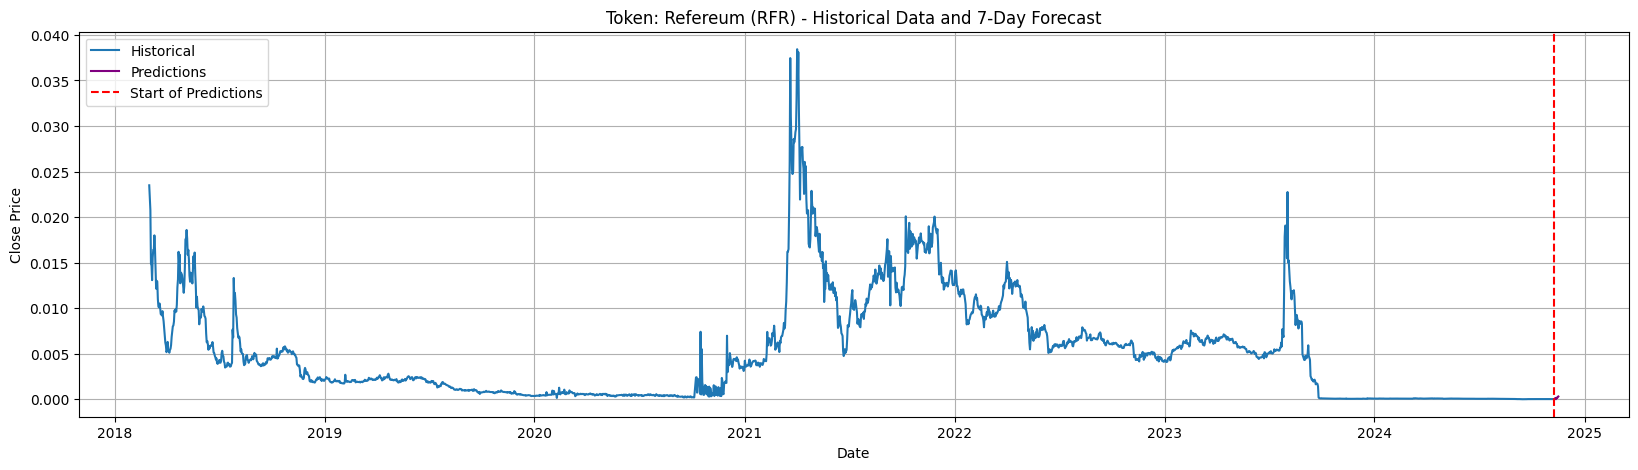

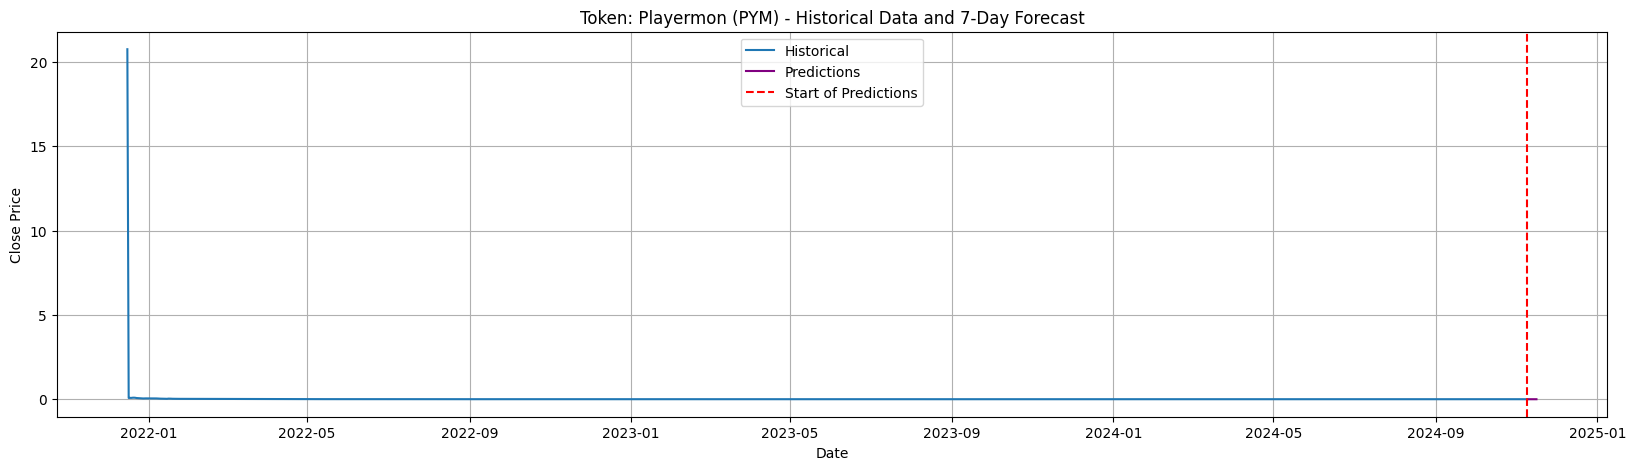

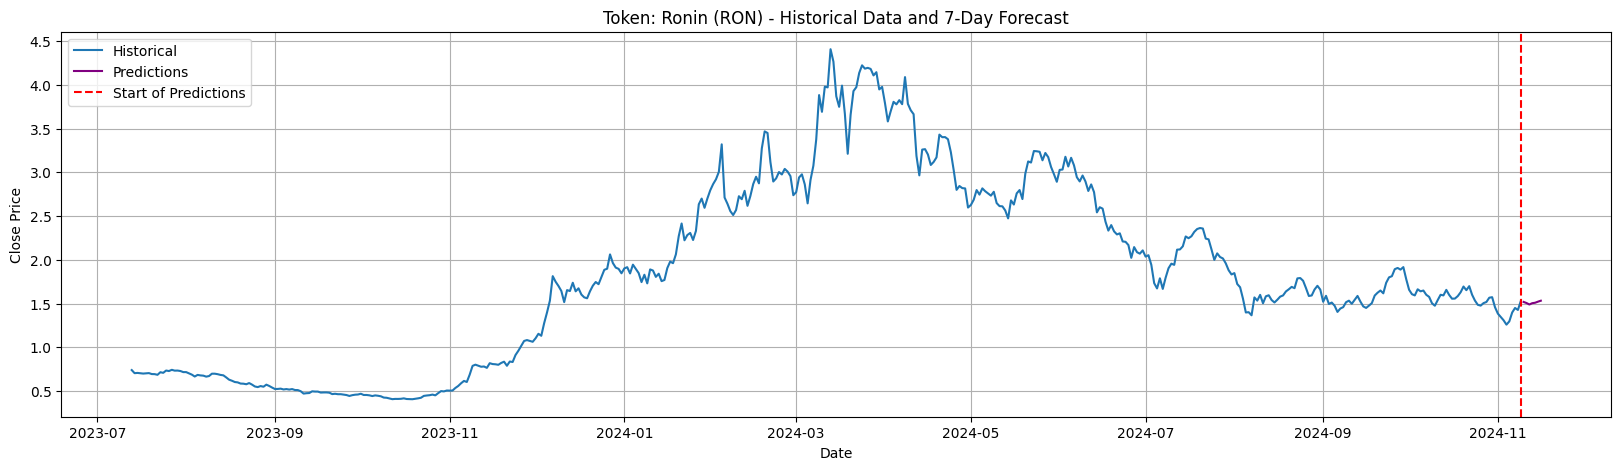

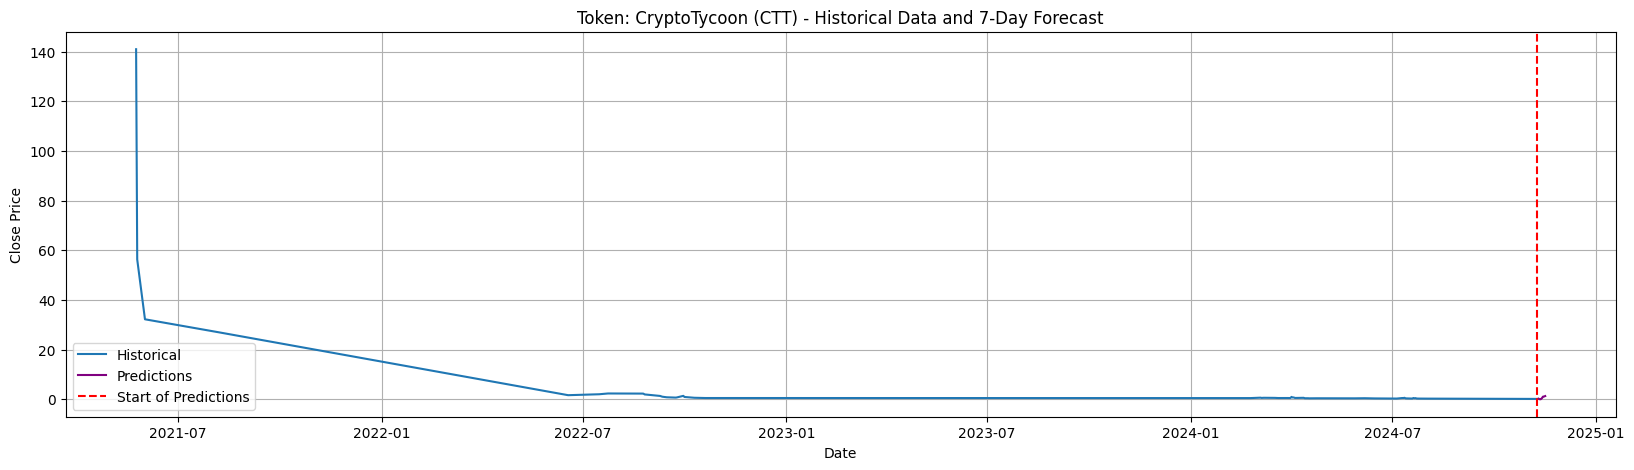

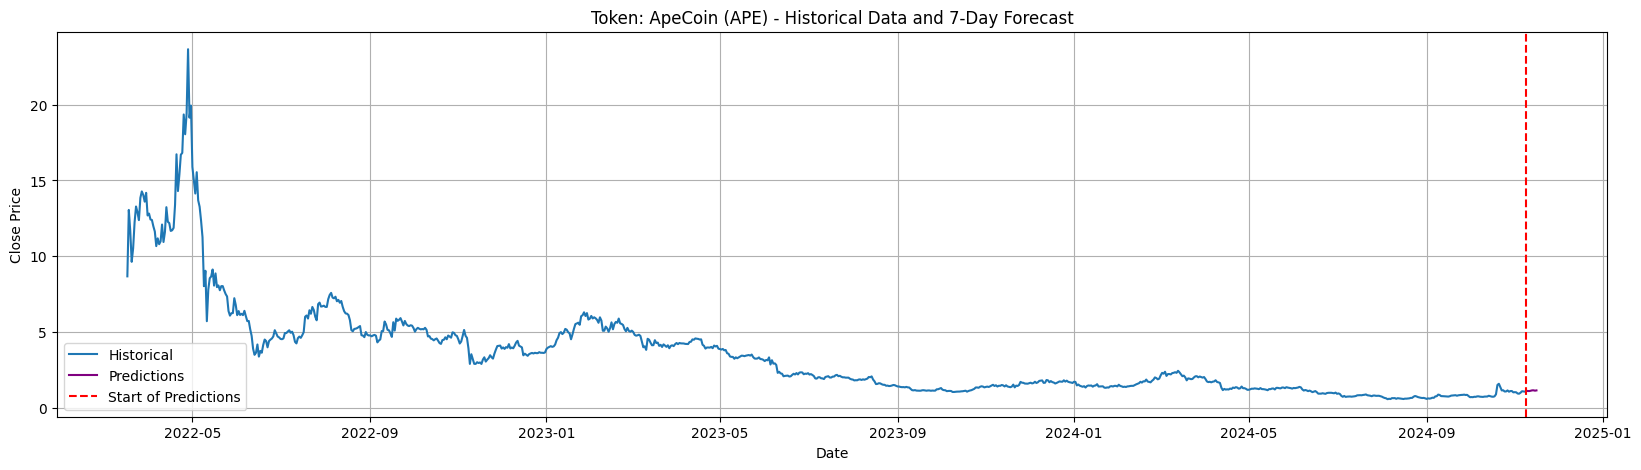

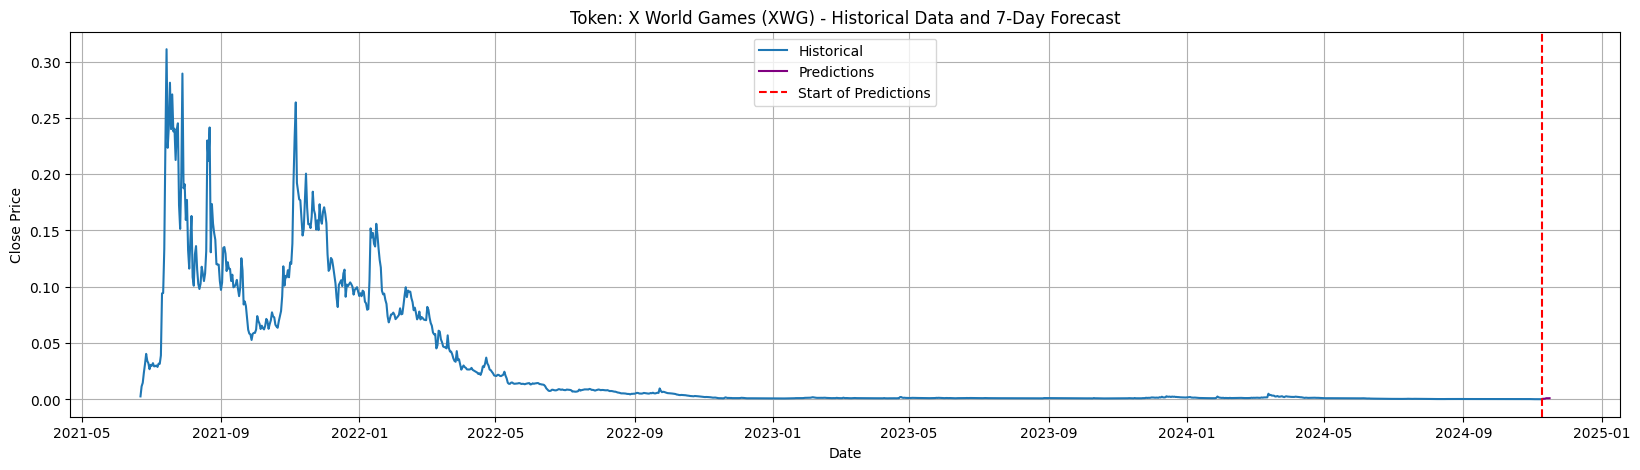

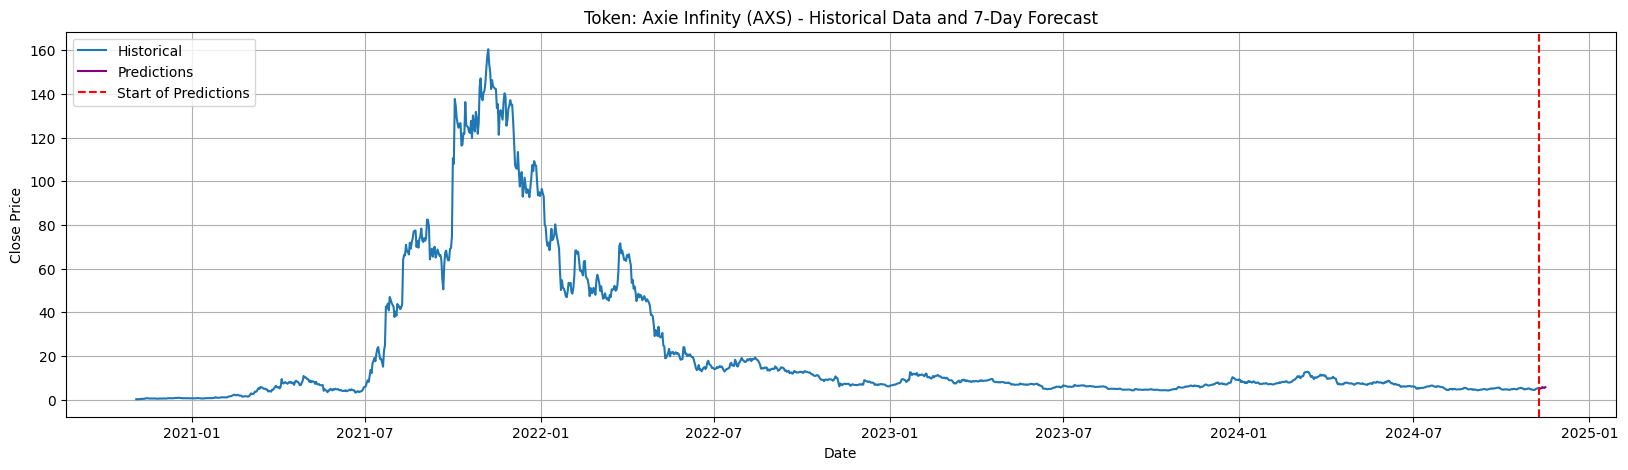

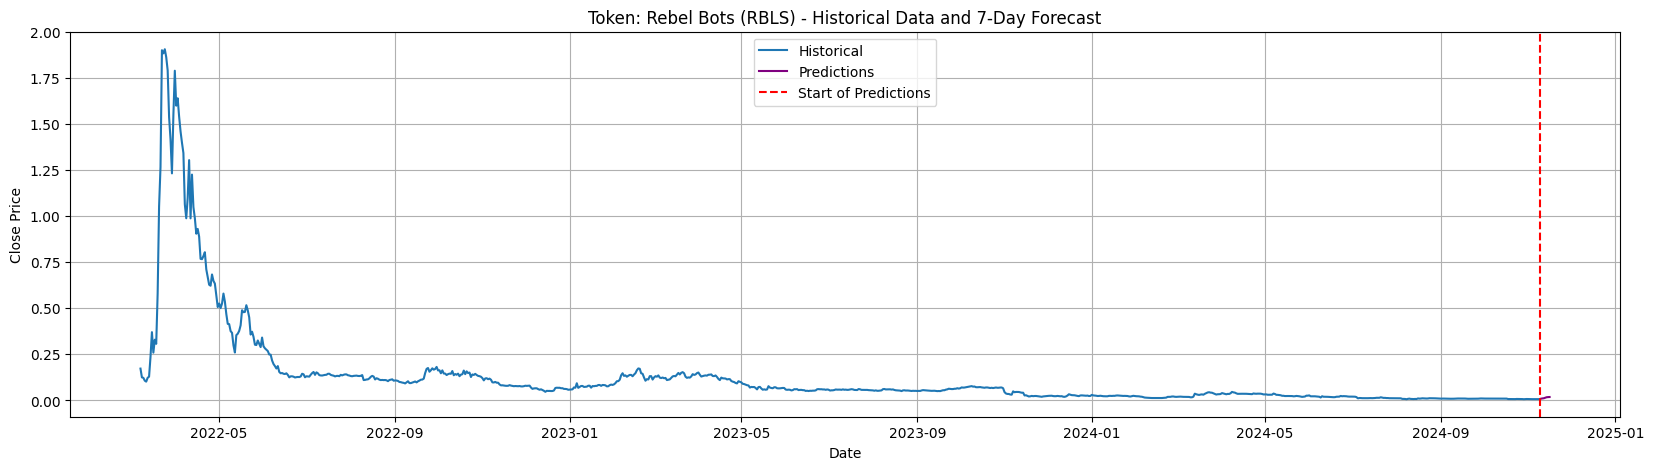

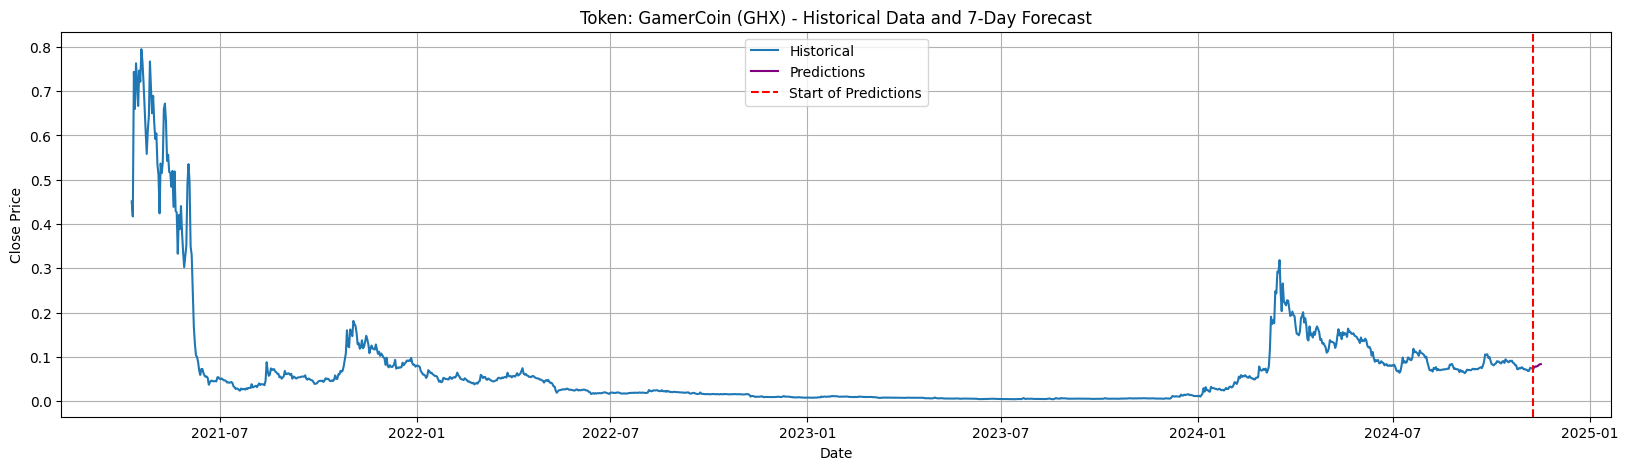

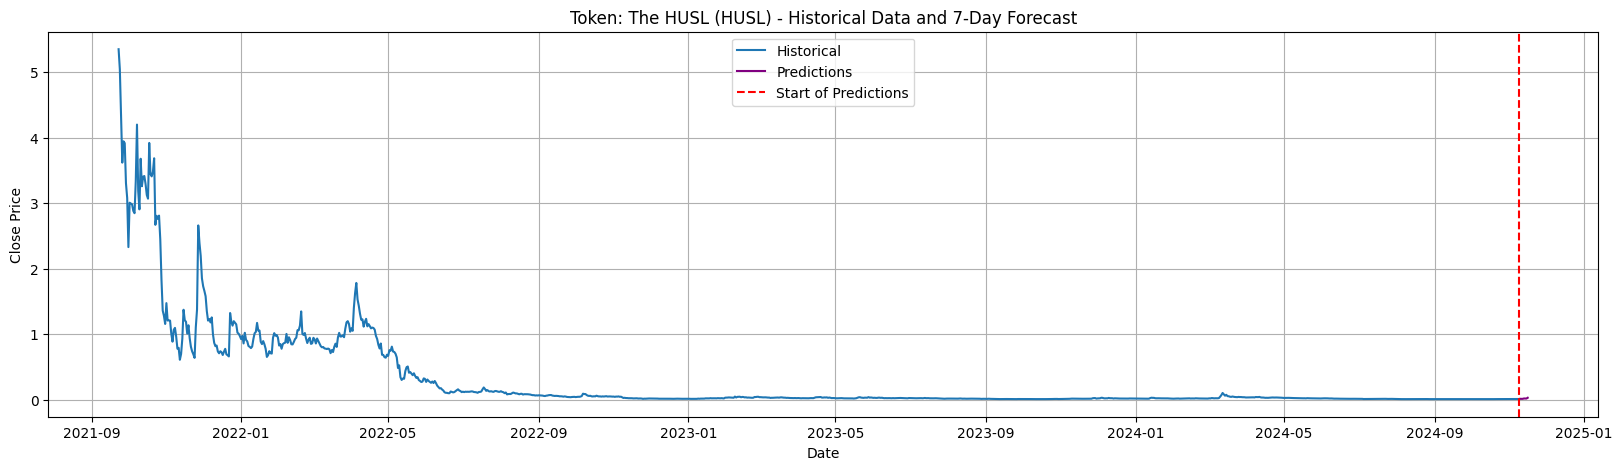

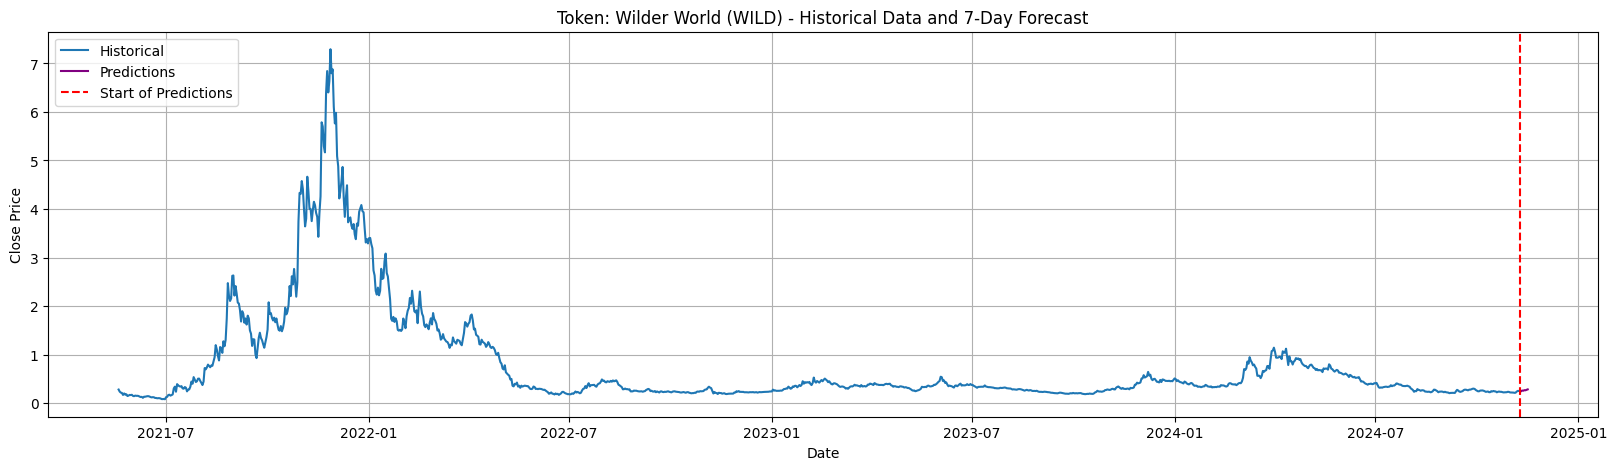

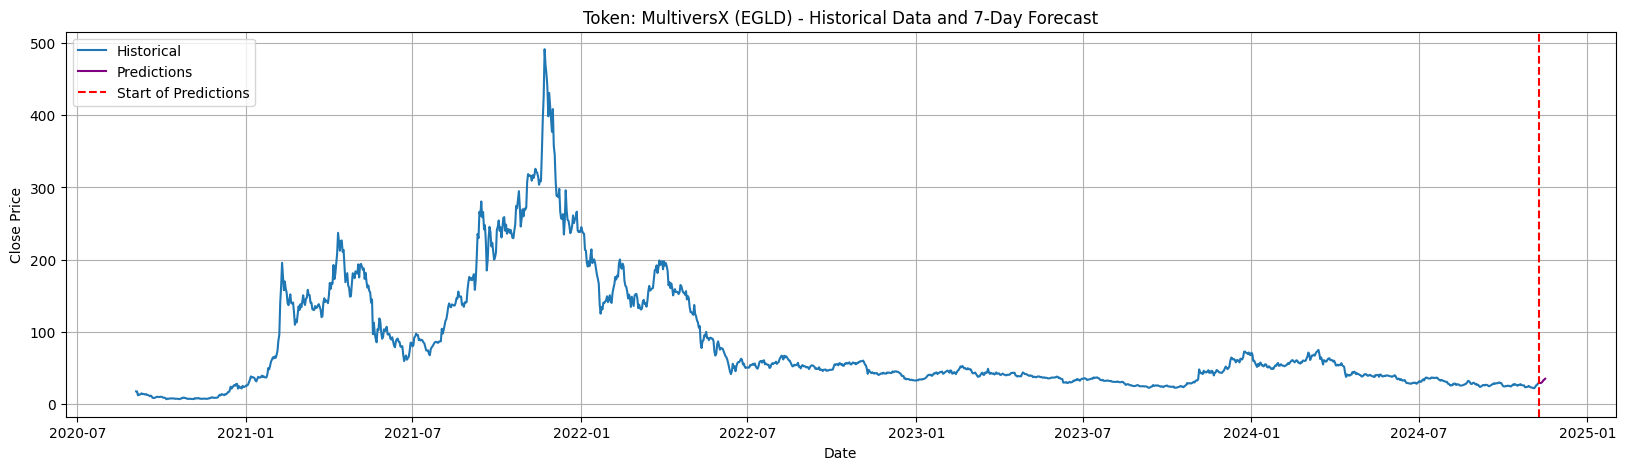

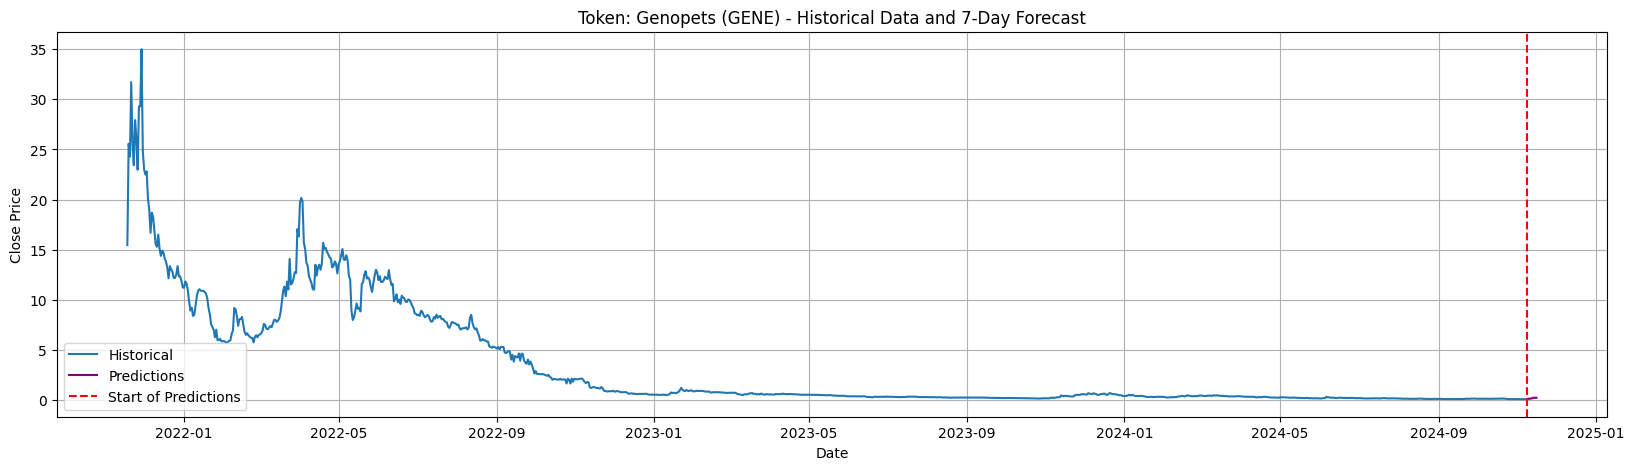

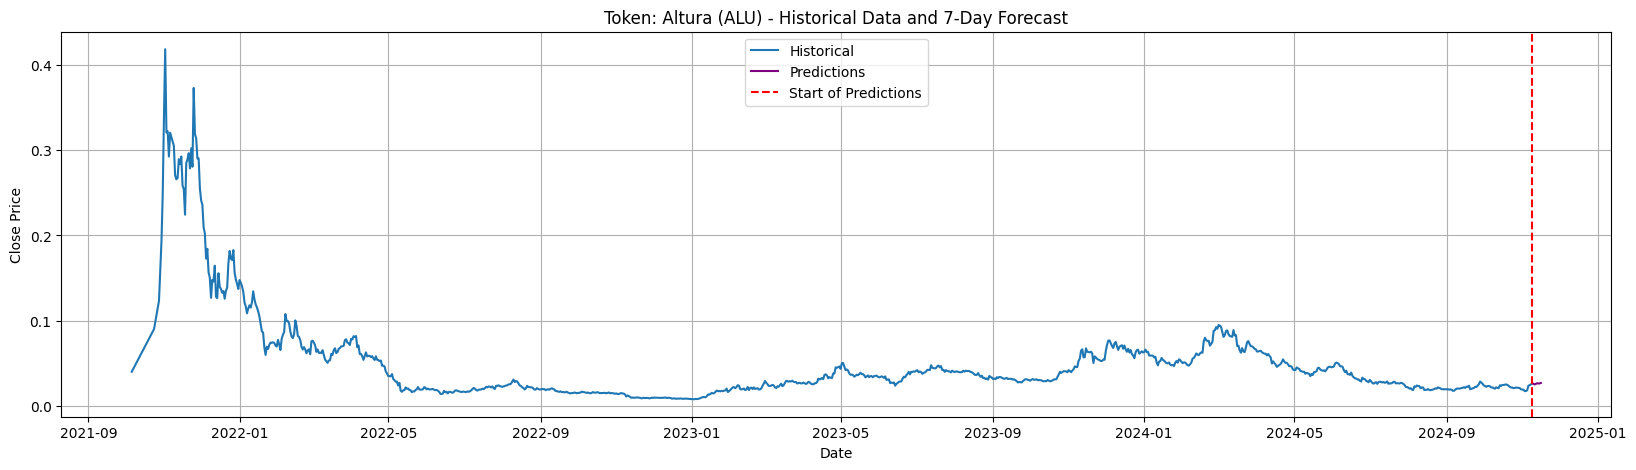

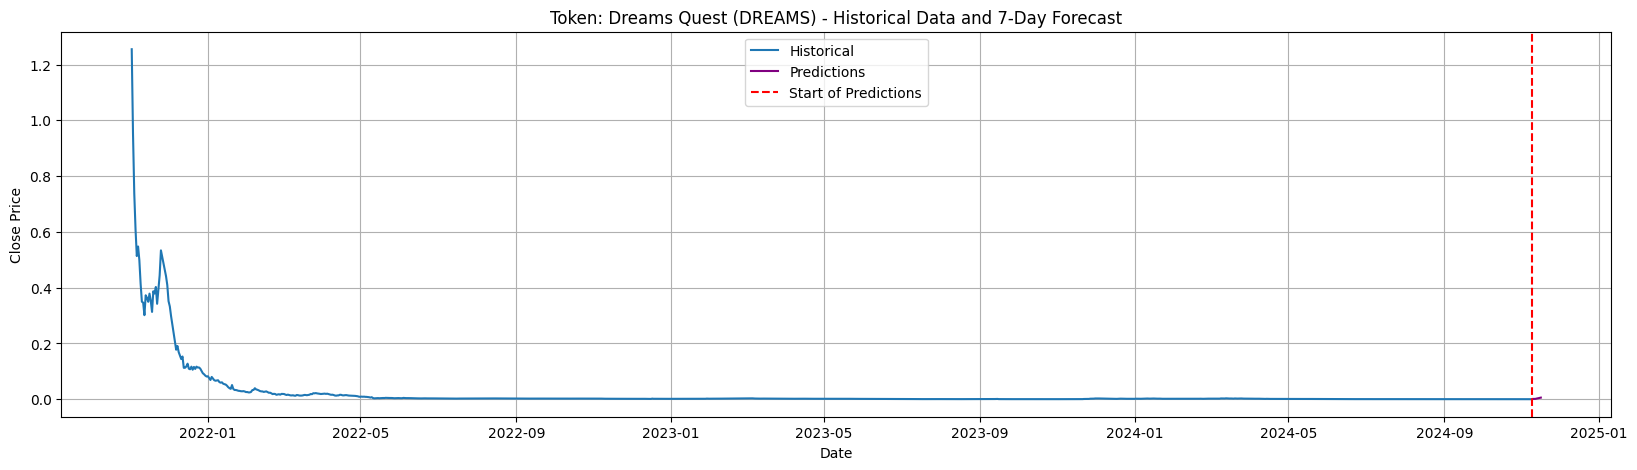

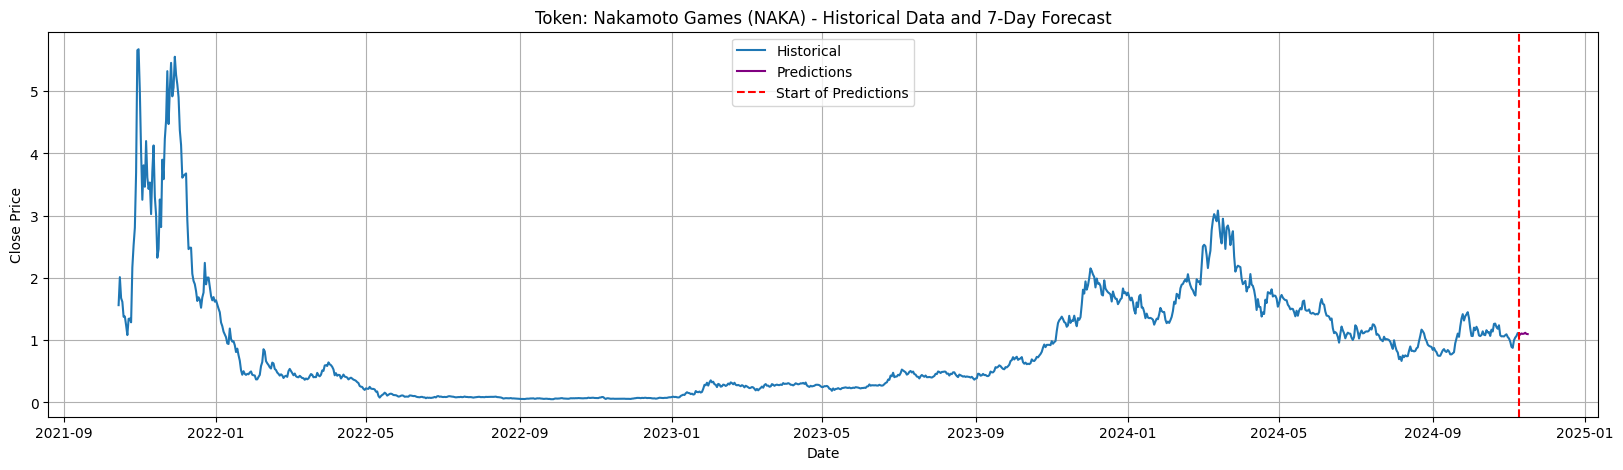

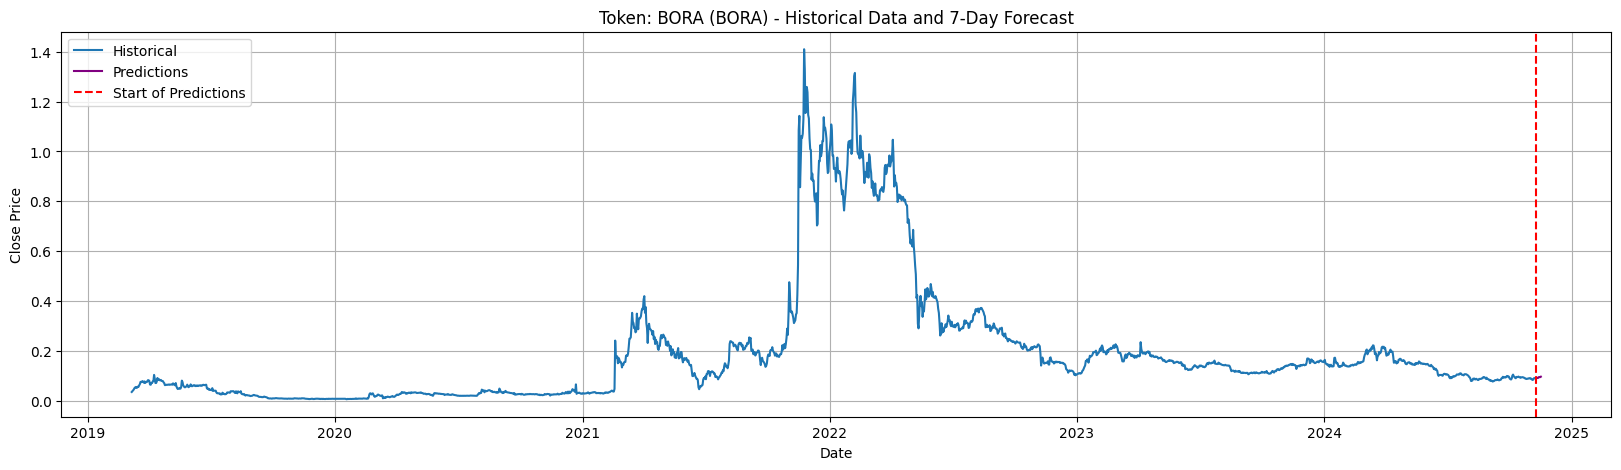

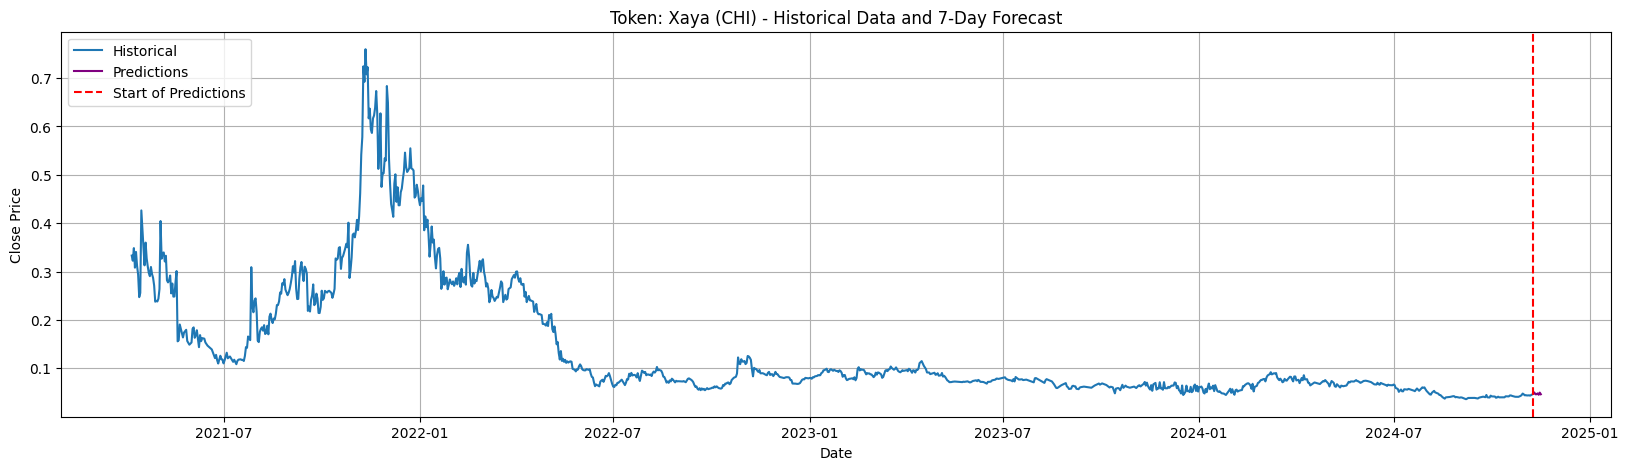

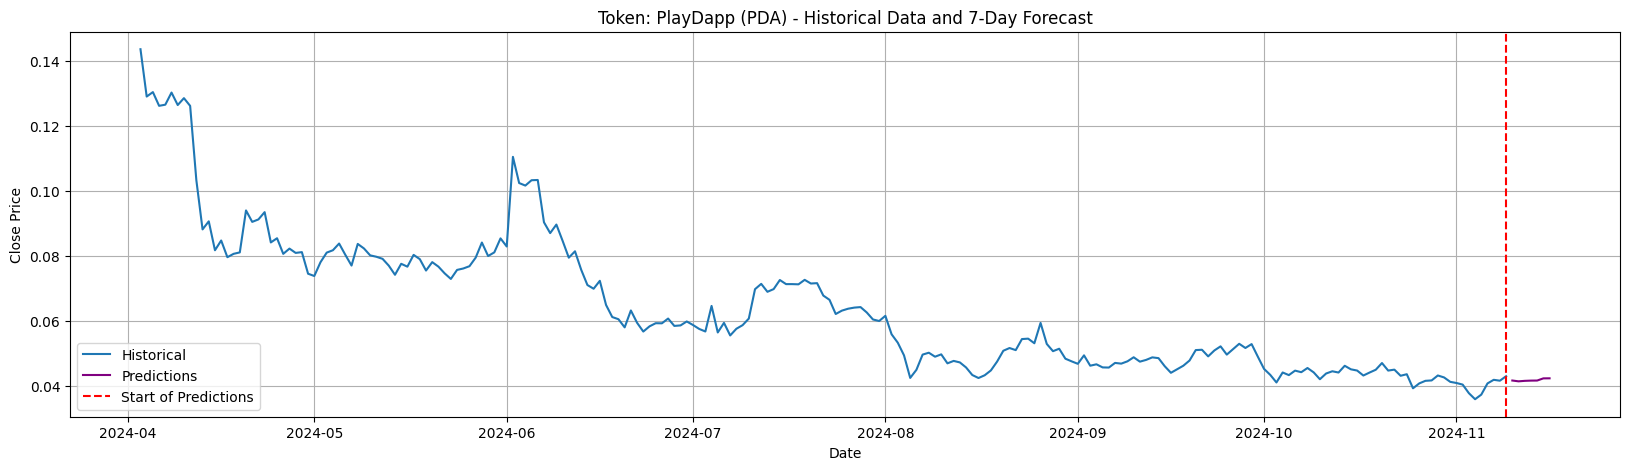

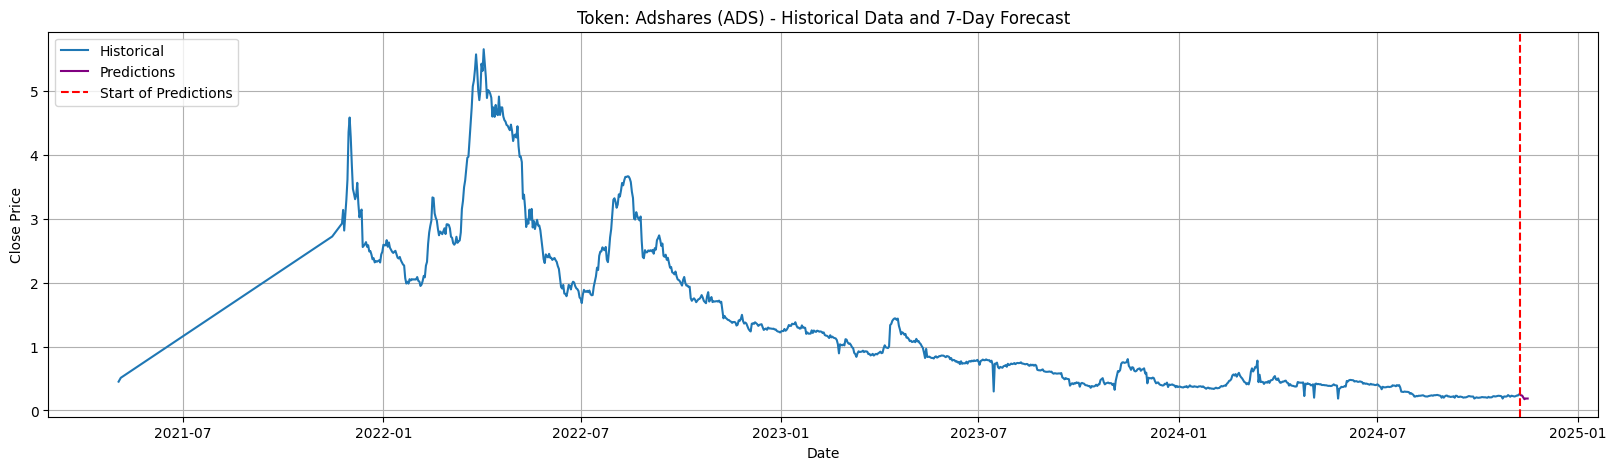

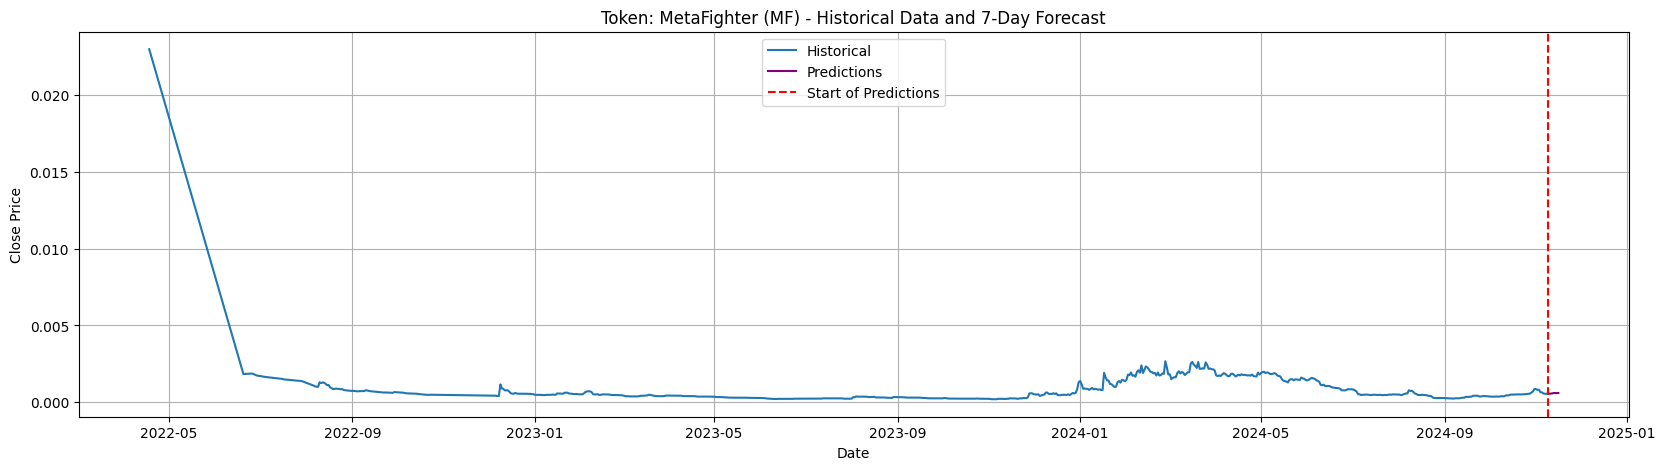

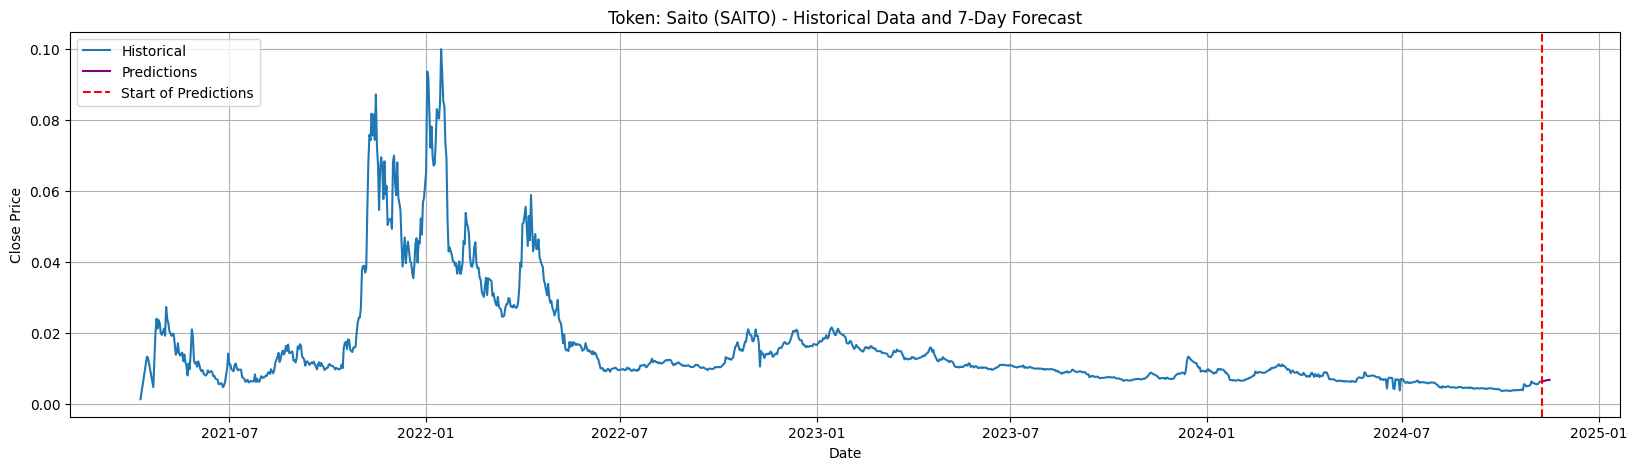

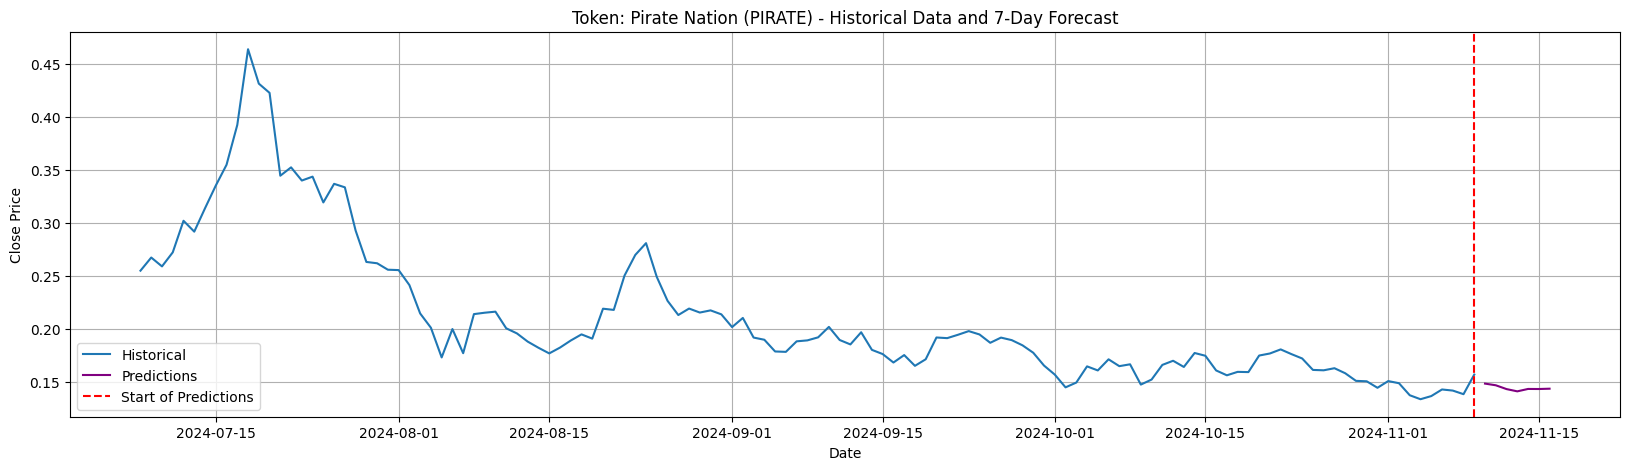

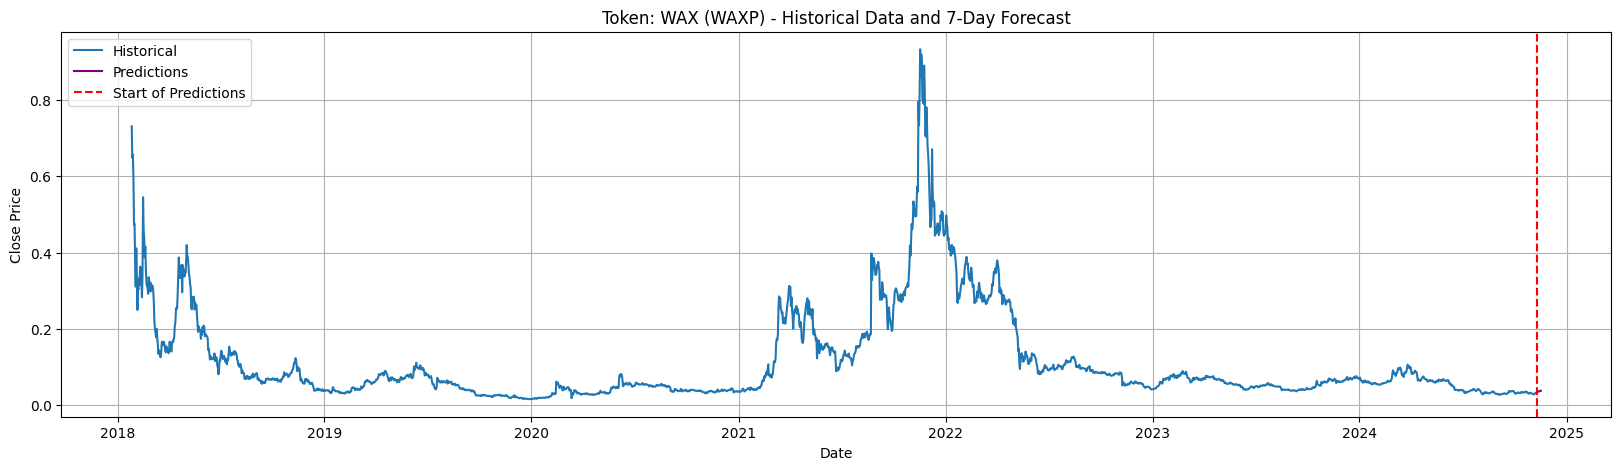

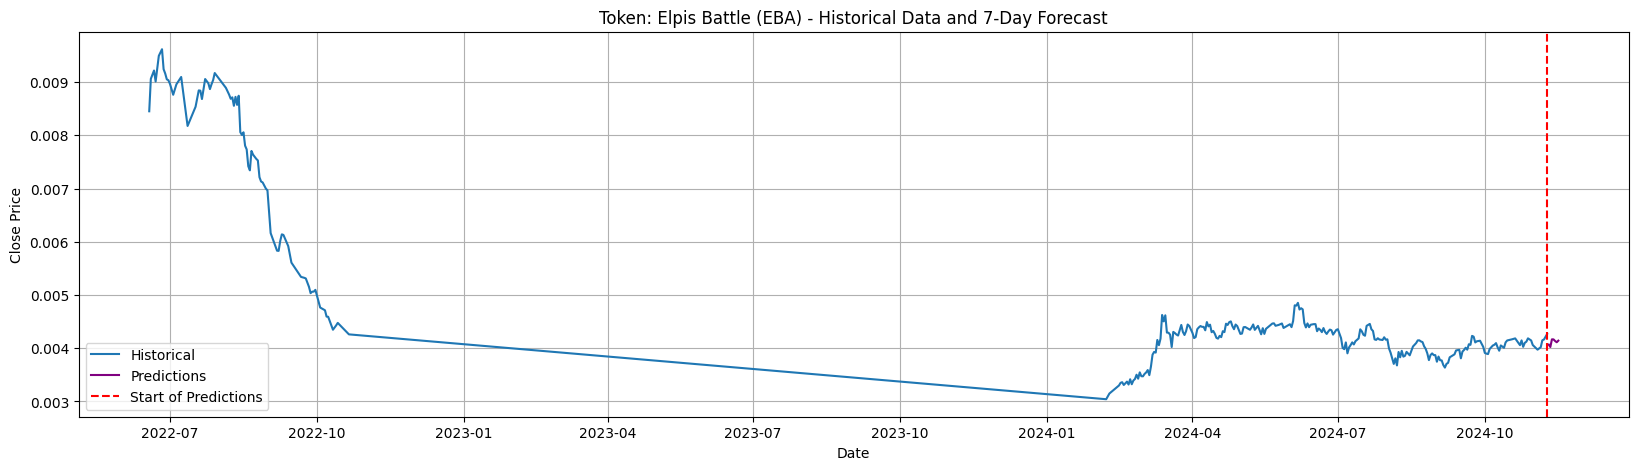

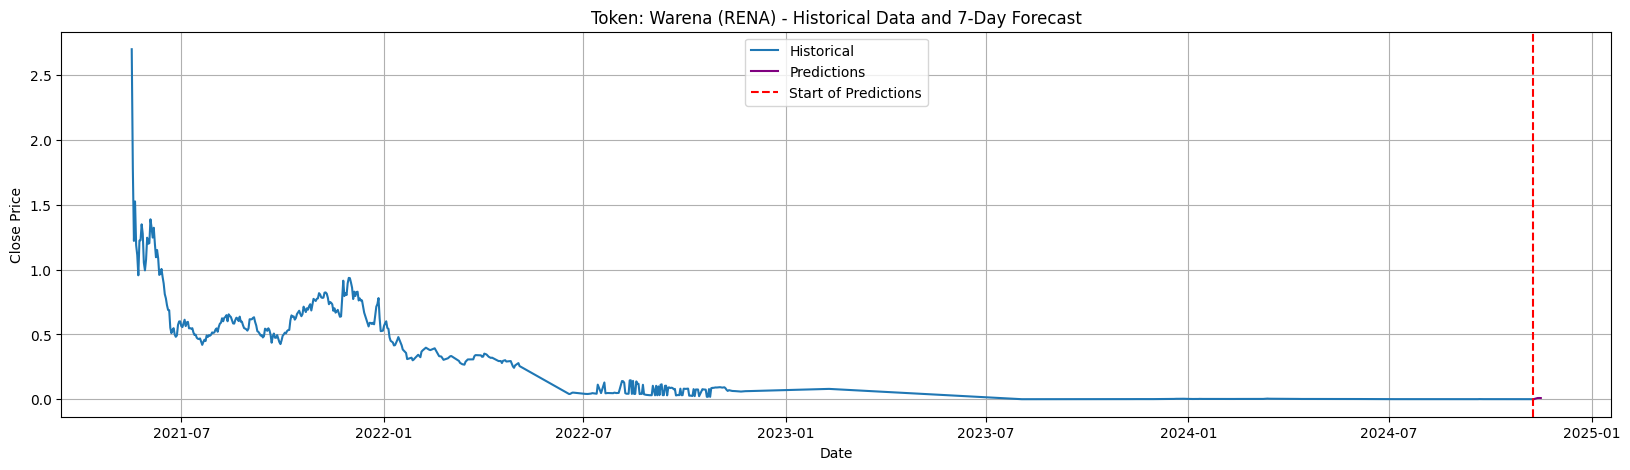

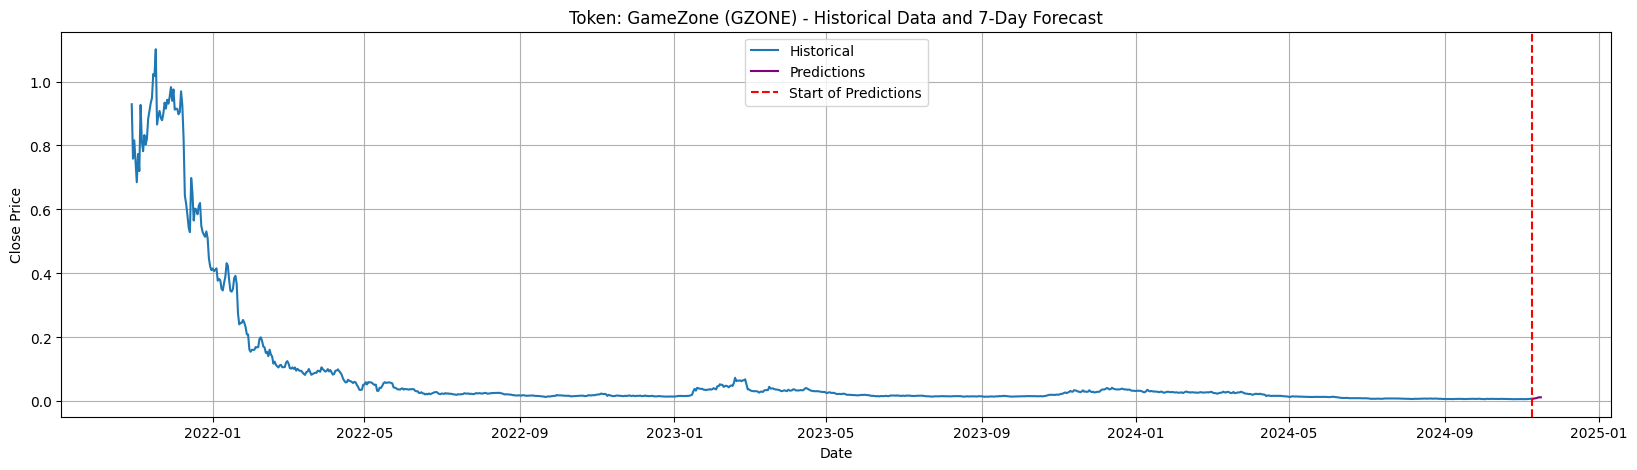

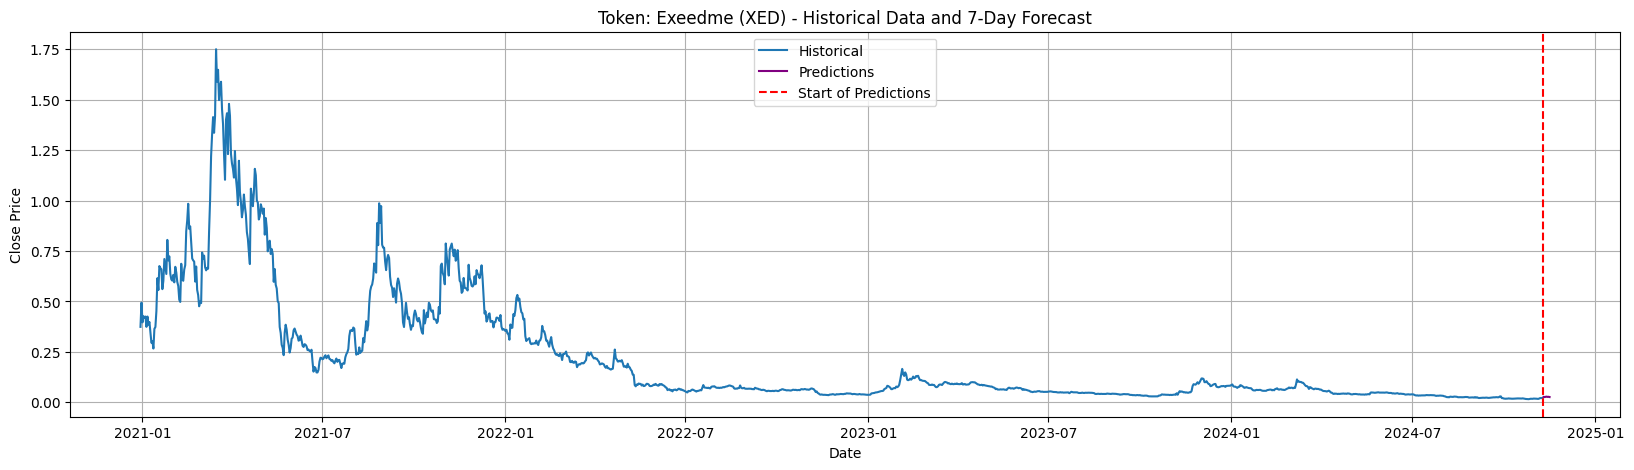

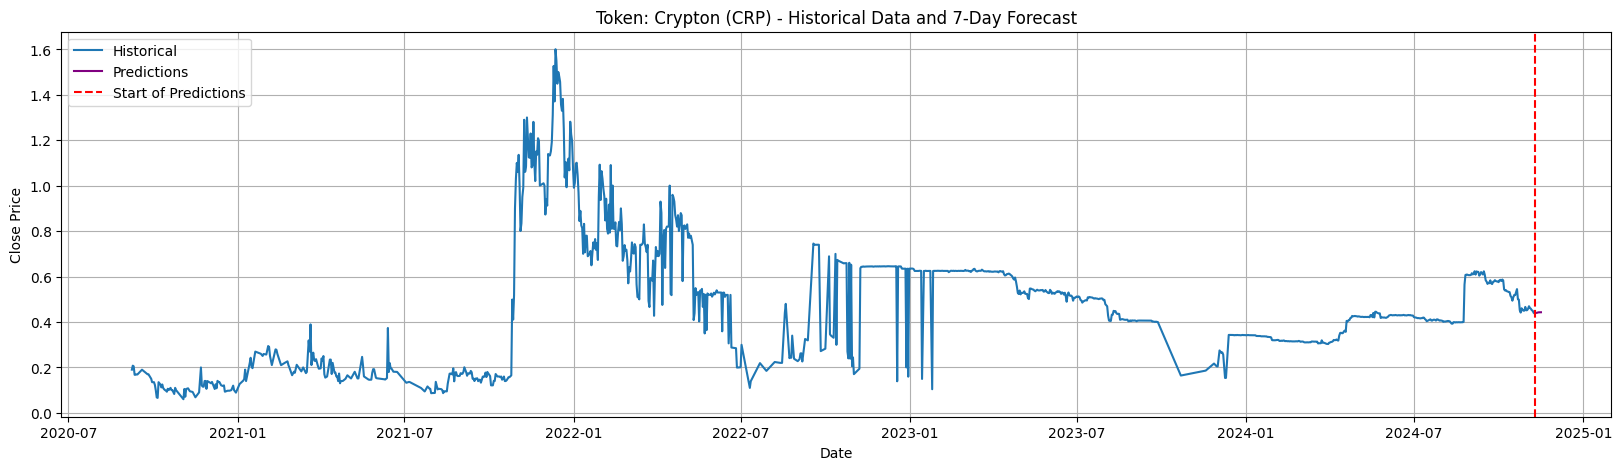

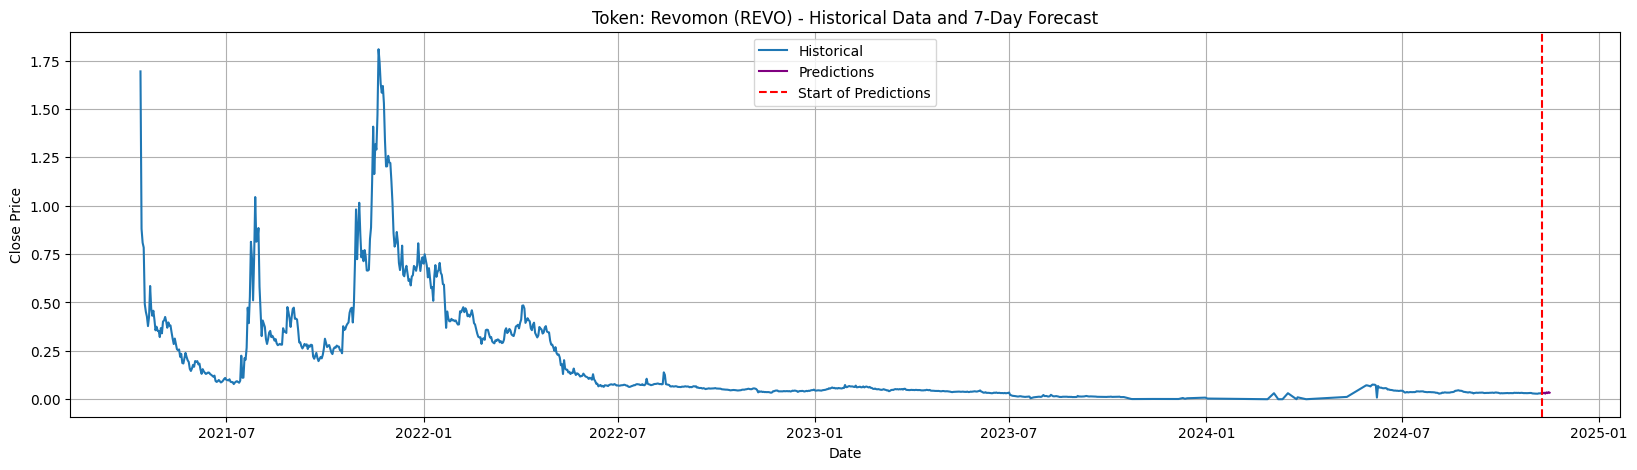

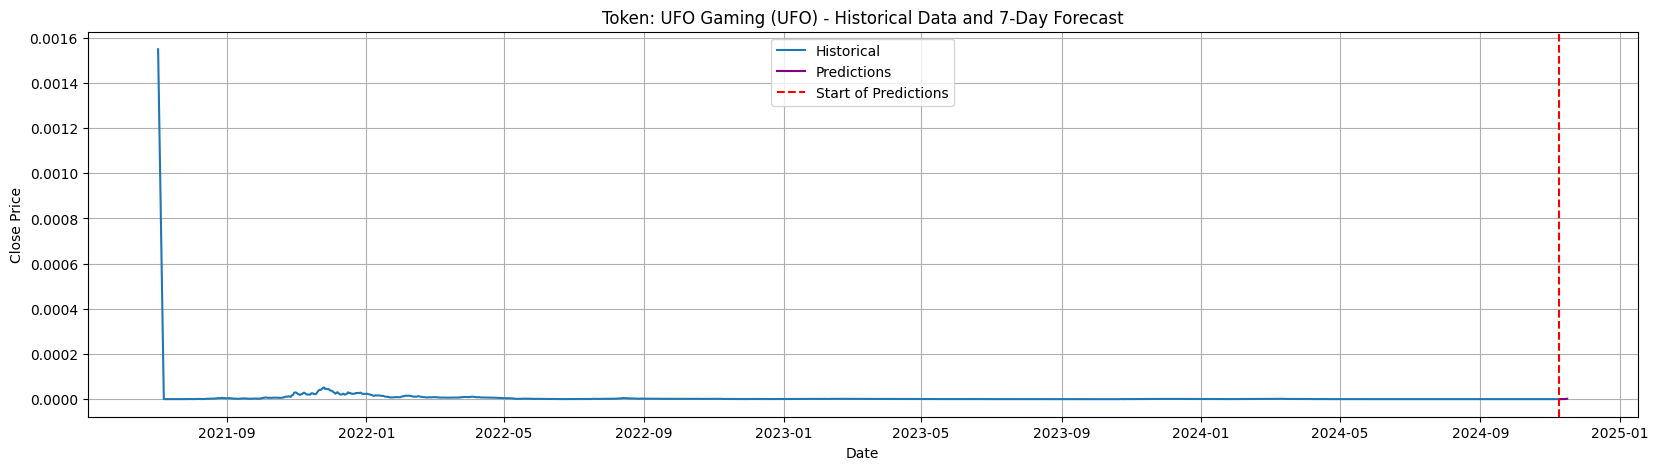

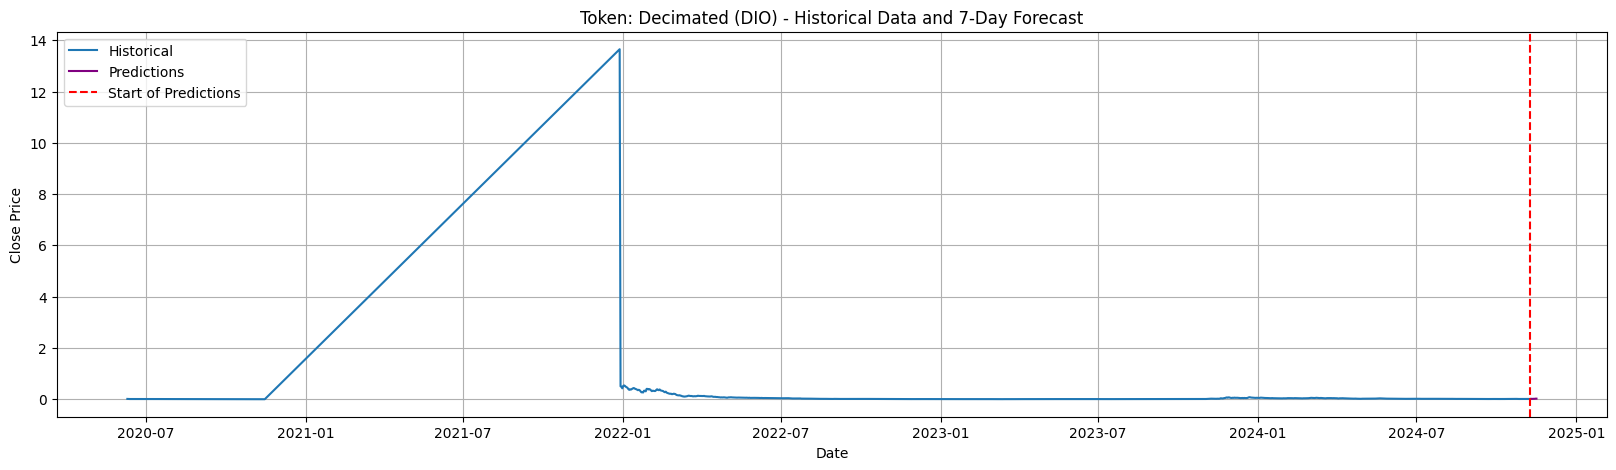

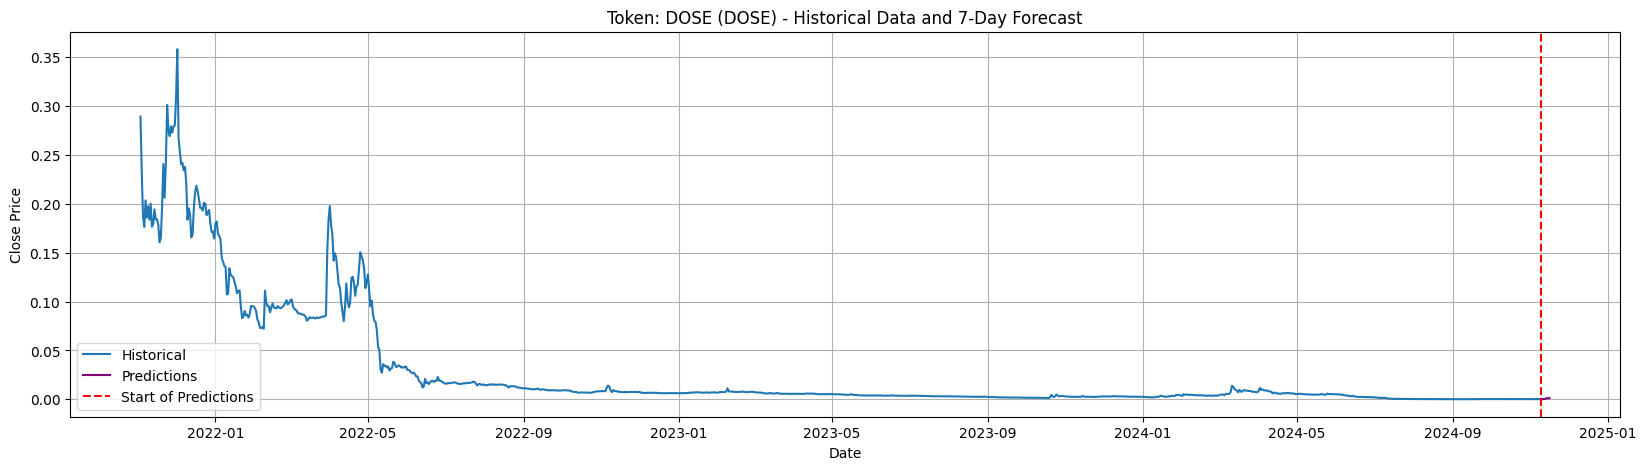

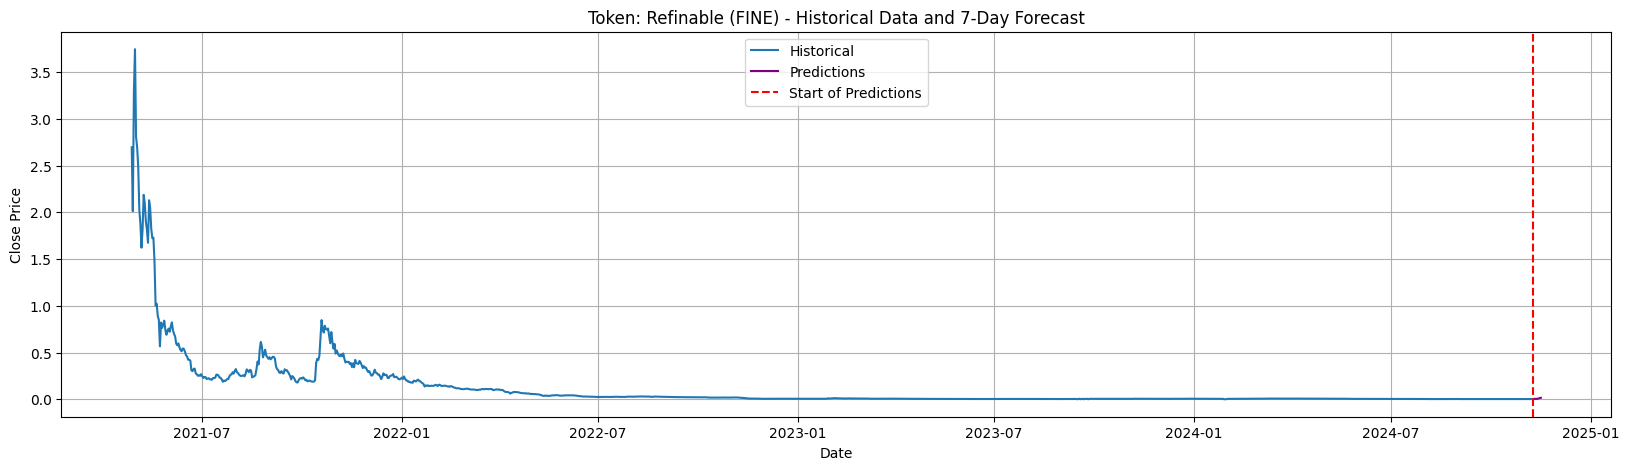

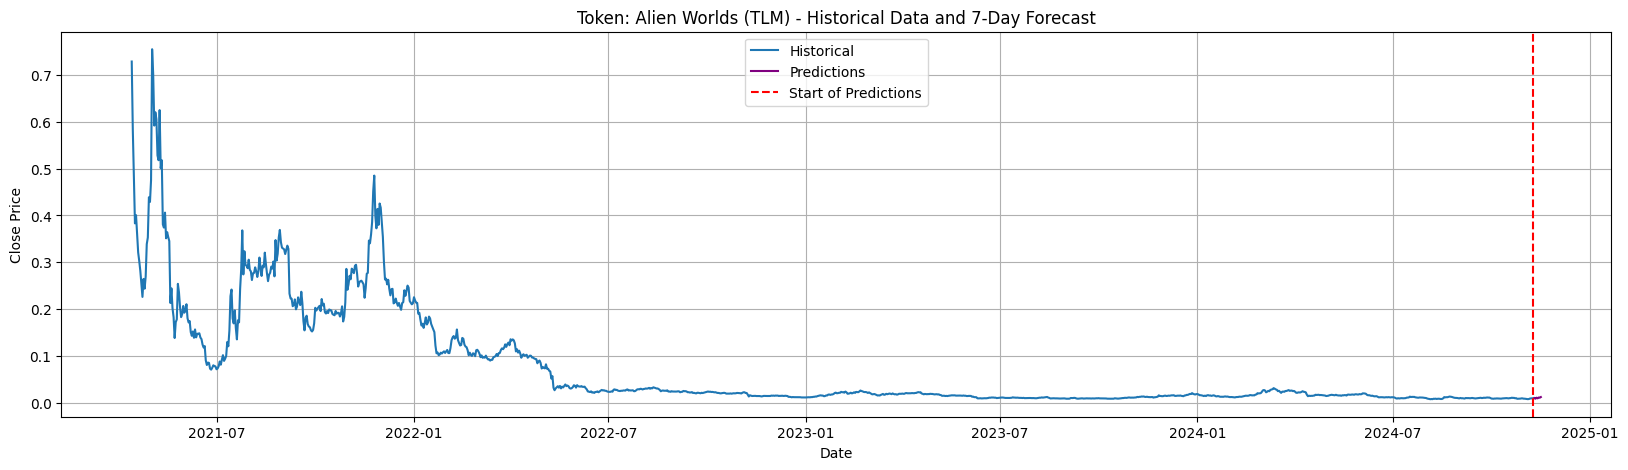

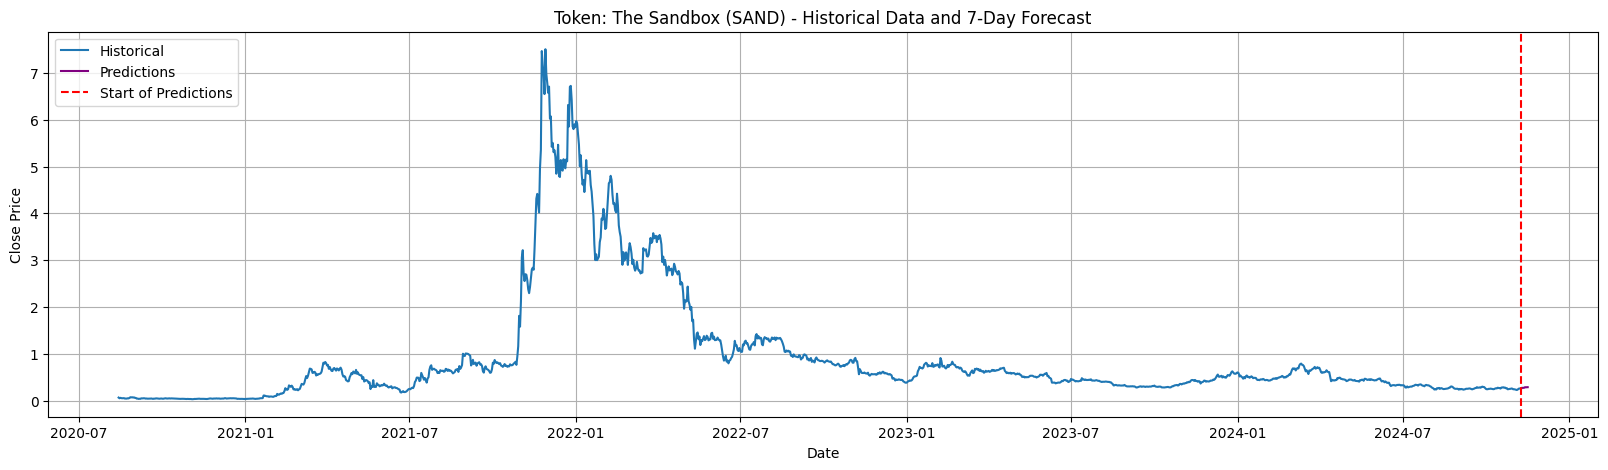

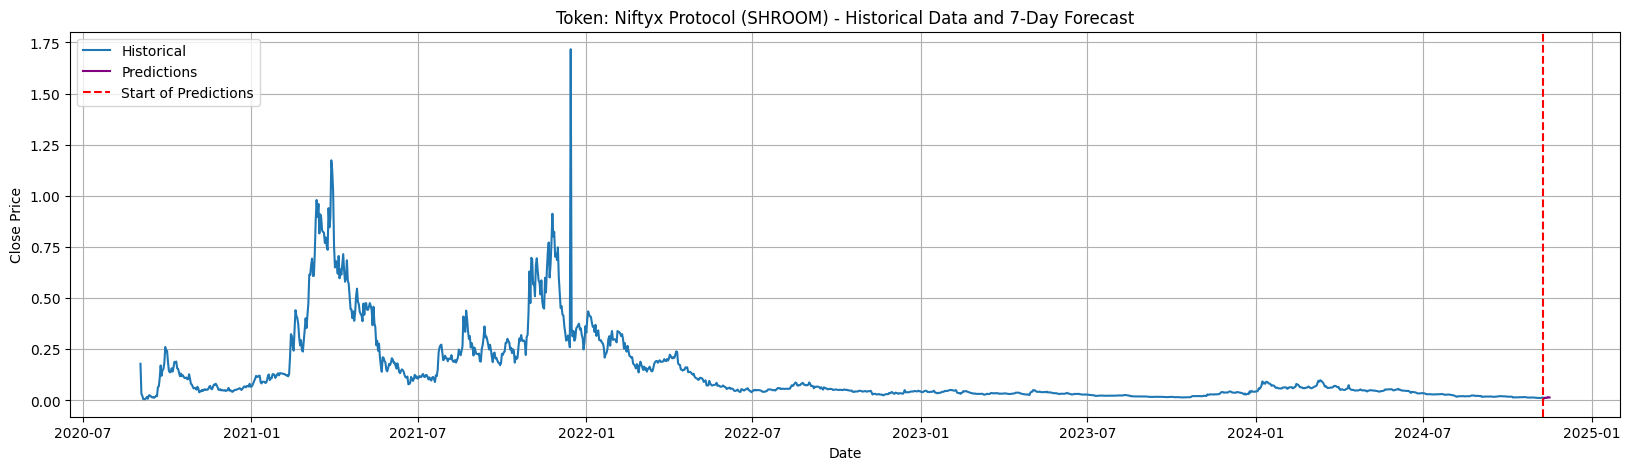

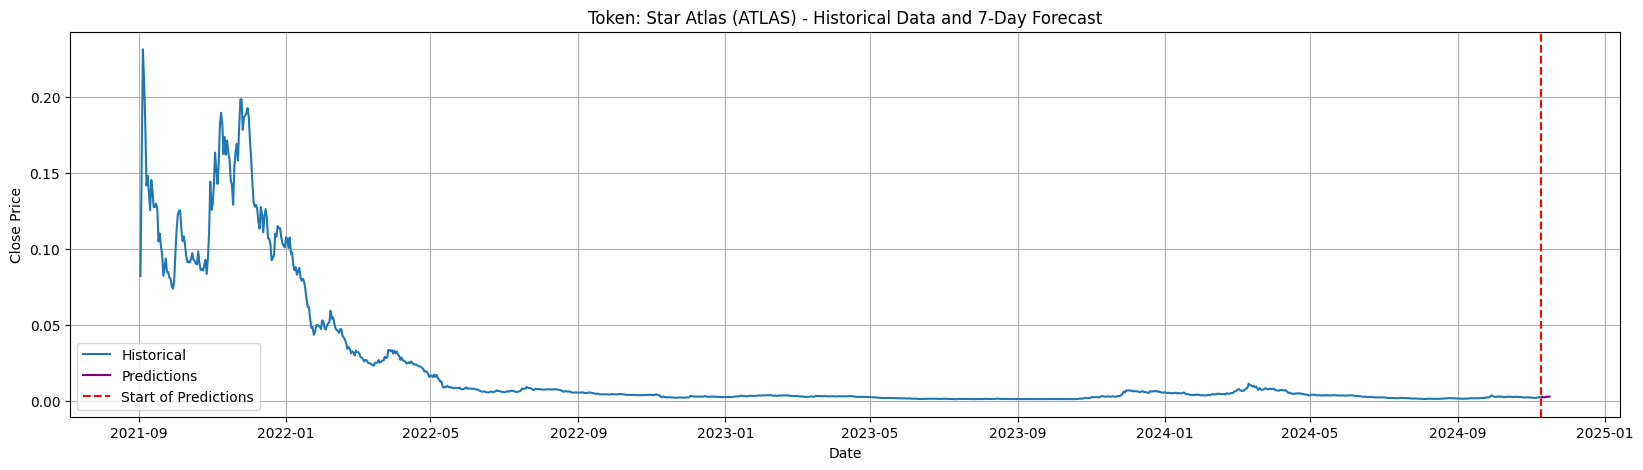

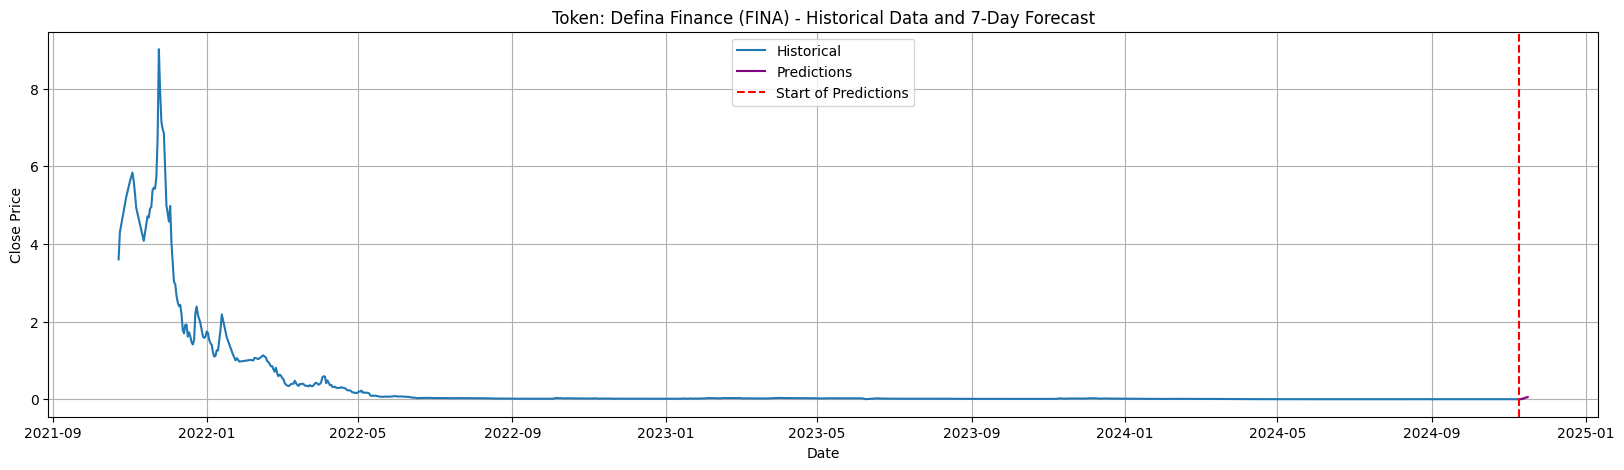

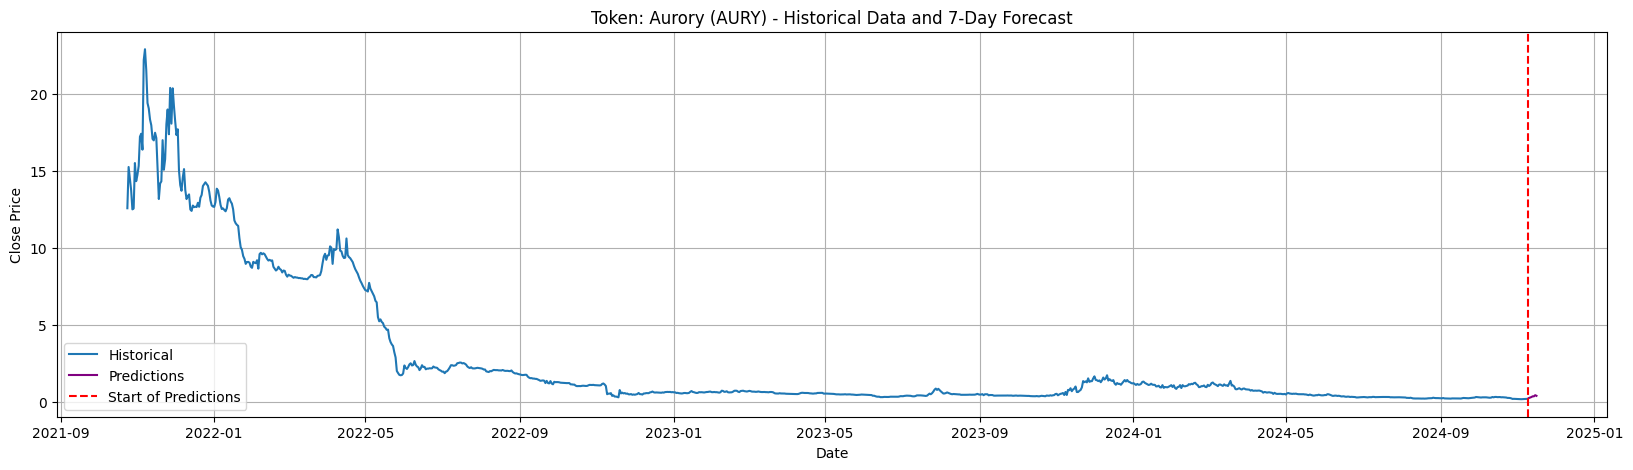

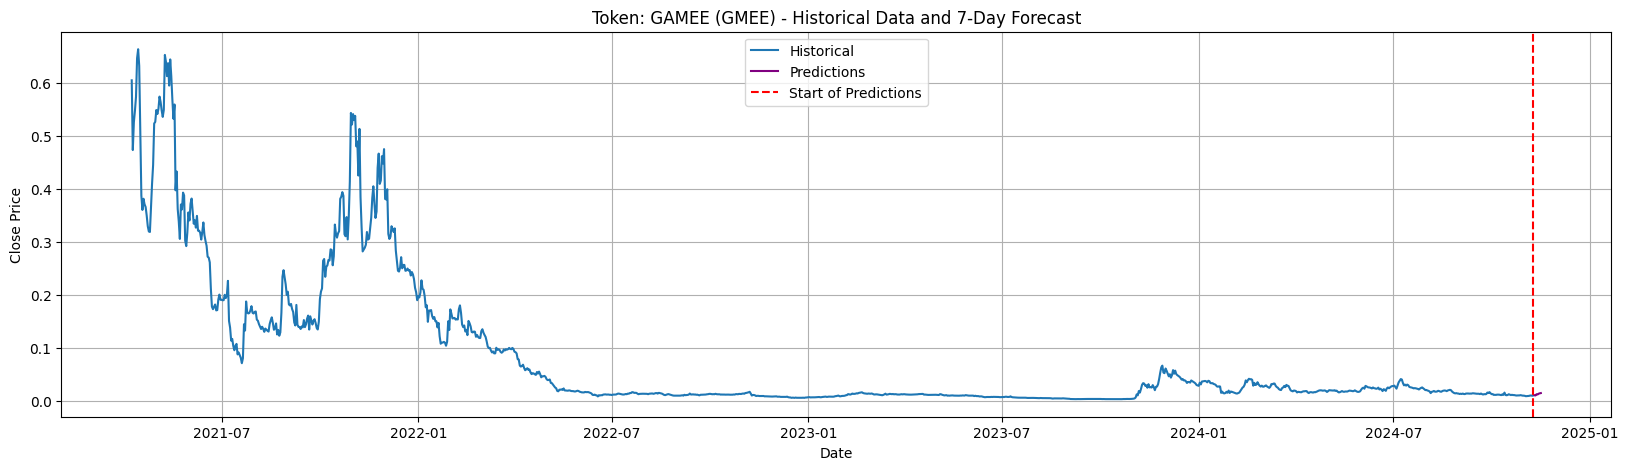

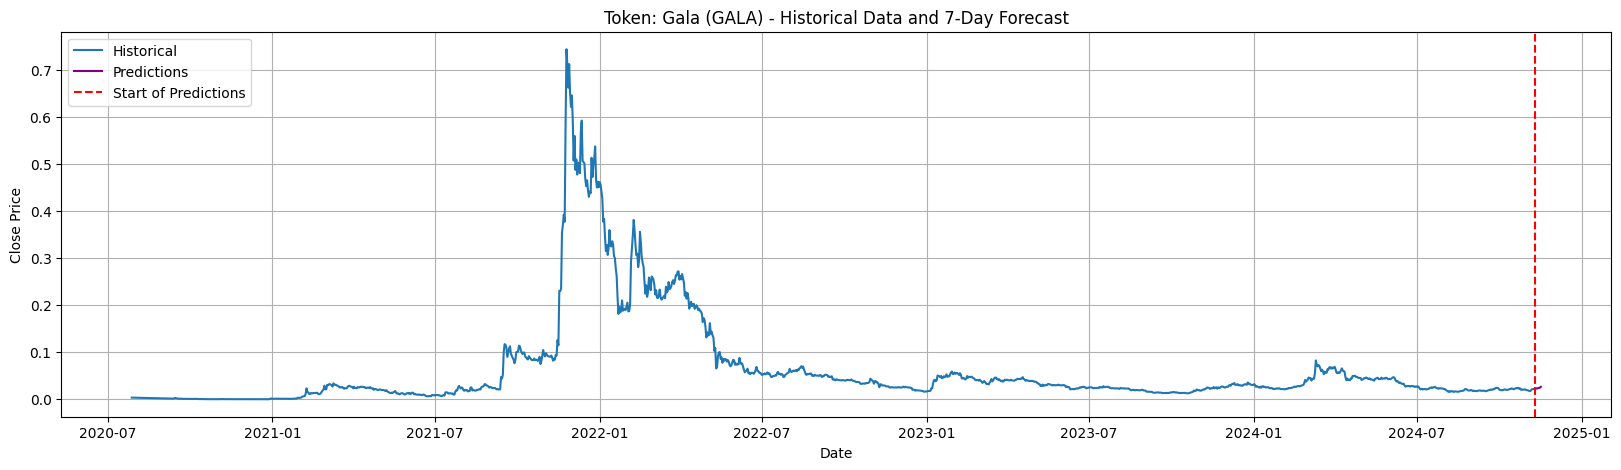

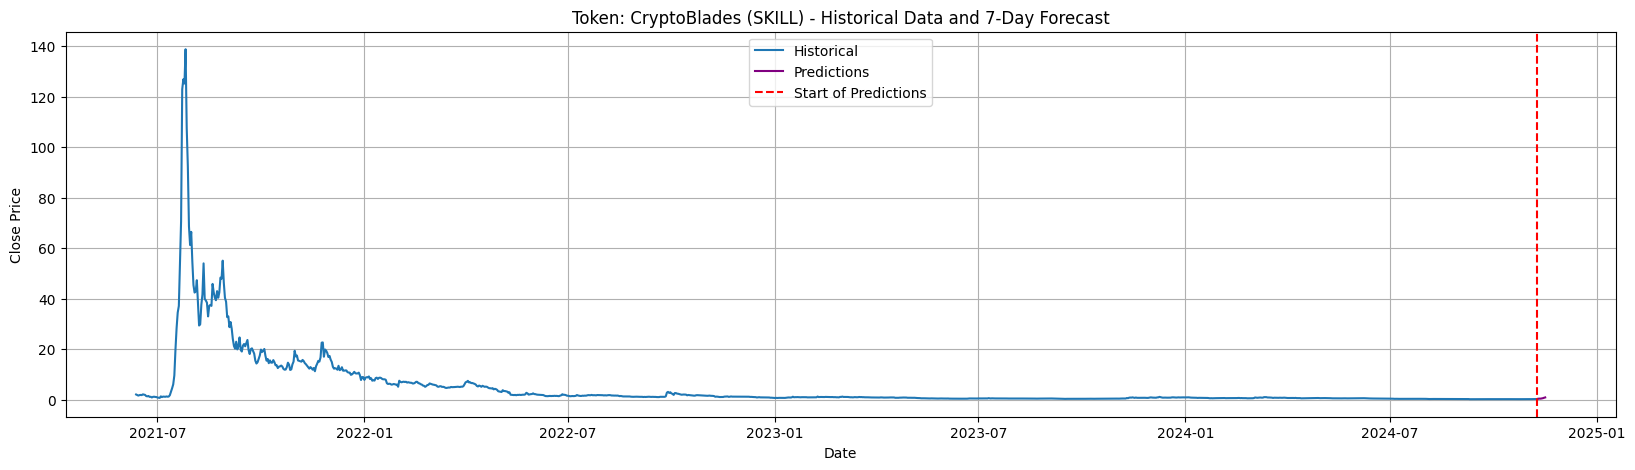

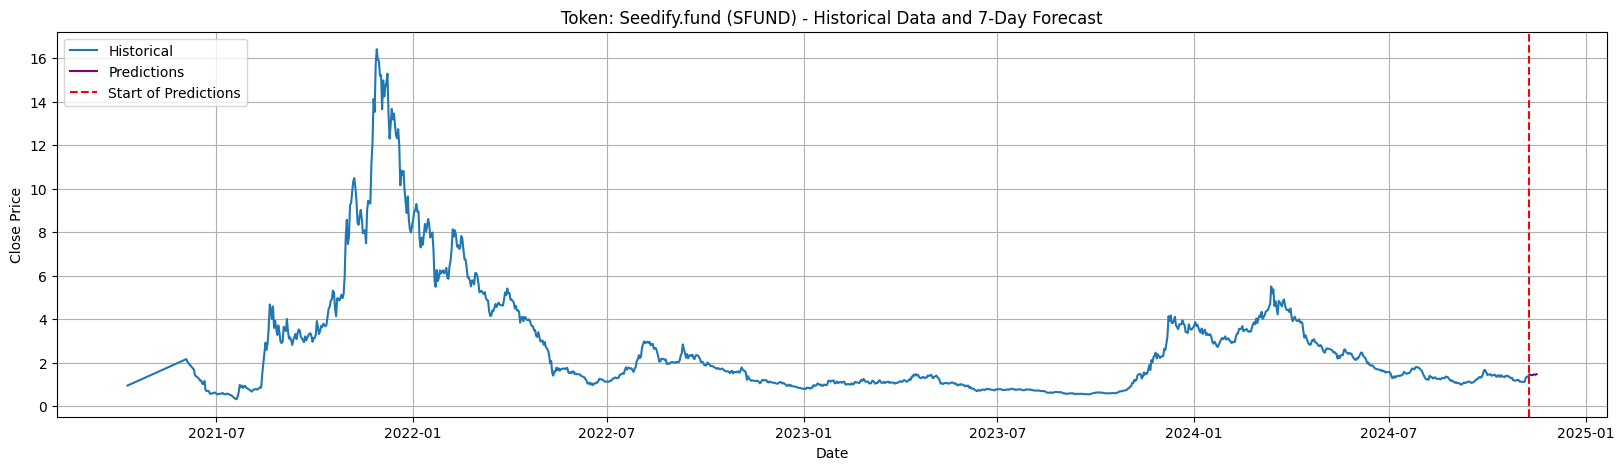

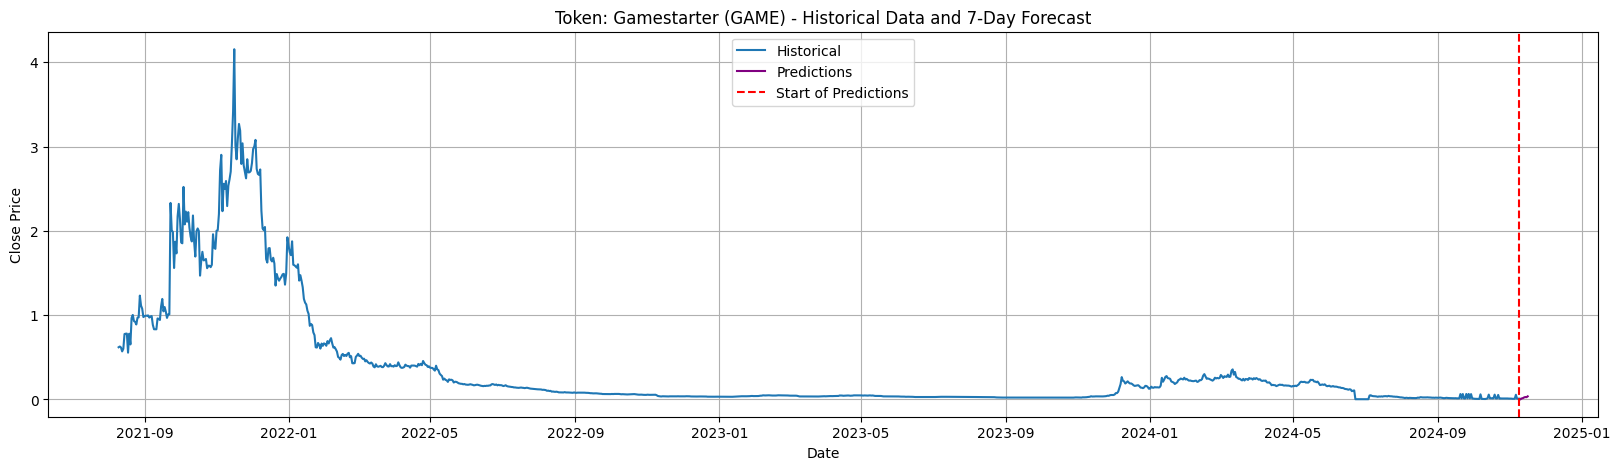

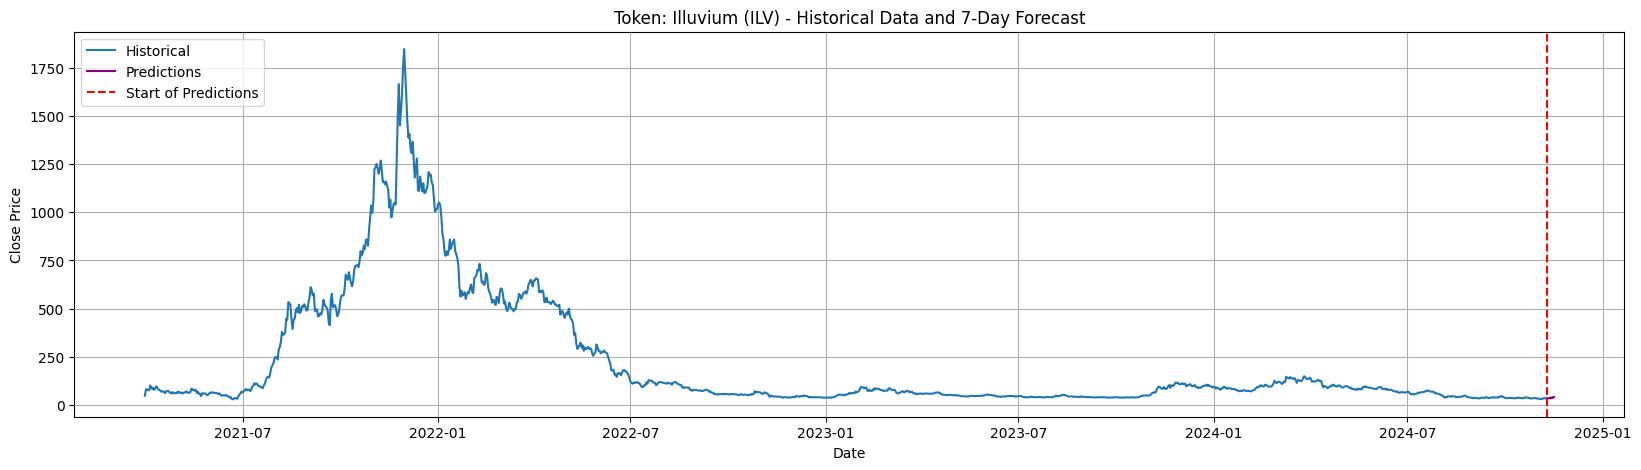

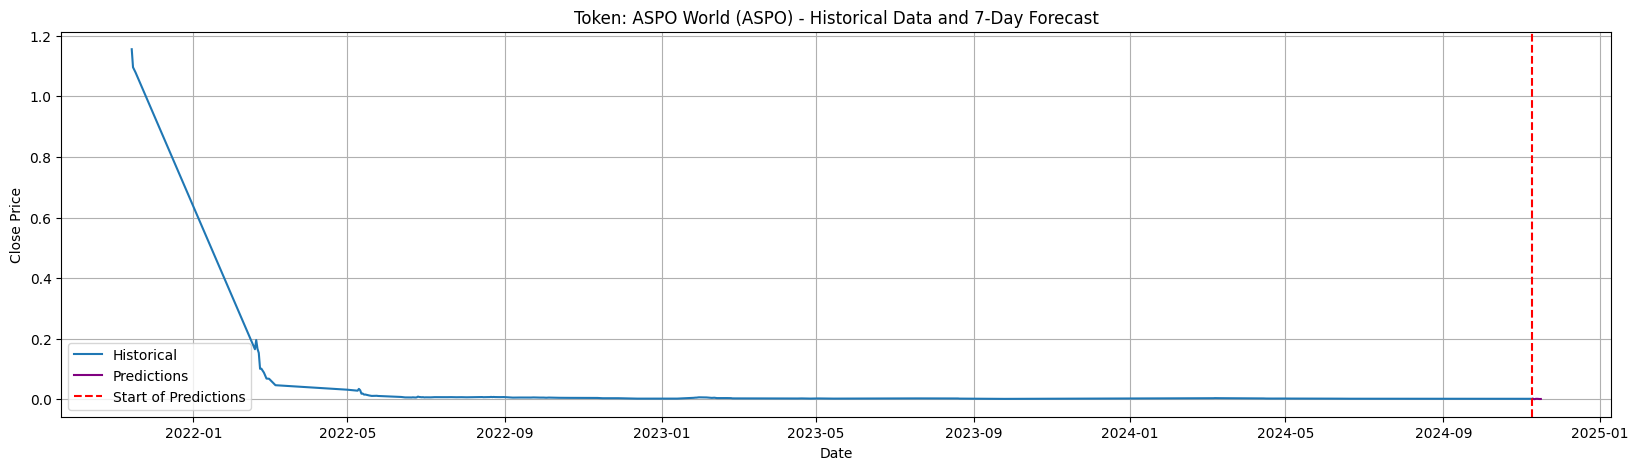

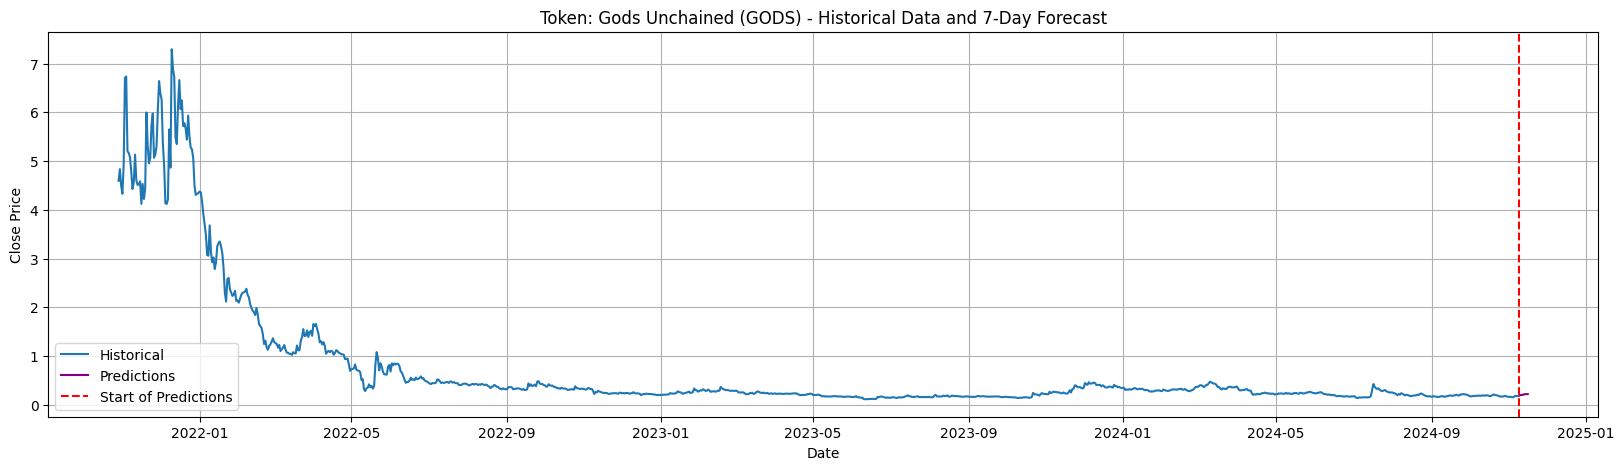

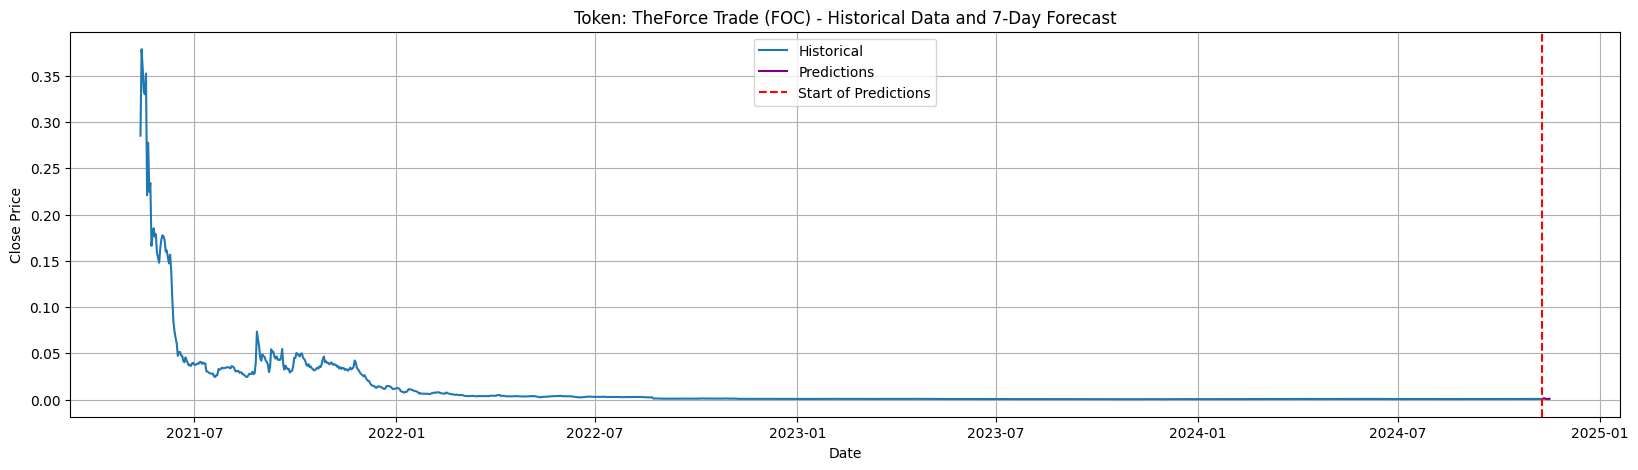

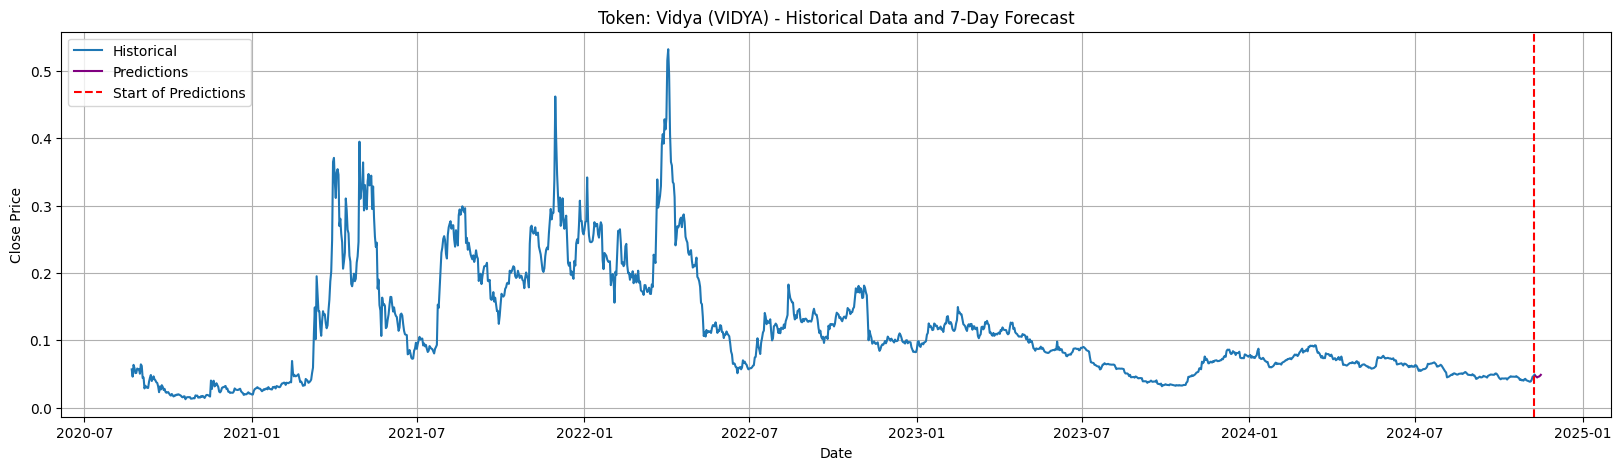

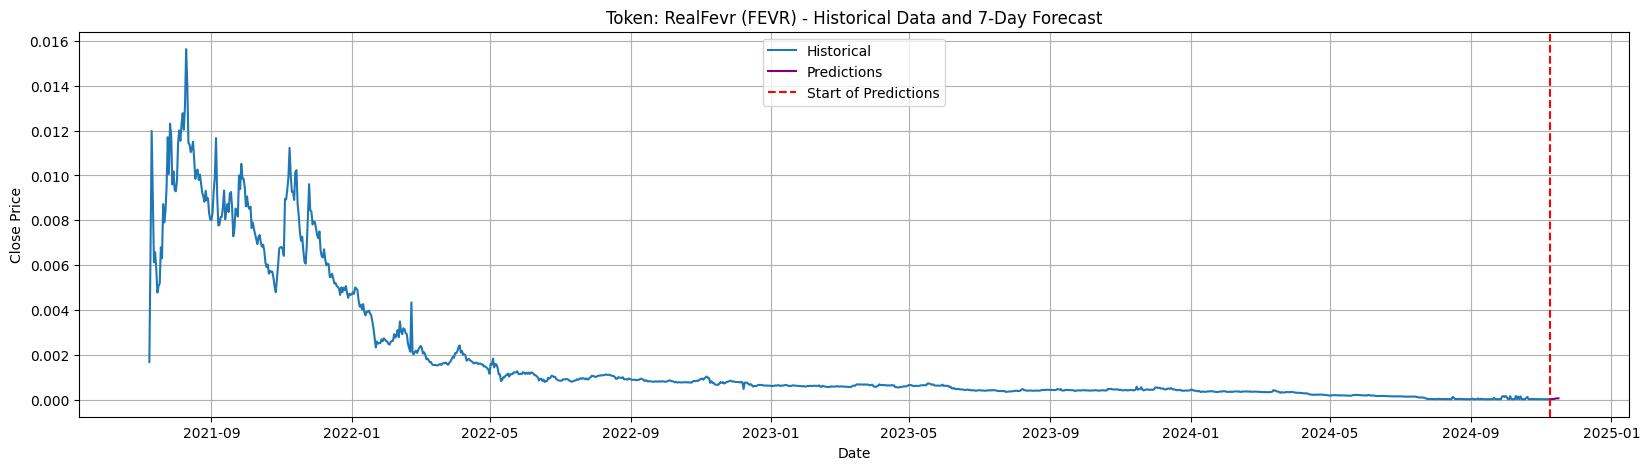

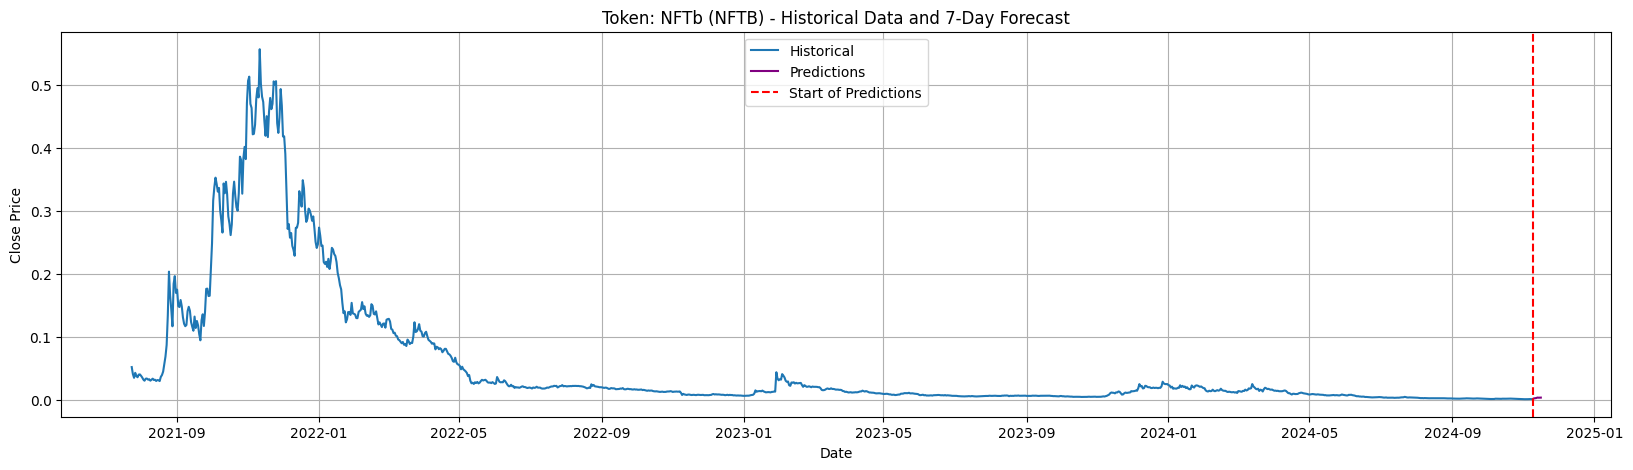

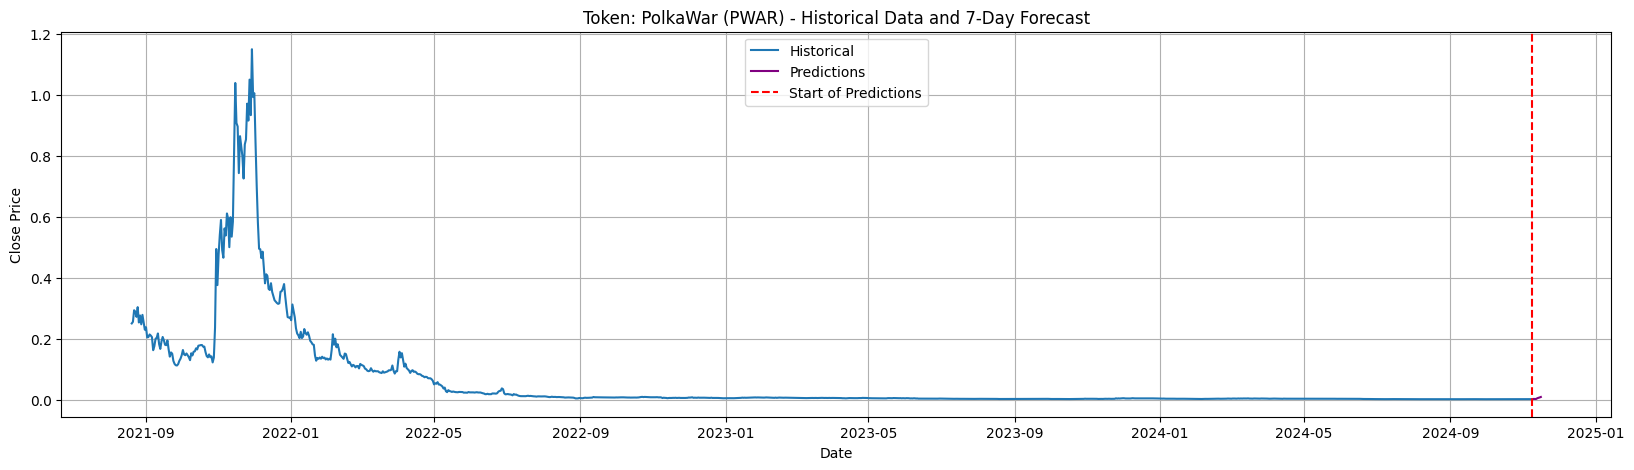

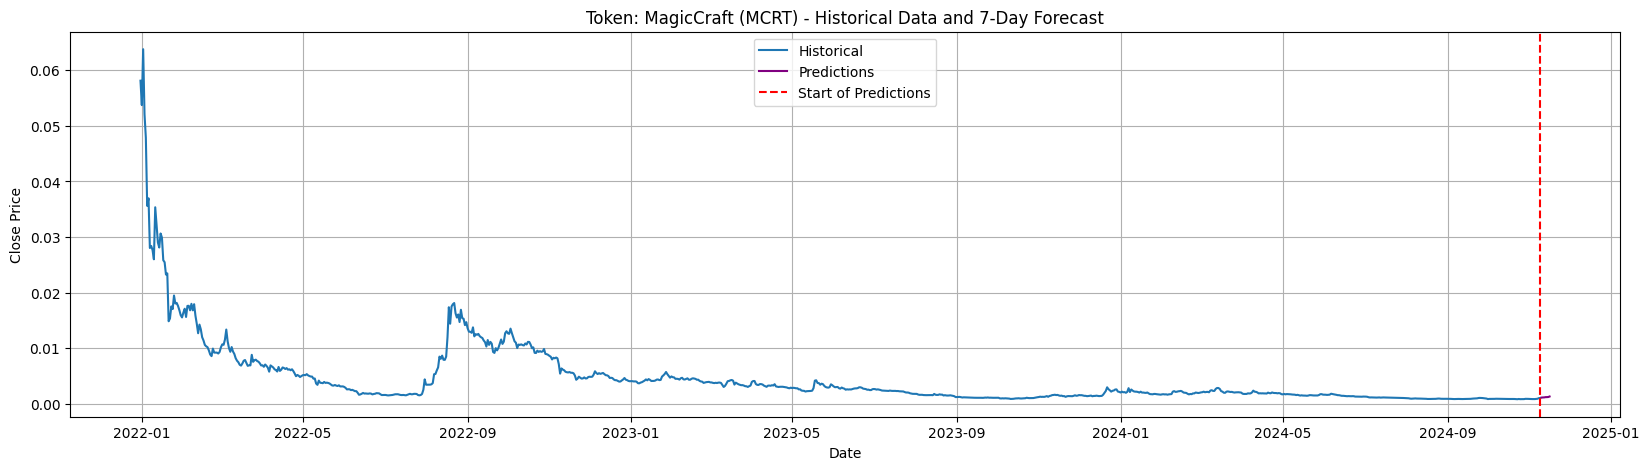

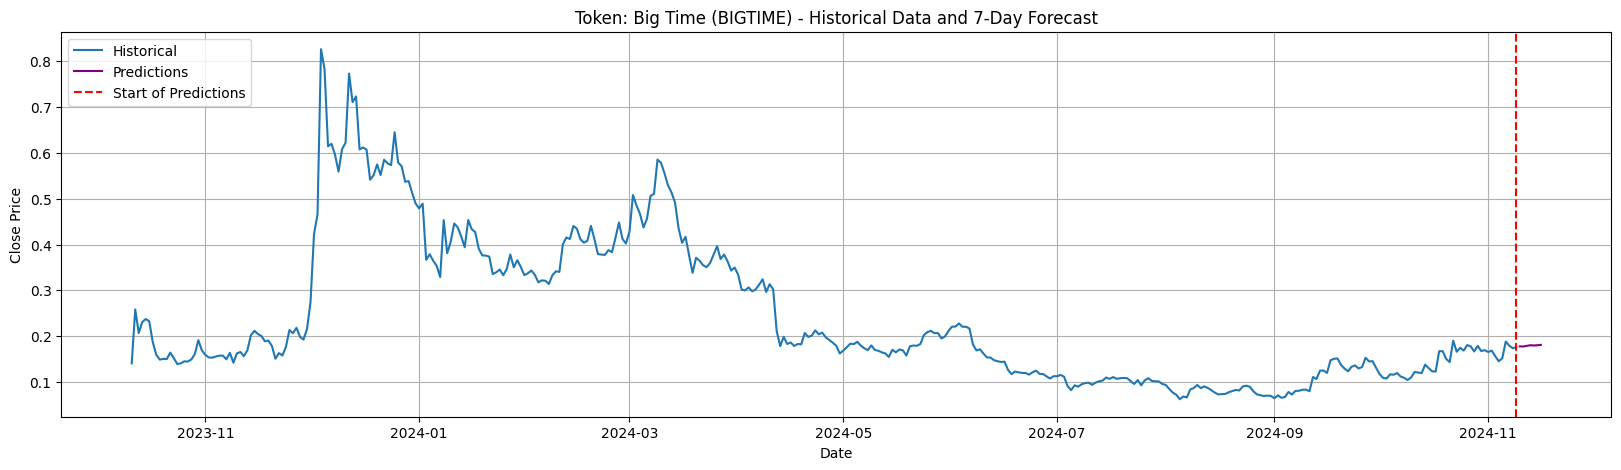

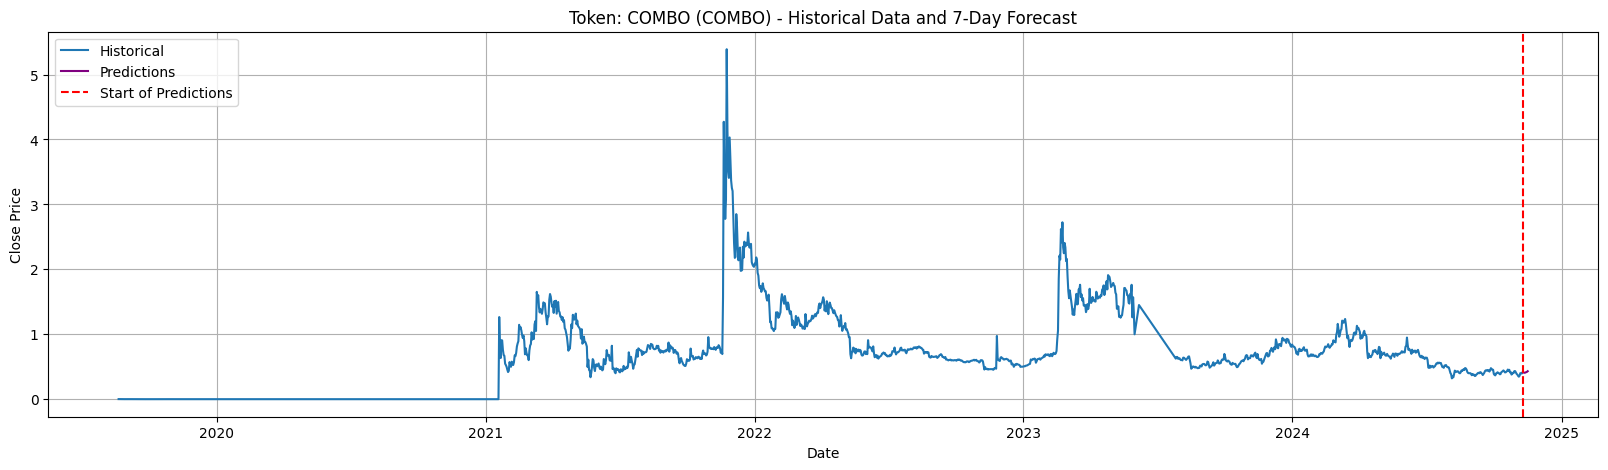

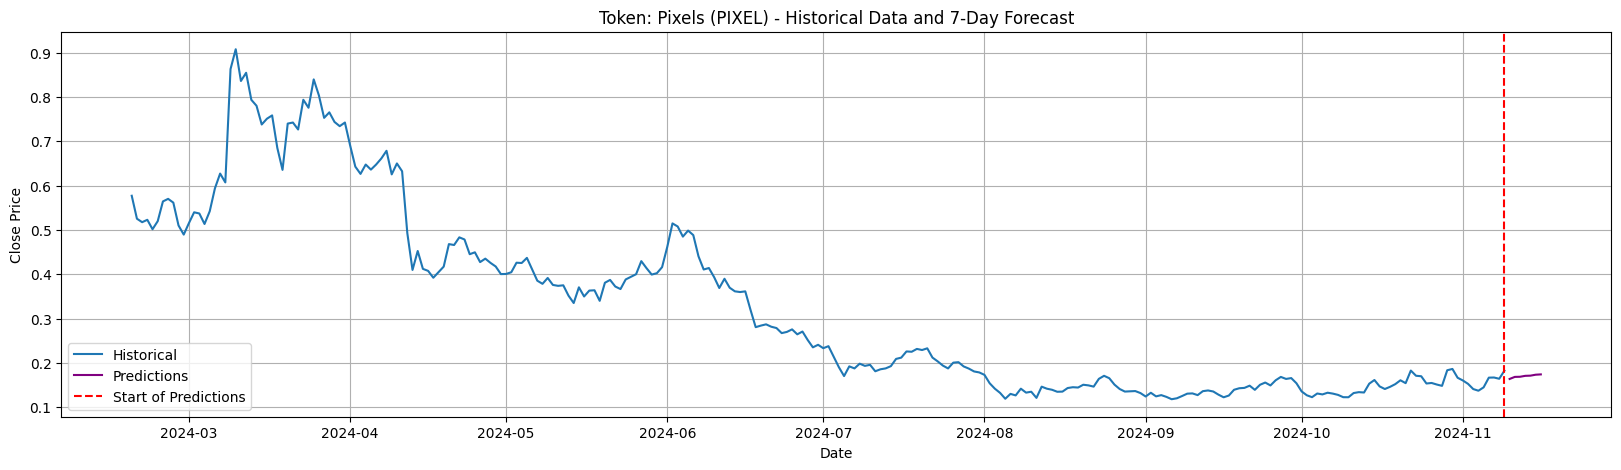

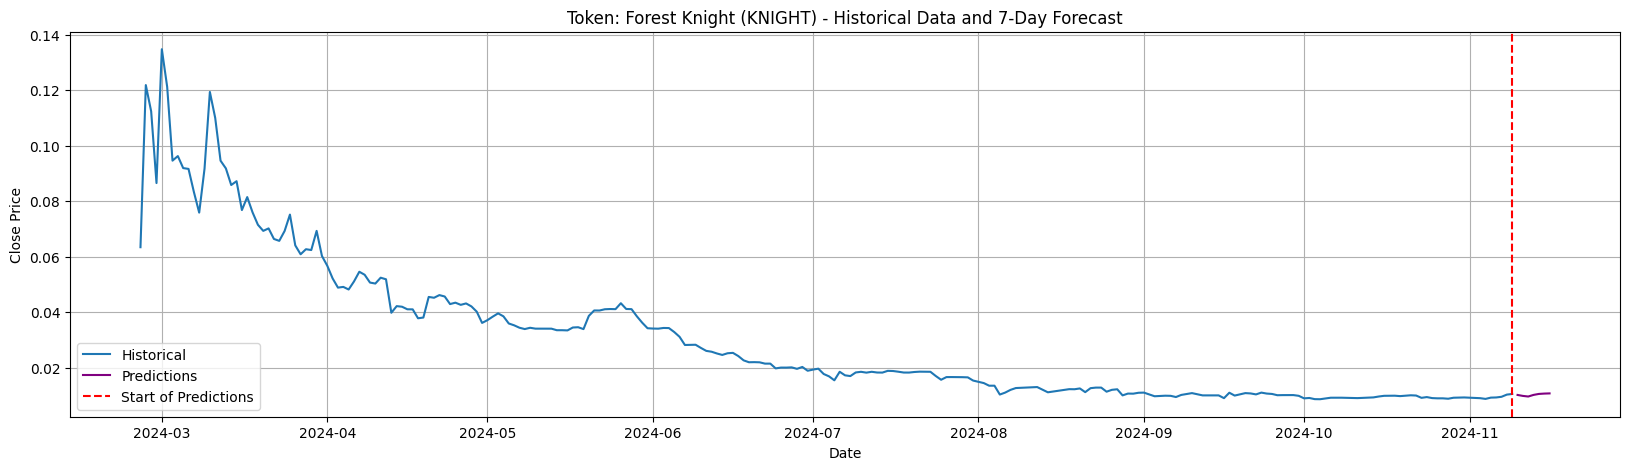

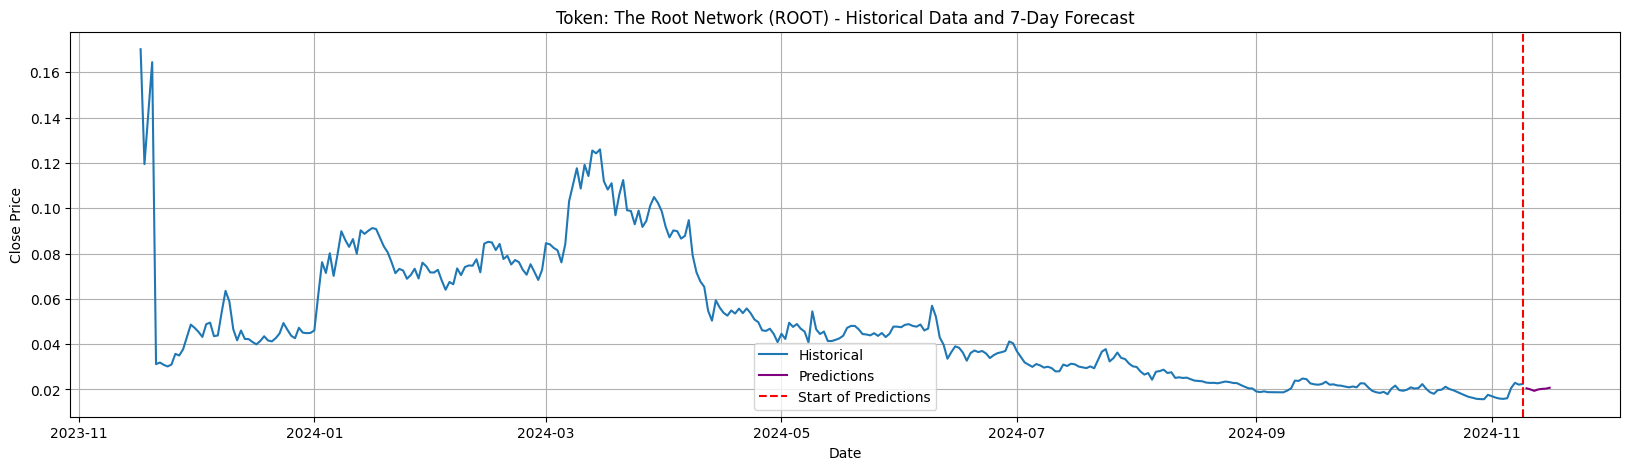

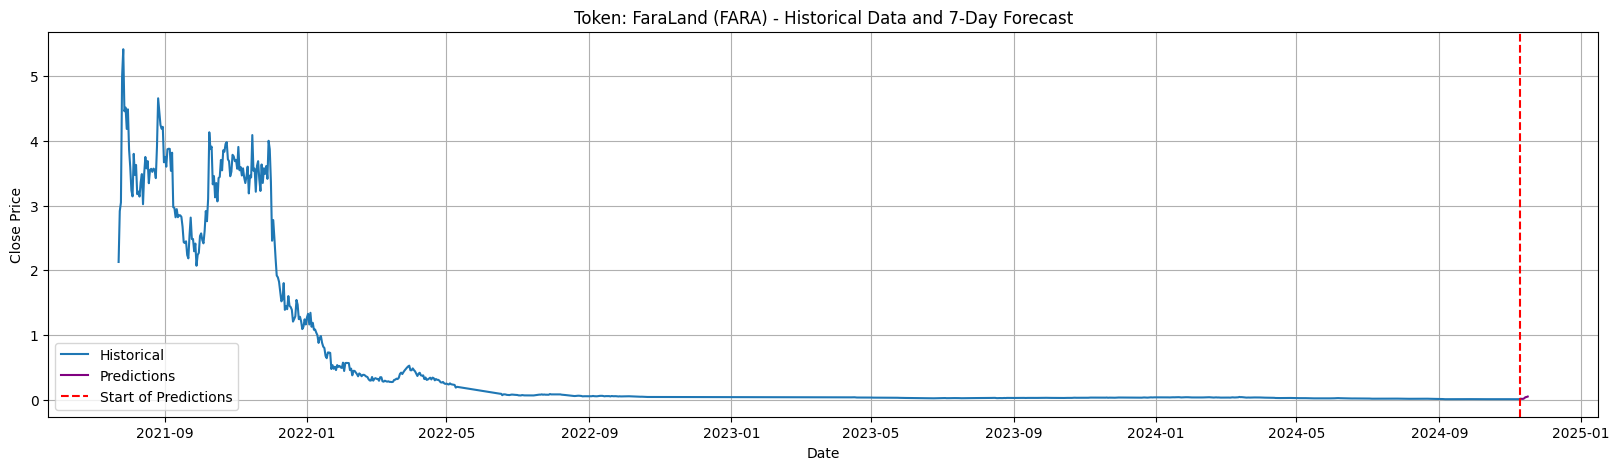

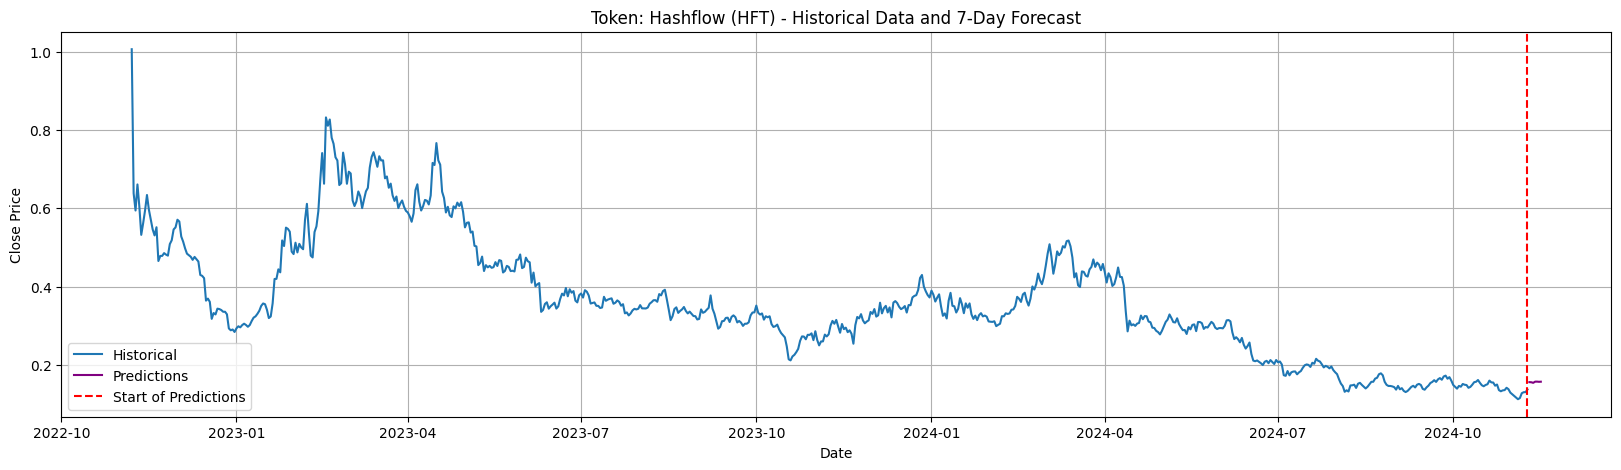

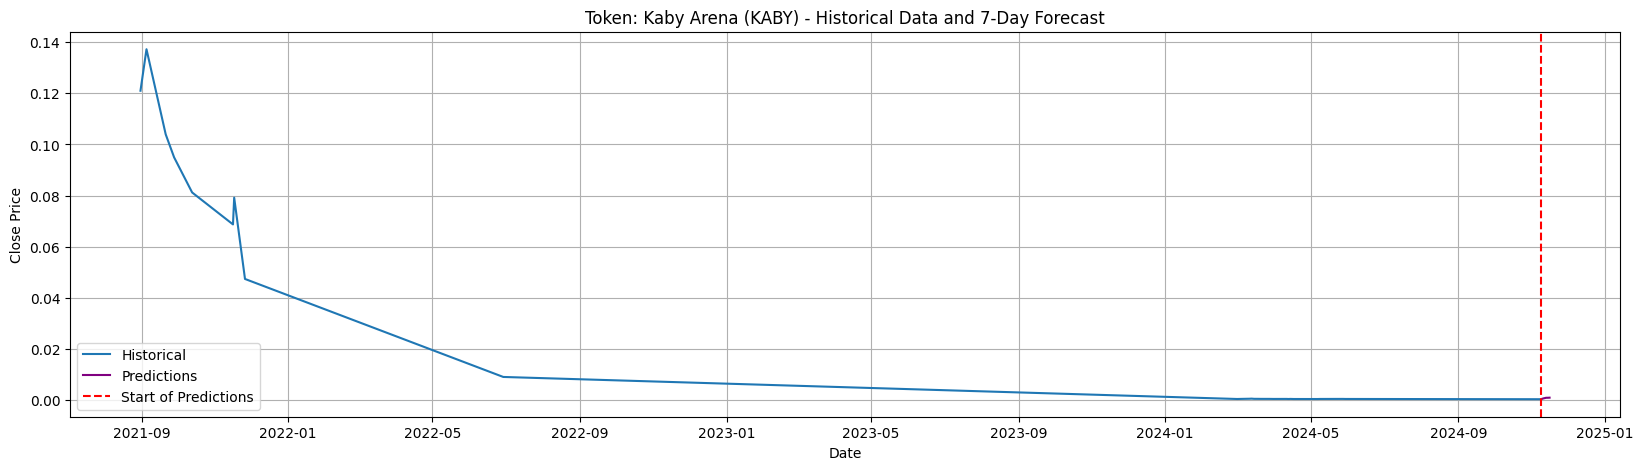

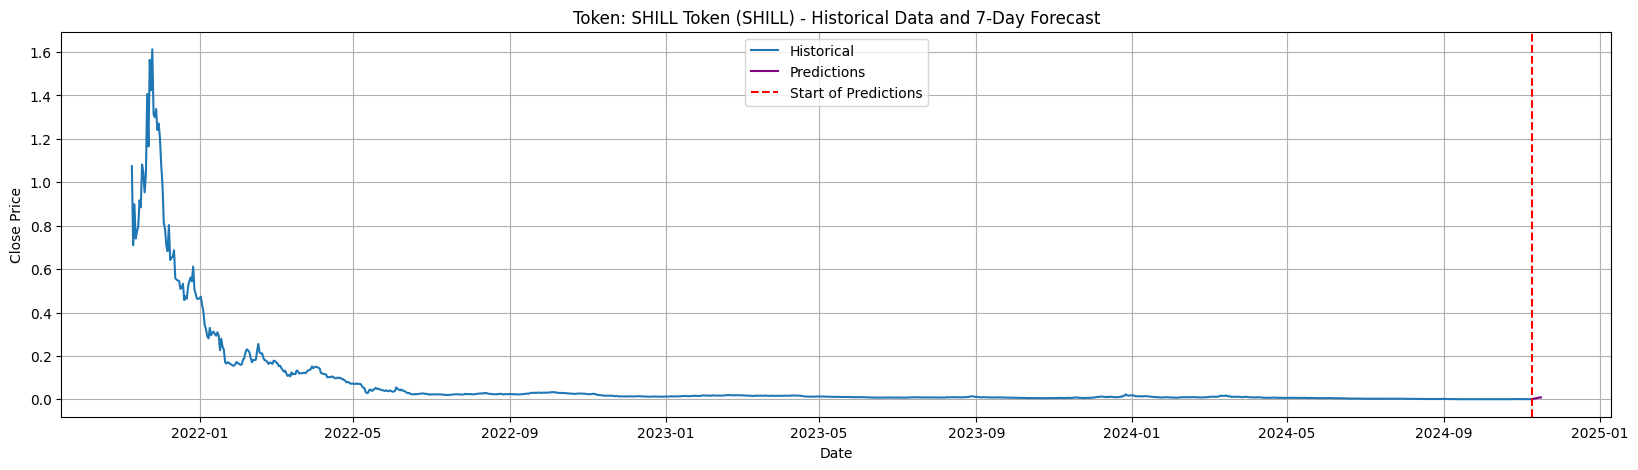

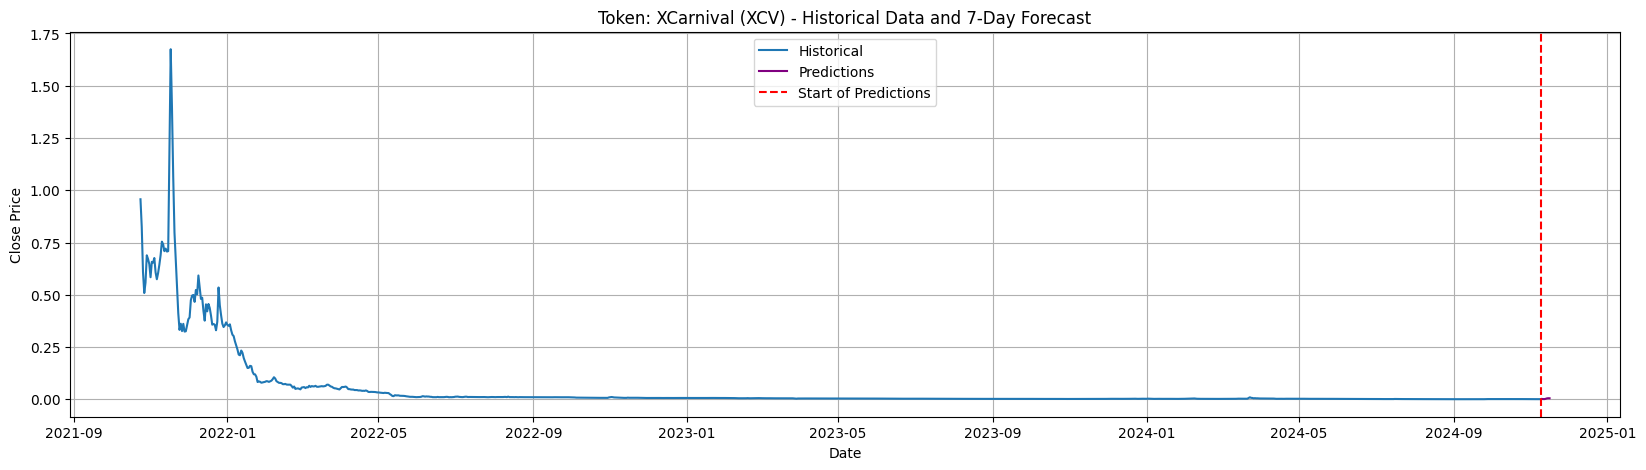

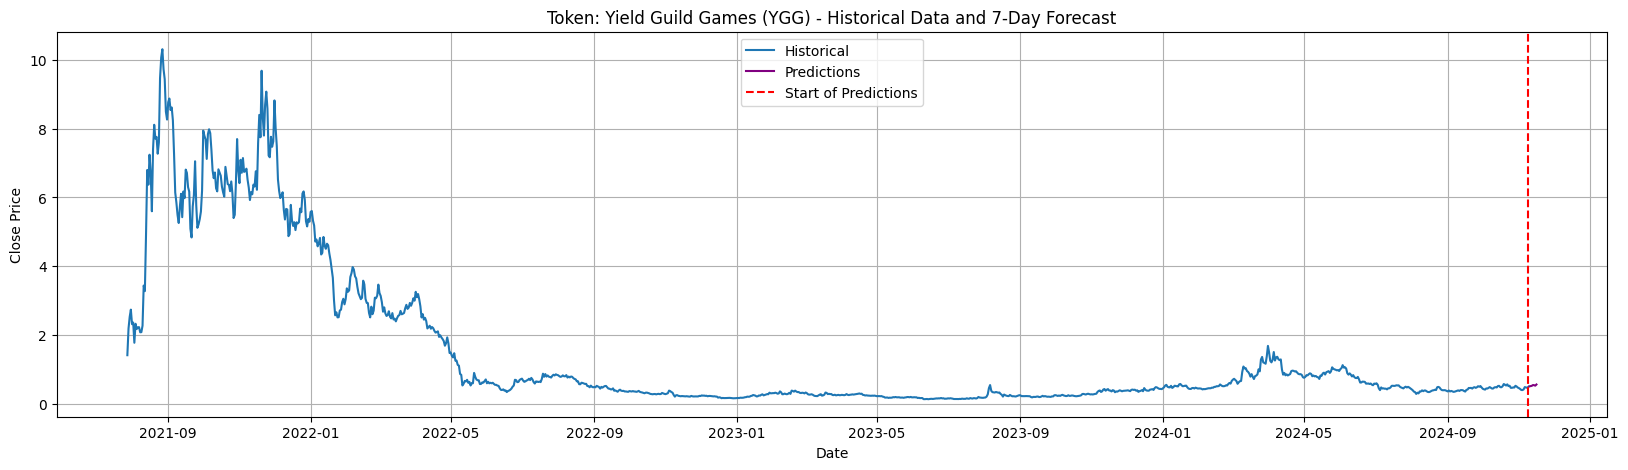

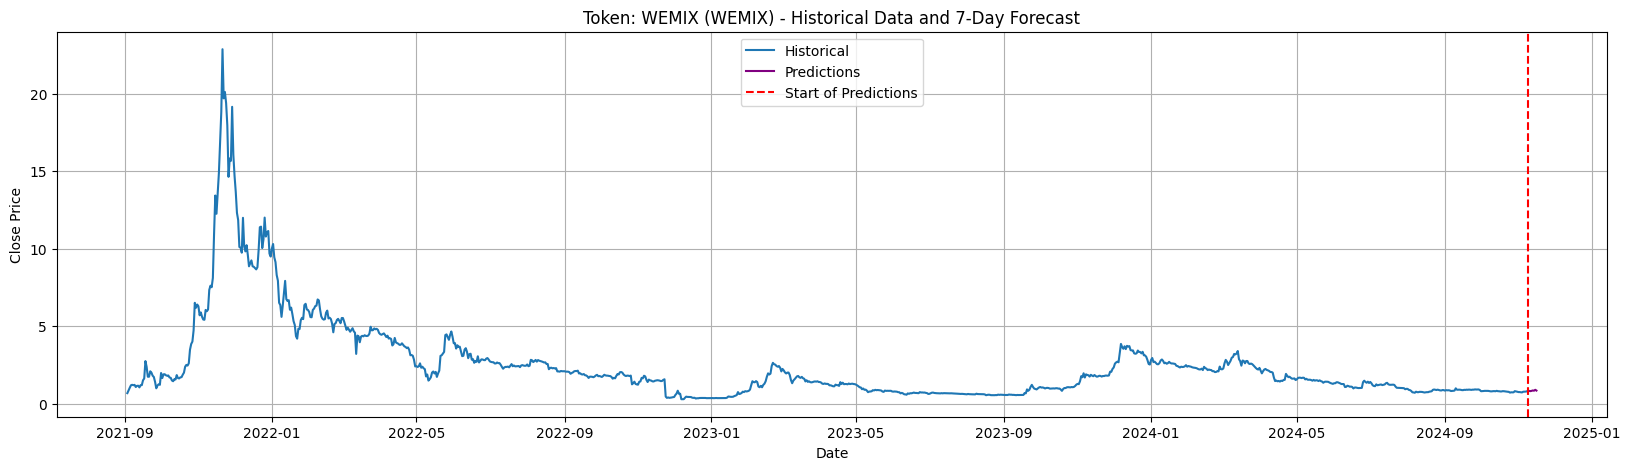

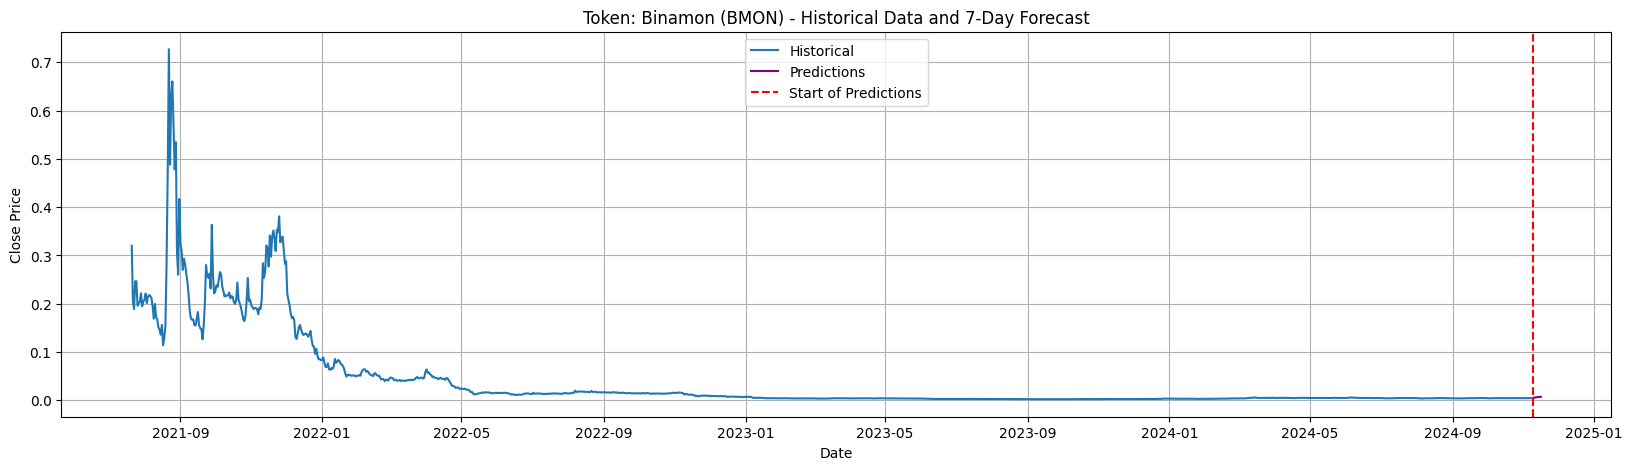

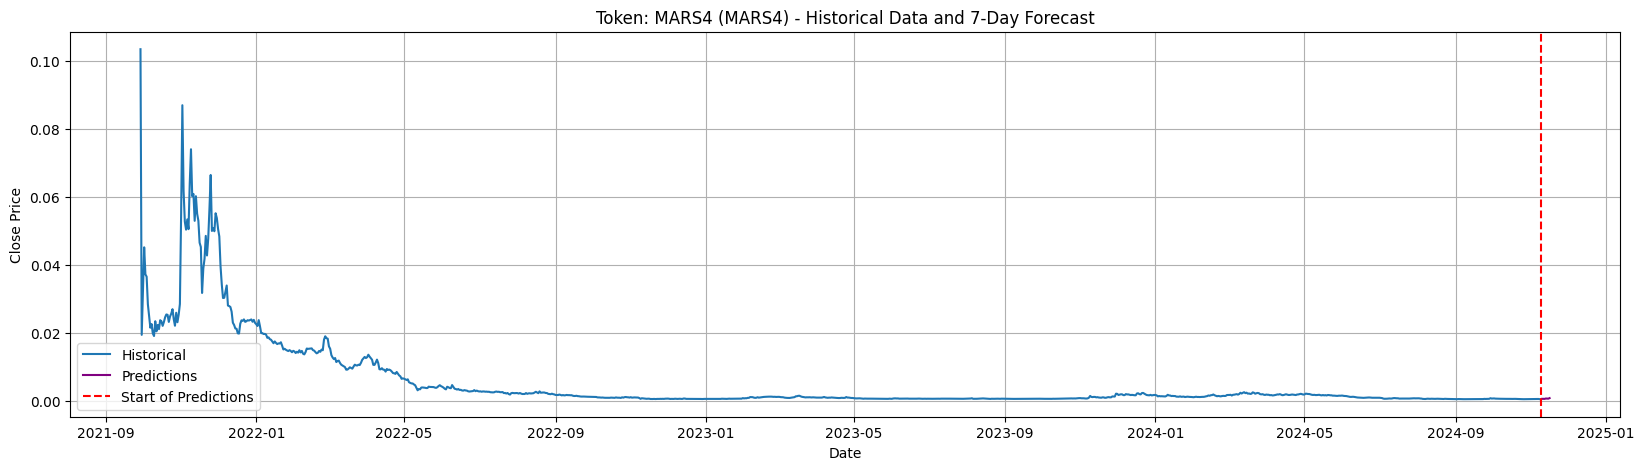

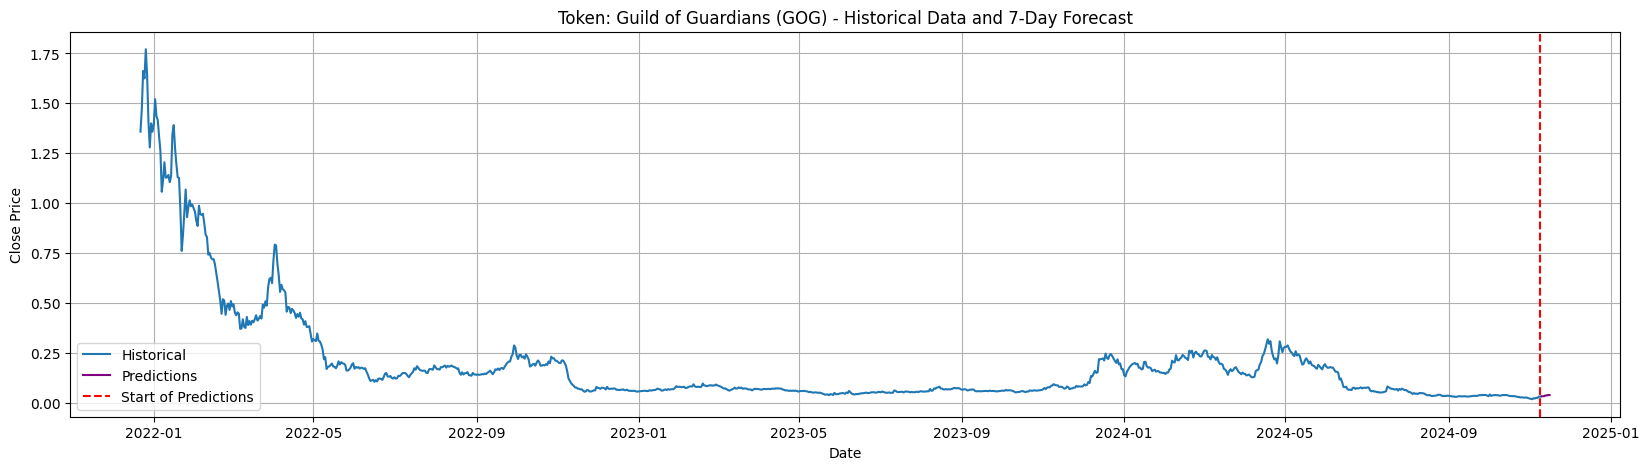

In [27]:
u.plot_predictions_only(train_data=gaming_obj.og_train, predictions_x_days=gaming_obj.og_pred, last_data_points=-1)

In [ ]:
u.plot_predictions(train_data=meme_obj.og_train, predictions_x_days=meme_obj.og_pred, test_data=meme_test, last_data_points=60)